In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt

In [ ]:
GENERATE_RES = 2
GENERATE_SQUARE = 32 * GENERATE_RES
IMAGE_CHANNELS = 3

PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

SEED_SIZE = 100

DATA_PATH = '/content/drive/MyDrive/DataSet_Work'
HAM_PATH = '/content/drive/MyDrive/DataSet_Work/Anaconda1/Train/ham'

EPOCHS = 10000
BATCH_SIZE = 100
BUFFER_SIZE = 1200


print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 64px square images.


In [ ]:
training_binary_path = os.path.join(DATA_PATH, f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.exists(HAM_PATH):
    print(f"The directory {HAM_PATH} does not exist.")
    print("Available directories in DATA_PATH:")
else:
    training_binary_path = os.path.join(DATA_PATH, f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')
    print(f"Looking for file: {training_binary_path}")

    if not os.path.isfile(training_binary_path):
        start = time.time()
        print("Loading training images...")

        training_data = []
        faces_path = HAM_PATH
        for filename in tqdm(os.listdir(faces_path)):
            path = os.path.join(faces_path, filename)
            try:
                image = Image.open(path).convert('RGB').resize((GENERATE_SQUARE, GENERATE_SQUARE), Image.LANCZOS)
                training_data.append(np.asarray(image))
            except Exception as e:
                print(f"Error loading image {filename}: {e}")

        training_data = np.array(training_data)
        training_data = training_data.astype(np.float32)
        training_data = training_data / 127.5 - 1.

        print("Saving training image binary...")
        np.save(training_binary_path, training_data)
        elapsed = time.time() - start
        print(f'Image preprocess time: {hms_string(elapsed)}')
    else:
        print("Loading previous training pickle...")
        training_data = np.load(training_binary_path)

Looking for file: /content/drive/MyDrive/DataSet_Work/training_data_64_64.npy
Looking for file: /content/drive/MyDrive/DataSet_Work/training_data_64_64.npy
Loading training images...


100%|██████████| 1384/1384 [00:38<00:00, 35.86it/s] 


Saving training image binary...
Image preprocess time: 0:00:45.25


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape,
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
def save_images(cnt,noise):
  image_array = np.full((
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)),
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS),
      255, dtype=np.uint8)

  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1


  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

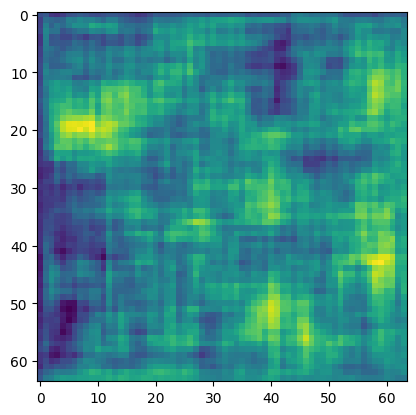

In [ ]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5005726]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return fake_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [ ]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)


    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator,
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS,
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in tqdm(dataset):
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])
    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           f' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

In [ ]:
train(train_dataset, EPOCHS)

100%|██████████| 47/47 [00:03<00:00, 14.18it/s]

Epoch 1, gen loss=2.1759564876556396,disc loss=0.6913703680038452, 0:00:03.33
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.24it/s]


Epoch 2, gen loss=2.2631075382232666,disc loss=0.7605254054069519, 0:00:03.31
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.25it/s]


Epoch 3, gen loss=2.183415174484253,disc loss=0.8214484453201294, 0:00:03.31
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.17it/s]

Epoch 4, gen loss=2.2345728874206543,disc loss=0.7109915018081665, 0:00:03.33
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.09it/s]

Epoch 5, gen loss=2.277360677719116,disc loss=0.7463899254798889, 0:00:03.35
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 13.95it/s]

Epoch 6, gen loss=2.212604284286499,disc loss=0.7674576044082642, 0:00:03.38
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.08it/s]


Epoch 7, gen loss=2.2620537281036377,disc loss=0.7090604901313782, 0:00:03.35
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.18it/s]

Epoch 8, gen loss=2.4083476066589355,disc loss=0.7146025896072388, 0:00:03.33
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.24it/s]

Epoch 9, gen loss=2.3473711013793945,disc loss=0.7038785815238953, 0:00:03.31
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.25it/s]


Epoch 10, gen loss=2.312507152557373,disc loss=0.7010773420333862, 0:00:03.32
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.35it/s]


Epoch 11, gen loss=2.427685022354126,disc loss=0.6521933674812317, 0:00:03.29
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.40it/s]

Epoch 12, gen loss=2.2826249599456787,disc loss=0.7581791281700134, 0:00:03.27
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 13, gen loss=2.346330404281616,disc loss=0.810566246509552, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]


Epoch 14, gen loss=2.5077426433563232,disc loss=0.6014219522476196, 0:00:03.28
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 15, gen loss=2.4362502098083496,disc loss=0.6794055104255676, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 16, gen loss=2.4122424125671387,disc loss=0.6573038697242737, 0:00:03.24
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 17, gen loss=2.413684368133545,disc loss=0.6156803965568542, 0:00:03.24
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.60it/s]


Epoch 18, gen loss=2.4736580848693848,disc loss=0.6908960342407227, 0:00:03.23
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.64it/s]

Epoch 19, gen loss=2.5403952598571777,disc loss=0.7145227193832397, 0:00:03.22
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]


Epoch 20, gen loss=2.5740580558776855,disc loss=0.6596115827560425, 0:00:03.23
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.61it/s]

Epoch 21, gen loss=2.4833931922912598,disc loss=0.7661209106445312, 0:00:03.23
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]


Epoch 22, gen loss=2.4786536693573,disc loss=0.6885757446289062, 0:00:03.23
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.60it/s]

Epoch 23, gen loss=2.4226980209350586,disc loss=0.7258506417274475, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 24, gen loss=2.4367289543151855,disc loss=0.7150131464004517, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 25, gen loss=2.6148884296417236,disc loss=0.5678194165229797, 0:00:03.26
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 26, gen loss=2.46825909614563,disc loss=0.7022243142127991, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 27, gen loss=2.552290678024292,disc loss=0.6259662508964539, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 28, gen loss=2.7134077548980713,disc loss=0.5916957855224609, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.33it/s]


Epoch 29, gen loss=2.4824860095977783,disc loss=0.7141297459602356, 0:00:03.29
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.41it/s]


Epoch 30, gen loss=2.498920440673828,disc loss=0.6821598410606384, 0:00:03.27
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 31, gen loss=2.5784523487091064,disc loss=0.6318542957305908, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.33it/s]

Epoch 32, gen loss=2.5756964683532715,disc loss=0.7234621047973633, 0:00:03.30
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.40it/s]


Epoch 33, gen loss=2.5970213413238525,disc loss=0.6008684039115906, 0:00:03.28
1/1 [==============================] - 0s 41ms/step


100%|██████████| 47/47 [00:03<00:00, 14.40it/s]


Epoch 34, gen loss=2.5850636959075928,disc loss=0.596167802810669, 0:00:03.28
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 35, gen loss=2.7458324432373047,disc loss=0.6391550302505493, 0:00:03.27
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 36, gen loss=2.672414779663086,disc loss=0.7236009836196899, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 37, gen loss=2.676748514175415,disc loss=0.7486900091171265, 0:00:05.11
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.24it/s]

Epoch 38, gen loss=2.751049041748047,disc loss=0.6579229831695557, 0:00:03.31
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 39, gen loss=2.6269490718841553,disc loss=0.56850665807724, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 40, gen loss=2.702197551727295,disc loss=0.5631143450737, 0:00:03.27
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 41, gen loss=2.885413885116577,disc loss=0.6206799745559692, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 42, gen loss=2.42415452003479,disc loss=0.7785153388977051, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 43, gen loss=2.823500633239746,disc loss=0.5257877707481384, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.38it/s]


Epoch 44, gen loss=2.750983476638794,disc loss=0.5770184397697449, 0:00:03.28
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 45, gen loss=2.680018901824951,disc loss=0.5898832678794861, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 46, gen loss=2.7753872871398926,disc loss=0.5934067964553833, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 47, gen loss=2.8829774856567383,disc loss=0.6277442574501038, 0:00:03.26
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 48, gen loss=2.792701005935669,disc loss=0.549479067325592, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 49, gen loss=2.782952070236206,disc loss=0.7071512937545776, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 50, gen loss=2.92231822013855,disc loss=0.5049415230751038, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 51, gen loss=2.918724775314331,disc loss=0.5011520981788635, 0:00:03.25
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 52, gen loss=2.884223461151123,disc loss=0.5465399622917175, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 53, gen loss=2.944376230239868,disc loss=0.5451956987380981, 0:00:03.25
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 54, gen loss=2.9137320518493652,disc loss=0.5737888216972351, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 55, gen loss=3.1019208431243896,disc loss=0.5227675437927246, 0:00:03.27
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 56, gen loss=3.008790969848633,disc loss=0.48402079939842224, 0:00:03.25
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 57, gen loss=2.950141668319702,disc loss=0.5485870838165283, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 58, gen loss=2.8713512420654297,disc loss=0.64029461145401, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]


Epoch 59, gen loss=2.8219542503356934,disc loss=0.5966145992279053, 0:00:03.29
1/1 [==============================] - 0s 38ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 60, gen loss=2.8968284130096436,disc loss=0.6339604258537292, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 61, gen loss=2.853627920150757,disc loss=0.6733576059341431, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 62, gen loss=2.96679425239563,disc loss=0.5351869463920593, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 63, gen loss=2.9612677097320557,disc loss=0.5006023645401001, 0:00:03.27
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 64, gen loss=2.8456690311431885,disc loss=0.570216715335846, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.24it/s]

Epoch 65, gen loss=2.9498629570007324,disc loss=0.5607599020004272, 0:00:03.31
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 66, gen loss=3.00179123878479,disc loss=0.47314679622650146, 0:00:03.25
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 67, gen loss=3.0115303993225098,disc loss=0.5408627986907959, 0:00:05.12
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.26it/s]

Epoch 68, gen loss=3.034233808517456,disc loss=0.5601580739021301, 0:00:03.31
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 69, gen loss=2.9482474327087402,disc loss=0.5436513423919678, 0:00:03.27
1/1 [==============================] - 0s 38ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 70, gen loss=3.0990350246429443,disc loss=0.6338144540786743, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 71, gen loss=3.0347323417663574,disc loss=0.7498154044151306, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 72, gen loss=3.1090028285980225,disc loss=0.5161544680595398, 0:00:03.26
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.37it/s]

Epoch 73, gen loss=3.128173589706421,disc loss=0.5239863395690918, 0:00:03.29
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]


Epoch 74, gen loss=3.0709497928619385,disc loss=0.5323565602302551, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 75, gen loss=3.088505506515503,disc loss=0.5513570308685303, 0:00:03.27
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 76, gen loss=3.124640941619873,disc loss=0.5306053757667542, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 77, gen loss=3.0553128719329834,disc loss=0.5999505519866943, 0:00:03.27
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 78, gen loss=2.9528262615203857,disc loss=0.6104338765144348, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.40it/s]

Epoch 79, gen loss=3.102153778076172,disc loss=0.5605866312980652, 0:00:03.28
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 80, gen loss=3.185913324356079,disc loss=0.46869850158691406, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 81, gen loss=3.156836748123169,disc loss=0.5341859459877014, 0:00:03.26
1/1 [==============================] - 0s 34ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 82, gen loss=3.0922653675079346,disc loss=0.6449109315872192, 0:00:03.26
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 83, gen loss=3.167370319366455,disc loss=0.5325933694839478, 0:00:03.26
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 84, gen loss=3.124169111251831,disc loss=0.5885024666786194, 0:00:03.26
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 85, gen loss=3.15523362159729,disc loss=0.5389912128448486, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 86, gen loss=3.1784911155700684,disc loss=0.4847206771373749, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 87, gen loss=3.148090362548828,disc loss=0.5097656846046448, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 88, gen loss=3.1284754276275635,disc loss=0.5275419354438782, 0:00:03.27
1/1 [==============================] - 0s 40ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 89, gen loss=3.1970760822296143,disc loss=0.5147321820259094, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 90, gen loss=3.340038299560547,disc loss=0.4272676408290863, 0:00:05.12
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.34it/s]

Epoch 91, gen loss=3.2579212188720703,disc loss=0.5003973245620728, 0:00:03.29
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 92, gen loss=3.289508581161499,disc loss=0.49235445261001587, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 93, gen loss=3.459627628326416,disc loss=0.4096459746360779, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 94, gen loss=3.259945869445801,disc loss=0.4261077642440796, 0:00:05.12
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.26it/s]


Epoch 95, gen loss=3.2673633098602295,disc loss=0.47430333495140076, 0:00:03.31
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 96, gen loss=3.2462828159332275,disc loss=0.5180517435073853, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 97, gen loss=3.216480016708374,disc loss=0.45535707473754883, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 98, gen loss=3.2872774600982666,disc loss=0.47715869545936584, 0:00:03.26
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.37it/s]


Epoch 99, gen loss=3.2088184356689453,disc loss=0.4641672968864441, 0:00:03.29
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 100, gen loss=3.3436837196350098,disc loss=0.45619580149650574, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 101, gen loss=3.28861403465271,disc loss=0.4803445637226105, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 102, gen loss=3.449800968170166,disc loss=0.44214001297950745, 0:00:03.27
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 103, gen loss=3.411593437194824,disc loss=0.45548027753829956, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 104, gen loss=3.454906702041626,disc loss=0.4618781805038452, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 105, gen loss=3.405050754547119,disc loss=0.41645678877830505, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.37it/s]


Epoch 106, gen loss=3.5250461101531982,disc loss=0.36210107803344727, 0:00:03.29
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 107, gen loss=3.52978253364563,disc loss=0.48884978890419006, 0:00:03.26
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 108, gen loss=3.519771099090576,disc loss=0.5668525099754333, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 109, gen loss=3.5788986682891846,disc loss=0.42726200819015503, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 110, gen loss=3.418377161026001,disc loss=0.45954152941703796, 0:00:03.26
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 111, gen loss=3.598642587661743,disc loss=0.4889562129974365, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 112, gen loss=3.533451795578003,disc loss=0.4710773825645447, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 113, gen loss=3.582564353942871,disc loss=0.4679046869277954, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 114, gen loss=3.5086922645568848,disc loss=0.4487227201461792, 0:00:03.27
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 115, gen loss=3.612807273864746,disc loss=0.40417760610580444, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 116, gen loss=3.6260743141174316,disc loss=0.40618616342544556, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 117, gen loss=3.6129250526428223,disc loss=0.3869854807853699, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]


Epoch 118, gen loss=3.600137233734131,disc loss=0.3888797461986542, 0:00:03.28
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 119, gen loss=3.57025408744812,disc loss=0.5568466782569885, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 120, gen loss=3.503182888031006,disc loss=0.47665271162986755, 0:00:03.25
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 121, gen loss=3.596107006072998,disc loss=0.42876940965652466, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 122, gen loss=3.6748898029327393,disc loss=0.40747204422950745, 0:00:05.11
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.29it/s]

Epoch 123, gen loss=3.785769462585449,disc loss=0.37606194615364075, 0:00:03.30
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 124, gen loss=3.647289752960205,disc loss=0.46643102169036865, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 125, gen loss=3.7121148109436035,disc loss=0.4520708918571472, 0:00:05.12
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.35it/s]

Epoch 126, gen loss=3.6159234046936035,disc loss=0.41882380843162537, 0:00:03.29
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 127, gen loss=3.5756964683532715,disc loss=0.4591296911239624, 0:00:05.11
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.30it/s]


Epoch 128, gen loss=3.76129150390625,disc loss=0.3666988015174866, 0:00:03.30
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 129, gen loss=3.7822184562683105,disc loss=0.4464576840400696, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 130, gen loss=3.8176519870758057,disc loss=0.4932560622692108, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]


Epoch 131, gen loss=3.7968645095825195,disc loss=0.38684138655662537, 0:00:03.28
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.41it/s]


Epoch 132, gen loss=3.788400888442993,disc loss=0.37768271565437317, 0:00:03.28
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 133, gen loss=3.7532033920288086,disc loss=0.36387407779693604, 0:00:03.27
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 134, gen loss=3.9012227058410645,disc loss=0.3383474051952362, 0:00:03.27
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.34it/s]


Epoch 135, gen loss=3.740262985229492,disc loss=0.43856164813041687, 0:00:03.30
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.40it/s]


Epoch 136, gen loss=3.8238956928253174,disc loss=0.4469301402568817, 0:00:03.28
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.36it/s]

Epoch 137, gen loss=3.941593885421753,disc loss=0.4385703206062317, 0:00:03.29
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 138, gen loss=3.750770092010498,disc loss=0.4730122685432434, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 139, gen loss=3.869091033935547,disc loss=0.3911396861076355, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.28it/s]

Epoch 140, gen loss=3.769942045211792,disc loss=0.44153037667274475, 0:00:03.31
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 141, gen loss=3.915006637573242,disc loss=0.3826408088207245, 0:00:03.25
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 142, gen loss=3.7855260372161865,disc loss=0.3753439784049988, 0:00:03.28
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 143, gen loss=3.9428577423095703,disc loss=0.38288599252700806, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 144, gen loss=3.8334667682647705,disc loss=0.31711506843566895, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.30it/s]

Epoch 145, gen loss=3.7411954402923584,disc loss=0.42264795303344727, 0:00:03.30
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 146, gen loss=3.8247554302215576,disc loss=0.45775941014289856, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 147, gen loss=4.096484661102295,disc loss=0.3292153477668762, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.20it/s]

Epoch 148, gen loss=3.9495291709899902,disc loss=0.35279226303100586, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.28it/s]


Epoch 149, gen loss=3.9943935871124268,disc loss=0.3148360252380371, 0:00:03.31
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 150, gen loss=4.1086883544921875,disc loss=0.32776492834091187, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.34it/s]

Epoch 151, gen loss=3.956806182861328,disc loss=0.3437742590904236, 0:00:03.29
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 152, gen loss=4.1659369468688965,disc loss=0.34278029203414917, 0:00:03.27
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 153, gen loss=3.8219308853149414,disc loss=0.5415155291557312, 0:00:03.26
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]


Epoch 154, gen loss=3.9426369667053223,disc loss=0.4697675108909607, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 155, gen loss=3.7508583068847656,disc loss=0.5918475389480591, 0:00:05.11
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.18it/s]

Epoch 156, gen loss=3.9970009326934814,disc loss=0.36825868487358093, 0:00:03.33
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.37it/s]

Epoch 157, gen loss=4.048757076263428,disc loss=0.37671905755996704, 0:00:03.28
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 158, gen loss=3.9512786865234375,disc loss=0.3627418279647827, 0:00:03.28
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 159, gen loss=4.1322736740112305,disc loss=0.3185504972934723, 0:00:03.27
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.40it/s]

Epoch 160, gen loss=3.9290647506713867,disc loss=0.443668007850647, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 161, gen loss=4.016144275665283,disc loss=0.3643132746219635, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 162, gen loss=4.261526107788086,disc loss=0.2639230787754059, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.36it/s]


Epoch 163, gen loss=3.9132044315338135,disc loss=0.36034202575683594, 0:00:03.29
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 164, gen loss=4.055386543273926,disc loss=0.3216838836669922, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 165, gen loss=4.120645999908447,disc loss=0.3691716194152832, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 166, gen loss=3.9259915351867676,disc loss=0.42648351192474365, 0:00:03.25
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 167, gen loss=4.072873592376709,disc loss=0.343584269285202, 0:00:03.26
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 168, gen loss=4.221063613891602,disc loss=0.4483253061771393, 0:00:03.26
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 169, gen loss=3.956019878387451,disc loss=0.4230295419692993, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.23it/s]

Epoch 170, gen loss=4.104801177978516,disc loss=0.31480997800827026, 0:00:03.32
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 171, gen loss=4.12759256362915,disc loss=0.43426015973091125, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.31it/s]

Epoch 172, gen loss=4.097580432891846,disc loss=0.36360839009284973, 0:00:03.30
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 173, gen loss=4.1716790199279785,disc loss=0.3277914226055145, 0:00:03.26
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 174, gen loss=4.214019298553467,disc loss=0.3180636465549469, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 175, gen loss=4.059811115264893,disc loss=0.31954947113990784, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 176, gen loss=4.190094947814941,disc loss=0.45419761538505554, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 177, gen loss=3.9317238330841064,disc loss=0.4550710618495941, 0:00:03.27
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 178, gen loss=4.215276718139648,disc loss=0.3054450750350952, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.32it/s]

Epoch 179, gen loss=4.139675617218018,disc loss=0.3507447838783264, 0:00:03.30
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.36it/s]


Epoch 180, gen loss=4.096738815307617,disc loss=0.37187597155570984, 0:00:03.29
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]


Epoch 181, gen loss=4.117635250091553,disc loss=0.3380104899406433, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 182, gen loss=4.2925286293029785,disc loss=0.36295321583747864, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 183, gen loss=4.301887035369873,disc loss=0.4627494812011719, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 184, gen loss=4.371034145355225,disc loss=0.36789757013320923, 0:00:05.11
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.29it/s]

Epoch 185, gen loss=4.317521572113037,disc loss=0.4079124629497528, 0:00:03.30
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 186, gen loss=4.134957313537598,disc loss=0.3941914439201355, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 187, gen loss=4.2023749351501465,disc loss=0.4745217561721802, 0:00:03.27
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 188, gen loss=4.310551643371582,disc loss=0.3946196734905243, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 189, gen loss=4.338368892669678,disc loss=0.34891244769096375, 0:00:03.26
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 190, gen loss=4.260491371154785,disc loss=0.33899080753326416, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 191, gen loss=4.2541327476501465,disc loss=0.3178735077381134, 0:00:03.26
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 192, gen loss=4.232640266418457,disc loss=0.3841959238052368, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 193, gen loss=4.390822887420654,disc loss=0.2828167974948883, 0:00:03.26
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 194, gen loss=4.578128337860107,disc loss=0.2816416919231415, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 195, gen loss=4.533947944641113,disc loss=0.3087940514087677, 0:00:03.26
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 196, gen loss=4.309630870819092,disc loss=0.4858778715133667, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 197, gen loss=4.358875751495361,disc loss=0.39262762665748596, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 198, gen loss=4.2200703620910645,disc loss=0.39702001214027405, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 199, gen loss=4.429327487945557,disc loss=0.2758471667766571, 0:00:03.27
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 200, gen loss=4.38498067855835,disc loss=0.3433494567871094, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 201, gen loss=4.353857517242432,disc loss=0.311212956905365, 0:00:03.24
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 202, gen loss=4.577585697174072,disc loss=0.24683356285095215, 0:00:03.25
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 203, gen loss=4.553464412689209,disc loss=0.2980997562408447, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 204, gen loss=4.43863582611084,disc loss=0.3050653636455536, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 205, gen loss=4.574869632720947,disc loss=0.26344379782676697, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 206, gen loss=4.469870567321777,disc loss=0.3213100731372833, 0:00:03.26
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 207, gen loss=4.593994140625,disc loss=0.27817317843437195, 0:00:03.26
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 208, gen loss=4.611231803894043,disc loss=0.2705460488796234, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 209, gen loss=4.5869622230529785,disc loss=0.2417273074388504, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 210, gen loss=4.453237533569336,disc loss=0.3091553747653961, 0:00:03.26
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 211, gen loss=4.413335800170898,disc loss=0.3052767217159271, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 212, gen loss=4.557413578033447,disc loss=0.27980202436447144, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 213, gen loss=4.510197639465332,disc loss=0.33032292127609253, 0:00:03.26
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 214, gen loss=4.567625522613525,disc loss=0.27697107195854187, 0:00:03.26
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 215, gen loss=4.582981109619141,disc loss=0.2760339677333832, 0:00:05.12
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.35it/s]

Epoch 216, gen loss=4.730859279632568,disc loss=0.258149117231369, 0:00:03.29
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.40it/s]


Epoch 217, gen loss=4.620523452758789,disc loss=0.3126814365386963, 0:00:03.28
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 218, gen loss=4.612856388092041,disc loss=0.3929964005947113, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 219, gen loss=4.630845069885254,disc loss=0.3526822328567505, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 220, gen loss=4.499396324157715,disc loss=0.4267047047615051, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 221, gen loss=4.5666303634643555,disc loss=0.33945897221565247, 0:00:03.27
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 222, gen loss=4.5052170753479,disc loss=0.5849756002426147, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.28it/s]

Epoch 223, gen loss=4.640903472900391,disc loss=0.32744377851486206, 0:00:03.31
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.40it/s]

Epoch 224, gen loss=4.654613494873047,disc loss=0.3051302433013916, 0:00:03.28
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 225, gen loss=4.612388610839844,disc loss=0.2503952383995056, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 226, gen loss=4.690210819244385,disc loss=0.24399301409721375, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 227, gen loss=4.524040222167969,disc loss=0.30549827218055725, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 228, gen loss=4.4939446449279785,disc loss=0.32322943210601807, 0:00:03.27
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 229, gen loss=4.614173412322998,disc loss=0.3162717819213867, 0:00:03.28
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 230, gen loss=4.574555397033691,disc loss=0.33637431263923645, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 231, gen loss=4.6816511154174805,disc loss=0.28895971179008484, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 232, gen loss=4.759193420410156,disc loss=0.3043636977672577, 0:00:03.27
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 233, gen loss=4.735482215881348,disc loss=0.22991426289081573, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 234, gen loss=4.6889166831970215,disc loss=0.27510660886764526, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 235, gen loss=4.833323001861572,disc loss=0.24436214566230774, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 236, gen loss=4.749673366546631,disc loss=0.2318151295185089, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.19it/s]

Epoch 237, gen loss=4.8457136154174805,disc loss=0.26555681228637695, 0:00:03.33
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 238, gen loss=4.842331409454346,disc loss=0.29367342591285706, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 239, gen loss=4.745848655700684,disc loss=0.3609965443611145, 0:00:03.26
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 240, gen loss=4.984432697296143,disc loss=0.30492421984672546, 0:00:03.25
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 241, gen loss=4.788928031921387,disc loss=0.22183501720428467, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.20it/s]

Epoch 242, gen loss=4.956632137298584,disc loss=0.2652752101421356, 0:00:05.12
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.25it/s]

Epoch 243, gen loss=4.923815727233887,disc loss=0.258825421333313, 0:00:03.32
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 244, gen loss=4.654007911682129,disc loss=0.29014354944229126, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 245, gen loss=4.7533278465271,disc loss=0.2478354573249817, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.40it/s]


Epoch 246, gen loss=5.051661968231201,disc loss=0.23178385198116302, 0:00:03.28
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 247, gen loss=5.0911335945129395,disc loss=0.21896417438983917, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.40it/s]

Epoch 248, gen loss=4.947862148284912,disc loss=0.27426061034202576, 0:00:03.28
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 249, gen loss=4.800137042999268,disc loss=0.2914982736110687, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 250, gen loss=4.961894989013672,disc loss=0.2866289019584656, 0:00:03.27
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 251, gen loss=4.890466213226318,disc loss=0.2662929892539978, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 252, gen loss=4.740790367126465,disc loss=0.2830766439437866, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.33it/s]


Epoch 253, gen loss=5.0493597984313965,disc loss=0.261350154876709, 0:00:03.30
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 254, gen loss=5.080672740936279,disc loss=0.21437235176563263, 0:00:03.27
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 255, gen loss=5.014814853668213,disc loss=0.2516896426677704, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 256, gen loss=5.021414279937744,disc loss=0.2507210671901703, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 257, gen loss=5.221758842468262,disc loss=0.275623619556427, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 258, gen loss=5.033705234527588,disc loss=0.27685293555259705, 0:00:03.27
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 259, gen loss=5.104593276977539,disc loss=0.24385911226272583, 0:00:03.26
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 260, gen loss=5.044624328613281,disc loss=0.26280221343040466, 0:00:03.26
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 261, gen loss=4.891823768615723,disc loss=0.4781136214733124, 0:00:03.25
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 262, gen loss=5.044050693511963,disc loss=0.2521224617958069, 0:00:03.26
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 263, gen loss=5.090674877166748,disc loss=0.2593739628791809, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 264, gen loss=5.1578288078308105,disc loss=0.21614359319210052, 0:00:05.12
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.23it/s]

Epoch 265, gen loss=4.91667366027832,disc loss=0.3316669464111328, 0:00:03.32
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 266, gen loss=5.146954536437988,disc loss=0.2691262364387512, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 267, gen loss=5.145530700683594,disc loss=0.2683367133140564, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 268, gen loss=5.1411943435668945,disc loss=0.3086903393268585, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 269, gen loss=5.192735195159912,disc loss=0.36990243196487427, 0:00:03.27
1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 270, gen loss=4.949500560760498,disc loss=0.27420029044151306, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 271, gen loss=5.4027557373046875,disc loss=0.2200983762741089, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 272, gen loss=5.099119663238525,disc loss=0.27263790369033813, 0:00:03.26
1/1 [==============================] - 0s 47ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 273, gen loss=5.303677082061768,disc loss=0.2650495767593384, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 274, gen loss=5.244067668914795,disc loss=0.210069477558136, 0:00:03.26
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 275, gen loss=5.248284816741943,disc loss=0.2568342387676239, 0:00:03.27
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]


Epoch 276, gen loss=5.263434886932373,disc loss=0.23197388648986816, 0:00:03.28
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 277, gen loss=5.1766533851623535,disc loss=0.27273961901664734, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 278, gen loss=4.991346836090088,disc loss=0.2605660557746887, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 279, gen loss=5.085184574127197,disc loss=0.3007436990737915, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 280, gen loss=4.865158557891846,disc loss=0.5266839861869812, 0:00:03.27
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 281, gen loss=4.986258029937744,disc loss=0.37883222103118896, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 282, gen loss=5.320996284484863,disc loss=0.2652583122253418, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 283, gen loss=5.138457775115967,disc loss=0.20202474296092987, 0:00:05.12
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.34it/s]

Epoch 284, gen loss=5.239003658294678,disc loss=0.23824214935302734, 0:00:03.30
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 285, gen loss=5.224308967590332,disc loss=0.245535746216774, 0:00:03.26
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 286, gen loss=5.1242194175720215,disc loss=0.20179006457328796, 0:00:03.25
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 287, gen loss=5.434100151062012,disc loss=0.2209896296262741, 0:00:03.25
1/1 [==============================] - 0s 33ms/step



100%|██████████| 47/47 [00:03<00:00, 14.38it/s]

Epoch 288, gen loss=5.344405651092529,disc loss=0.1875012367963791, 0:00:03.28
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 289, gen loss=5.34782075881958,disc loss=0.22033098340034485, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 290, gen loss=5.172813415527344,disc loss=0.21399319171905518, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 291, gen loss=5.387511730194092,disc loss=0.25732362270355225, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.26it/s]

Epoch 292, gen loss=5.276732921600342,disc loss=0.3189976215362549, 0:00:03.31
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 293, gen loss=5.3141770362854,disc loss=0.22980834543704987, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.38it/s]

Epoch 294, gen loss=5.233817100524902,disc loss=0.21795710921287537, 0:00:03.29
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.40it/s]

Epoch 295, gen loss=5.562572956085205,disc loss=0.23264263570308685, 0:00:03.28
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 296, gen loss=5.503465175628662,disc loss=0.17038816213607788, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 297, gen loss=5.436258792877197,disc loss=0.1883416324853897, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.33it/s]


Epoch 298, gen loss=5.476991176605225,disc loss=0.2846871614456177, 0:00:03.29
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 299, gen loss=5.272967338562012,disc loss=0.2438526600599289, 0:00:05.12
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.28it/s]

Epoch 300, gen loss=5.402754783630371,disc loss=0.1745271235704422, 0:00:03.31
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 301, gen loss=5.466397762298584,disc loss=0.23378804326057434, 0:00:03.27
1/1 [==============================] - 0s 31ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 302, gen loss=5.238570213317871,disc loss=0.27892714738845825, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 303, gen loss=5.2472405433654785,disc loss=0.5687879323959351, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 304, gen loss=5.5281476974487305,disc loss=0.3369543254375458, 0:00:03.26
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 305, gen loss=5.2140631675720215,disc loss=0.27877718210220337, 0:00:03.27
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]


Epoch 306, gen loss=5.39590311050415,disc loss=0.2579479515552521, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 307, gen loss=5.526645183563232,disc loss=0.20844766497612, 0:00:03.26
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 308, gen loss=5.240276336669922,disc loss=0.20601506531238556, 0:00:03.26
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.33it/s]


Epoch 309, gen loss=5.289247989654541,disc loss=0.24448445439338684, 0:00:03.30
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 310, gen loss=5.599273204803467,disc loss=0.2037551999092102, 0:00:03.27
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 311, gen loss=5.403510570526123,disc loss=0.22106210887432098, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.38it/s]


Epoch 312, gen loss=5.415069103240967,disc loss=0.16379304230213165, 0:00:03.28
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 313, gen loss=5.4708571434021,disc loss=0.21493569016456604, 0:00:03.27
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 314, gen loss=5.565179824829102,disc loss=0.18970713019371033, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 315, gen loss=5.656203746795654,disc loss=0.18587304651737213, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 316, gen loss=5.644527912139893,disc loss=0.16935281455516815, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 317, gen loss=5.370258808135986,disc loss=0.24124106764793396, 0:00:03.28
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 318, gen loss=5.342545032501221,disc loss=0.22151555120944977, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 319, gen loss=5.834896087646484,disc loss=0.21300022304058075, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.25it/s]


Epoch 320, gen loss=5.8180108070373535,disc loss=0.22014524042606354, 0:00:03.31
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 321, gen loss=5.5908708572387695,disc loss=0.19822958111763, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 322, gen loss=5.476407527923584,disc loss=0.26381567120552063, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 323, gen loss=5.730717658996582,disc loss=0.22951893508434296, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]


Epoch 324, gen loss=5.473998546600342,disc loss=0.3749173879623413, 0:00:03.28
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 325, gen loss=5.317794322967529,disc loss=0.3201480805873871, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 326, gen loss=5.635986804962158,disc loss=0.21176159381866455, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 327, gen loss=5.645059585571289,disc loss=0.34284576773643494, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 328, gen loss=5.592631816864014,disc loss=0.20129376649856567, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 329, gen loss=5.6044440269470215,disc loss=0.23283715546131134, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 330, gen loss=5.559578895568848,disc loss=0.20166592299938202, 0:00:03.25
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 331, gen loss=5.677040100097656,disc loss=0.29678580164909363, 0:00:03.26
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 332, gen loss=5.714714050292969,disc loss=0.20460668206214905, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 333, gen loss=5.5235724449157715,disc loss=0.24490085244178772, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 334, gen loss=5.2592549324035645,disc loss=0.22911250591278076, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 335, gen loss=5.618417739868164,disc loss=0.20199120044708252, 0:00:03.26
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 336, gen loss=5.522397994995117,disc loss=0.19684790074825287, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 337, gen loss=5.928068161010742,disc loss=0.21384860575199127, 0:00:03.26
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.34it/s]


Epoch 338, gen loss=5.864058971405029,disc loss=0.39596816897392273, 0:00:03.29
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 339, gen loss=5.836043357849121,disc loss=0.22696436941623688, 0:00:03.27
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 340, gen loss=5.660568714141846,disc loss=0.35891127586364746, 0:00:03.27
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 341, gen loss=5.649864673614502,disc loss=0.298595130443573, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 342, gen loss=5.574580192565918,disc loss=0.250732421875, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 343, gen loss=5.505403995513916,disc loss=0.3048889935016632, 0:00:03.27
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 344, gen loss=5.581625938415527,disc loss=0.22237689793109894, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.15it/s]

Epoch 345, gen loss=5.941417217254639,disc loss=0.23819375038146973, 0:00:03.33
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 346, gen loss=5.427306652069092,disc loss=0.33503293991088867, 0:00:03.27
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 347, gen loss=5.5090227127075195,disc loss=0.3170250356197357, 0:00:03.27
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 348, gen loss=5.579022407531738,disc loss=0.23426029086112976, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 349, gen loss=5.649096965789795,disc loss=0.2550559341907501, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.38it/s]

Epoch 350, gen loss=5.461134910583496,disc loss=0.33246469497680664, 0:00:03.28
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 351, gen loss=5.72489070892334,disc loss=0.2263014316558838, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 352, gen loss=5.672131061553955,disc loss=0.1840490996837616, 0:00:03.26
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 353, gen loss=5.6416215896606445,disc loss=0.1939336657524109, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.35it/s]


Epoch 354, gen loss=5.758198261260986,disc loss=0.21279922127723694, 0:00:03.30
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]


Epoch 355, gen loss=5.714046478271484,disc loss=0.1642683446407318, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 356, gen loss=5.699950695037842,disc loss=0.21424241364002228, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 357, gen loss=5.583855152130127,disc loss=0.2697521448135376, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]


Epoch 358, gen loss=5.857032775878906,disc loss=0.20682846009731293, 0:00:03.27
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 359, gen loss=5.7321977615356445,disc loss=0.18906009197235107, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 360, gen loss=6.155894756317139,disc loss=0.20817996561527252, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 361, gen loss=5.756603717803955,disc loss=0.18554013967514038, 0:00:05.12
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.27it/s]

Epoch 362, gen loss=5.694673538208008,disc loss=0.17771197855472565, 0:00:03.31
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 363, gen loss=5.7567644119262695,disc loss=0.1926393359899521, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.40it/s]


Epoch 364, gen loss=5.833090305328369,disc loss=0.1838550716638565, 0:00:03.28
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 365, gen loss=5.795675277709961,disc loss=0.21624572575092316, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.40it/s]

Epoch 366, gen loss=5.771219253540039,disc loss=0.2315865010023117, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 367, gen loss=5.712923526763916,disc loss=0.2180035412311554, 0:00:03.27
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 368, gen loss=5.713867664337158,disc loss=0.17037902772426605, 0:00:03.28
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 369, gen loss=6.025297164916992,disc loss=0.1482793539762497, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 370, gen loss=5.724069118499756,disc loss=0.19653768837451935, 0:00:03.27
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 371, gen loss=5.859217166900635,disc loss=0.23115436732769012, 0:00:03.27
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.33it/s]


Epoch 372, gen loss=5.981296539306641,disc loss=0.21691030263900757, 0:00:03.30
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 373, gen loss=5.701165199279785,disc loss=0.24394860863685608, 0:00:03.26
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 374, gen loss=6.03386926651001,disc loss=0.2254488319158554, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 375, gen loss=5.904354095458984,disc loss=0.2827691435813904, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 376, gen loss=5.720972061157227,disc loss=0.30763956904411316, 0:00:03.27
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 377, gen loss=5.890851020812988,disc loss=0.18794694542884827, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 378, gen loss=5.92394495010376,disc loss=0.2033473253250122, 0:00:03.27
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 379, gen loss=5.96693754196167,disc loss=0.21007992327213287, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 380, gen loss=5.845736026763916,disc loss=0.31654709577560425, 0:00:03.27
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 381, gen loss=5.954972743988037,disc loss=0.18580253422260284, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 382, gen loss=6.10886287689209,disc loss=0.17563529312610626, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 383, gen loss=6.11346960067749,disc loss=0.14946797490119934, 0:00:03.25
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 384, gen loss=5.948620319366455,disc loss=0.19044846296310425, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.25it/s]

Epoch 385, gen loss=6.1255669593811035,disc loss=0.1969505250453949, 0:00:03.31
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 386, gen loss=6.180954456329346,disc loss=0.20595683157444, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 387, gen loss=6.036310195922852,disc loss=0.1667722910642624, 0:00:03.26
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 388, gen loss=6.112349510192871,disc loss=0.23618550598621368, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 389, gen loss=6.080592155456543,disc loss=0.16280598938465118, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 390, gen loss=6.307058811187744,disc loss=0.14774133265018463, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.30it/s]


Epoch 391, gen loss=5.961706161499023,disc loss=0.16840246319770813, 0:00:03.31
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 392, gen loss=6.3840742111206055,disc loss=0.17242306470870972, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.40it/s]

Epoch 393, gen loss=6.123969078063965,disc loss=0.17476093769073486, 0:00:03.28
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 394, gen loss=6.082756042480469,disc loss=0.17391933500766754, 0:00:03.28
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]


Epoch 395, gen loss=6.026070594787598,disc loss=0.22506365180015564, 0:00:03.28
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 396, gen loss=6.076353549957275,disc loss=0.2873392403125763, 0:00:03.26
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.40it/s]

Epoch 397, gen loss=5.980655670166016,disc loss=0.29488006234169006, 0:00:03.28
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]


Epoch 398, gen loss=6.17447566986084,disc loss=0.227614626288414, 0:00:03.28
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.41it/s]


Epoch 399, gen loss=5.970271110534668,disc loss=0.31083279848098755, 0:00:03.28
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 400, gen loss=5.998574733734131,disc loss=0.2165886014699936, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 401, gen loss=6.224118709564209,disc loss=0.23757211863994598, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 402, gen loss=5.974052429199219,disc loss=0.18999728560447693, 0:00:05.11
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.21it/s]

Epoch 403, gen loss=6.218780517578125,disc loss=0.1787695735692978, 0:00:03.32
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 404, gen loss=6.051883697509766,disc loss=0.20083080232143402, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 405, gen loss=6.111263275146484,disc loss=0.17633824050426483, 0:00:03.26
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.38it/s]

Epoch 406, gen loss=6.24815034866333,disc loss=0.17261548340320587, 0:00:03.28
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 407, gen loss=6.111549377441406,disc loss=0.1756330281496048, 0:00:03.27
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 408, gen loss=6.150433540344238,disc loss=0.18630756437778473, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 409, gen loss=6.1145219802856445,disc loss=0.28123748302459717, 0:00:03.27
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 410, gen loss=6.448832988739014,disc loss=0.21475662291049957, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.29it/s]

Epoch 411, gen loss=6.133115768432617,disc loss=0.17532745003700256, 0:00:03.31
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 412, gen loss=6.233764171600342,disc loss=0.20057649910449982, 0:00:03.27
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 413, gen loss=5.835644245147705,disc loss=0.15290607511997223, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 414, gen loss=6.130098342895508,disc loss=0.17837494611740112, 0:00:03.27
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 415, gen loss=5.9892706871032715,disc loss=0.18297435343265533, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.41it/s]


Epoch 416, gen loss=6.175011157989502,disc loss=0.16612155735492706, 0:00:03.28
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 417, gen loss=6.020040512084961,disc loss=0.23412007093429565, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 418, gen loss=6.210587024688721,disc loss=0.2460073083639145, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 419, gen loss=6.181764125823975,disc loss=0.28400877118110657, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 420, gen loss=6.187223434448242,disc loss=0.20885039865970612, 0:00:03.27
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]


Epoch 421, gen loss=6.299738883972168,disc loss=0.1591069996356964, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 422, gen loss=6.026397705078125,disc loss=0.1677853763103485, 0:00:03.28
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 423, gen loss=6.135199546813965,disc loss=0.18285654485225677, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.37it/s]


Epoch 424, gen loss=6.17490816116333,disc loss=0.1383010745048523, 0:00:03.29
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 425, gen loss=6.38966703414917,disc loss=0.1441618949174881, 0:00:03.26
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 426, gen loss=6.377688884735107,disc loss=0.23693840205669403, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 427, gen loss=6.098012924194336,disc loss=0.42168277502059937, 0:00:03.25
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.37it/s]


Epoch 428, gen loss=6.276993274688721,disc loss=0.2465766817331314, 0:00:03.28
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 429, gen loss=6.808375358581543,disc loss=0.151654914021492, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 430, gen loss=6.325035095214844,disc loss=0.17569878697395325, 0:00:03.24
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 431, gen loss=6.0252814292907715,disc loss=0.1694125533103943, 0:00:03.27
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.37it/s]


Epoch 432, gen loss=6.169214725494385,disc loss=0.18399466574192047, 0:00:03.28
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 433, gen loss=6.249159812927246,disc loss=0.3196653425693512, 0:00:03.26
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 434, gen loss=6.417567253112793,disc loss=0.15664461255073547, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 435, gen loss=6.497127532958984,disc loss=0.22885383665561676, 0:00:03.26
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 436, gen loss=6.328613758087158,disc loss=0.20941601693630219, 0:00:03.26
1/1 [==============================] - 0s 54ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 437, gen loss=6.607358455657959,disc loss=0.1523408442735672, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 438, gen loss=6.363821506500244,disc loss=0.15300971269607544, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 439, gen loss=6.45497989654541,disc loss=0.1692860871553421, 0:00:05.12
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.14it/s]

Epoch 440, gen loss=6.39667272567749,disc loss=0.16415151953697205, 0:00:03.34
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 441, gen loss=6.387263298034668,disc loss=0.18284864723682404, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.38it/s]

Epoch 442, gen loss=6.516928195953369,disc loss=0.20383386313915253, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 443, gen loss=6.300777435302734,disc loss=0.1591382771730423, 0:00:03.28
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.37it/s]

Epoch 444, gen loss=6.553768634796143,disc loss=0.2719012200832367, 0:00:03.29
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]


Epoch 445, gen loss=6.367227077484131,disc loss=0.15993520617485046, 0:00:03.27
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 446, gen loss=6.613374710083008,disc loss=0.1670704334974289, 0:00:03.26
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]


Epoch 447, gen loss=6.277928352355957,disc loss=0.15923599898815155, 0:00:03.28
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 448, gen loss=6.227817058563232,disc loss=0.1564519852399826, 0:00:03.27
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 449, gen loss=6.240060806274414,disc loss=0.14185388386249542, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 450, gen loss=6.367355823516846,disc loss=0.1465659886598587, 0:00:03.26
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.40it/s]

Epoch 451, gen loss=6.299127578735352,disc loss=0.1918729841709137, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 452, gen loss=6.373534679412842,disc loss=0.21957889199256897, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 453, gen loss=6.589524269104004,disc loss=0.13663069903850555, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 454, gen loss=6.313565731048584,disc loss=0.15740959346294403, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.20it/s]

Epoch 455, gen loss=6.5716047286987305,disc loss=0.11001934856176376, 0:00:03.33
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 456, gen loss=6.366618633270264,disc loss=0.13533413410186768, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 457, gen loss=6.607091426849365,disc loss=0.11888126283884048, 0:00:03.26
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 458, gen loss=6.64310359954834,disc loss=0.1292918473482132, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 459, gen loss=6.729504108428955,disc loss=0.17760246992111206, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 460, gen loss=6.4013800621032715,disc loss=0.13075725734233856, 0:00:03.26
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 461, gen loss=6.528754711151123,disc loss=0.15957029163837433, 0:00:03.27
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 462, gen loss=6.670285701751709,disc loss=0.14958837628364563, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.34it/s]

Epoch 463, gen loss=6.615046501159668,disc loss=0.22353005409240723, 0:00:03.30
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 464, gen loss=6.645547389984131,disc loss=0.2168068140745163, 0:00:03.26
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]


Epoch 465, gen loss=6.35131311416626,disc loss=0.17479752004146576, 0:00:03.27
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 466, gen loss=6.627500057220459,disc loss=0.168214812874794, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 467, gen loss=6.737600326538086,disc loss=0.17773649096488953, 0:00:03.28
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 468, gen loss=6.72003173828125,disc loss=0.3114645183086395, 0:00:03.27
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 469, gen loss=6.447690486907959,disc loss=0.1964462399482727, 0:00:03.27
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 470, gen loss=6.84888219833374,disc loss=0.1768590807914734, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 471, gen loss=6.45973539352417,disc loss=0.1919168084859848, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 472, gen loss=6.646683692932129,disc loss=0.14291681349277496, 0:00:03.27
1/1 [==============================] - 0s 23ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 473, gen loss=6.649327278137207,disc loss=0.16356031596660614, 0:00:05.12
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.36it/s]

Epoch 474, gen loss=6.670585632324219,disc loss=0.12731213867664337, 0:00:03.29
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]


Epoch 475, gen loss=6.631096839904785,disc loss=0.20695726573467255, 0:00:03.29
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 476, gen loss=6.511940002441406,disc loss=0.13305281102657318, 0:00:03.25
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 477, gen loss=6.650825500488281,disc loss=0.1351766139268875, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 478, gen loss=6.838635444641113,disc loss=0.12768565118312836, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 479, gen loss=6.7752885818481445,disc loss=0.11982465535402298, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.28it/s]

Epoch 480, gen loss=6.565505027770996,disc loss=0.11485770344734192, 0:00:03.31
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 481, gen loss=6.805960655212402,disc loss=0.11857663094997406, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 482, gen loss=6.8794732093811035,disc loss=0.13388432562351227, 0:00:03.25
1/1 [==============================] - 0s 38ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 483, gen loss=6.605757713317871,disc loss=0.13566191494464874, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 484, gen loss=6.834587097167969,disc loss=0.14717407524585724, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 485, gen loss=7.112175941467285,disc loss=0.2377278357744217, 0:00:03.26
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 486, gen loss=6.807408809661865,disc loss=0.16253453493118286, 0:00:03.27
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 487, gen loss=6.7554826736450195,disc loss=0.19192202389240265, 0:00:03.27
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 488, gen loss=6.494305610656738,disc loss=0.13465236127376556, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]


Epoch 489, gen loss=6.9514288902282715,disc loss=0.13734625279903412, 0:00:03.28
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.38it/s]


Epoch 490, gen loss=6.974945068359375,disc loss=0.12677307426929474, 0:00:03.29
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 491, gen loss=6.940853118896484,disc loss=0.13732826709747314, 0:00:03.27
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 492, gen loss=6.768580436706543,disc loss=0.267497181892395, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.27it/s]


Epoch 493, gen loss=7.071870803833008,disc loss=0.12444091588258743, 0:00:03.31
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:05<00:00,  9.20it/s]

Epoch 494, gen loss=6.945682048797607,disc loss=0.1622098833322525, 0:00:05.12
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.38it/s]

Epoch 495, gen loss=6.916647434234619,disc loss=0.18354064226150513, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 496, gen loss=6.670074939727783,disc loss=0.1350214183330536, 0:00:03.26
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 497, gen loss=6.770027160644531,disc loss=0.26711979508399963, 0:00:03.26
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 498, gen loss=6.820355415344238,disc loss=0.13929829001426697, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 499, gen loss=7.045652866363525,disc loss=0.13160255551338196, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 500, gen loss=6.877116680145264,disc loss=0.14298442006111145, 0:00:03.26
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 501, gen loss=6.780101299285889,disc loss=0.14147764444351196, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 502, gen loss=6.807909965515137,disc loss=0.14485545456409454, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 503, gen loss=6.951173305511475,disc loss=0.1821572333574295, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.40it/s]

Epoch 504, gen loss=6.910641193389893,disc loss=0.1533471792936325, 0:00:03.28
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 505, gen loss=6.942269325256348,disc loss=0.1233300119638443, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.19it/s]

Epoch 506, gen loss=6.727577209472656,disc loss=0.20049138367176056, 0:00:03.33
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 507, gen loss=7.182770252227783,disc loss=0.2374112904071808, 0:00:03.27
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.36it/s]


Epoch 508, gen loss=6.7220635414123535,disc loss=0.16352568566799164, 0:00:03.29
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 509, gen loss=6.828556060791016,disc loss=0.13463260233402252, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 510, gen loss=6.731460094451904,disc loss=0.14909616112709045, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 511, gen loss=6.773977279663086,disc loss=0.20090843737125397, 0:00:03.27
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 512, gen loss=7.167562484741211,disc loss=0.1674957126379013, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 513, gen loss=6.721439361572266,disc loss=0.14641073346138, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 514, gen loss=7.0901618003845215,disc loss=0.19636204838752747, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 515, gen loss=7.066787242889404,disc loss=0.4936170279979706, 0:00:03.27
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 516, gen loss=6.7184553146362305,disc loss=0.21287807822227478, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.15it/s]

Epoch 517, gen loss=6.902321815490723,disc loss=0.1740853488445282, 0:00:03.34
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 518, gen loss=6.889653205871582,disc loss=0.13968297839164734, 0:00:03.26
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 519, gen loss=6.978085994720459,disc loss=0.21621428430080414, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.30it/s]

Epoch 520, gen loss=6.705816268920898,disc loss=0.15610776841640472, 0:00:03.30
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 521, gen loss=6.821132659912109,disc loss=0.26781269907951355, 0:00:03.26
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 522, gen loss=6.83866548538208,disc loss=0.23245804011821747, 0:00:03.29
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 523, gen loss=6.913453578948975,disc loss=0.29100340604782104, 0:00:03.26
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 524, gen loss=6.775378704071045,disc loss=0.18994684517383575, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.36it/s]


Epoch 525, gen loss=6.936616897583008,disc loss=0.2059825360774994, 0:00:03.29
1/1 [==============================] - 0s 43ms/step


100%|██████████| 47/47 [00:03<00:00, 14.36it/s]

Epoch 526, gen loss=6.987476825714111,disc loss=0.12882497906684875, 0:00:03.29
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 527, gen loss=6.861125469207764,disc loss=0.13297949731349945, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.38it/s]

Epoch 528, gen loss=6.9605712890625,disc loss=0.12070178985595703, 0:00:03.28
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 529, gen loss=7.079566478729248,disc loss=0.14502649009227753, 0:00:03.28
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 530, gen loss=6.727781772613525,disc loss=0.1399306207895279, 0:00:03.27
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 531, gen loss=6.96148157119751,disc loss=0.13513459265232086, 0:00:03.27
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 532, gen loss=7.071058750152588,disc loss=0.1187906339764595, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 533, gen loss=7.079625606536865,disc loss=0.15263263881206512, 0:00:03.27
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 534, gen loss=7.168238162994385,disc loss=0.1073087602853775, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 535, gen loss=6.986478805541992,disc loss=0.15021704137325287, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 536, gen loss=7.099372386932373,disc loss=0.14820927381515503, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 537, gen loss=7.013334274291992,disc loss=0.14560608565807343, 0:00:03.28
1/1 [==============================] - 0s 51ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 538, gen loss=7.003720760345459,disc loss=0.12566302716732025, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.29it/s]

Epoch 539, gen loss=6.901434898376465,disc loss=0.14164264500141144, 0:00:03.31
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 540, gen loss=7.183378219604492,disc loss=0.11965519189834595, 0:00:03.25
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 541, gen loss=7.152895450592041,disc loss=0.17030160129070282, 0:00:05.12
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.30it/s]

Epoch 542, gen loss=7.014150619506836,disc loss=0.2580246329307556, 0:00:03.30
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 543, gen loss=7.114107608795166,disc loss=0.21469740569591522, 0:00:03.24
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 544, gen loss=7.12103271484375,disc loss=0.4226002097129822, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 545, gen loss=7.074001789093018,disc loss=0.13982689380645752, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 546, gen loss=6.756627082824707,disc loss=0.19468370079994202, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 547, gen loss=7.407730579376221,disc loss=0.20164555311203003, 0:00:03.27
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 548, gen loss=7.166801929473877,disc loss=0.16617125272750854, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 549, gen loss=6.817245006561279,disc loss=0.15410208702087402, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 550, gen loss=6.891186714172363,disc loss=0.1403782069683075, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.34it/s]

Epoch 551, gen loss=6.852106094360352,disc loss=0.12719136476516724, 0:00:03.30
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.35it/s]

Epoch 552, gen loss=6.955222129821777,disc loss=0.11724337935447693, 0:00:03.29
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 553, gen loss=7.252608776092529,disc loss=0.12926846742630005, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.40it/s]


Epoch 554, gen loss=7.164597034454346,disc loss=0.1358904391527176, 0:00:03.28
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 555, gen loss=6.947537899017334,disc loss=0.11690576374530792, 0:00:03.28
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 556, gen loss=7.295147895812988,disc loss=0.1230812668800354, 0:00:03.27
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 557, gen loss=7.241844654083252,disc loss=0.12915222346782684, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 558, gen loss=7.2609543800354,disc loss=0.13374848663806915, 0:00:03.26
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 559, gen loss=7.107248306274414,disc loss=0.28074580430984497, 0:00:03.27
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 560, gen loss=7.1180419921875,disc loss=0.19767031073570251, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.29it/s]

Epoch 561, gen loss=7.361237049102783,disc loss=0.24764427542686462, 0:00:03.30
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 562, gen loss=7.070559024810791,disc loss=0.2265966832637787, 0:00:03.26
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 563, gen loss=6.914101600646973,disc loss=0.23329253494739532, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.25it/s]

Epoch 564, gen loss=6.943295955657959,disc loss=0.18472810089588165, 0:00:03.31
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 565, gen loss=7.242184162139893,disc loss=0.16192159056663513, 0:00:03.25
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 566, gen loss=7.276297569274902,disc loss=0.15100590884685516, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 567, gen loss=7.583970546722412,disc loss=0.1568000316619873, 0:00:03.27
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 568, gen loss=7.238144874572754,disc loss=0.16277842223644257, 0:00:03.25
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 569, gen loss=7.178657531738281,disc loss=0.24885044991970062, 0:00:03.27
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 570, gen loss=7.159190654754639,disc loss=0.12589150667190552, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 571, gen loss=7.007045745849609,disc loss=0.1473500281572342, 0:00:03.27
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 572, gen loss=7.234227657318115,disc loss=0.1793907880783081, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 573, gen loss=7.032635688781738,disc loss=0.11176407337188721, 0:00:03.27
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]


Epoch 574, gen loss=7.5218682289123535,disc loss=0.14233016967773438, 0:00:03.27
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.38it/s]

Epoch 575, gen loss=7.192672252655029,disc loss=0.12019620090723038, 0:00:03.28
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.38it/s]

Epoch 576, gen loss=7.659822940826416,disc loss=0.1387101262807846, 0:00:03.28
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 577, gen loss=7.448676109313965,disc loss=0.14654897153377533, 0:00:03.27
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 578, gen loss=7.118471622467041,disc loss=0.15011700987815857, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 579, gen loss=7.752252578735352,disc loss=0.1401863843202591, 0:00:03.26
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 580, gen loss=7.493241310119629,disc loss=0.1185506135225296, 0:00:05.12
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.13it/s]

Epoch 581, gen loss=7.546339511871338,disc loss=0.1339869201183319, 0:00:03.34
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 582, gen loss=7.389322280883789,disc loss=0.10982229560613632, 0:00:03.27
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 583, gen loss=7.311590194702148,disc loss=0.11454250663518906, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 584, gen loss=7.243397235870361,disc loss=0.10605452954769135, 0:00:03.26
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 585, gen loss=7.498315811157227,disc loss=0.1470751017332077, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 586, gen loss=7.975386142730713,disc loss=0.13976119458675385, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 587, gen loss=7.691353797912598,disc loss=0.11893198639154434, 0:00:03.27
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 588, gen loss=7.457550048828125,disc loss=0.14900684356689453, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 589, gen loss=7.3101487159729,disc loss=0.1424778550863266, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 590, gen loss=7.610412120819092,disc loss=0.13514074683189392, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 591, gen loss=7.59438419342041,disc loss=0.16906356811523438, 0:00:05.13
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.32it/s]


Epoch 592, gen loss=8.016072273254395,disc loss=0.16727867722511292, 0:00:03.30
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 593, gen loss=7.682549476623535,disc loss=0.1629081666469574, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.37it/s]


Epoch 594, gen loss=7.964028358459473,disc loss=0.19414395093917847, 0:00:03.29
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 595, gen loss=8.104292869567871,disc loss=0.20466187596321106, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 596, gen loss=7.358285903930664,disc loss=0.367403507232666, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 597, gen loss=8.105978965759277,disc loss=0.2605666518211365, 0:00:03.28
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 598, gen loss=7.2876715660095215,disc loss=0.146726593375206, 0:00:03.27
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 599, gen loss=7.367035388946533,disc loss=0.17025302350521088, 0:00:05.12
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.33it/s]

Epoch 600, gen loss=7.701180934906006,disc loss=0.20908434689044952, 0:00:03.29
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 601, gen loss=7.497310638427734,disc loss=0.1841958612203598, 0:00:03.27
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 602, gen loss=7.667032241821289,disc loss=0.1808684915304184, 0:00:03.27
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.38it/s]

Epoch 603, gen loss=7.709460258483887,disc loss=0.16587398946285248, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.38it/s]

Epoch 604, gen loss=7.65851354598999,disc loss=0.18220800161361694, 0:00:03.28
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 605, gen loss=7.429688930511475,disc loss=0.17194776237010956, 0:00:03.28
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 606, gen loss=7.256069183349609,disc loss=0.17486482858657837, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 607, gen loss=7.669638633728027,disc loss=0.19516710937023163, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 608, gen loss=7.5711350440979,disc loss=0.13810832798480988, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]


Epoch 609, gen loss=7.718961715698242,disc loss=0.1296638548374176, 0:00:03.28
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 610, gen loss=8.119010925292969,disc loss=0.09564539045095444, 0:00:03.25
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 611, gen loss=7.867160797119141,disc loss=0.14707379043102264, 0:00:03.25
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 612, gen loss=7.361198902130127,disc loss=0.13007085025310516, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 613, gen loss=7.149697303771973,disc loss=0.1586102545261383, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 614, gen loss=7.831298828125,disc loss=0.2239031046628952, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 615, gen loss=7.738334655761719,disc loss=0.16107022762298584, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 616, gen loss=7.892799377441406,disc loss=0.11063406616449356, 0:00:03.24
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 617, gen loss=8.350898742675781,disc loss=0.15513095259666443, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 618, gen loss=7.771771430969238,disc loss=0.16061750054359436, 0:00:03.27
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 619, gen loss=7.454026699066162,disc loss=0.13962985575199127, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 620, gen loss=7.226396083831787,disc loss=0.14374583959579468, 0:00:03.27
1/1 [==============================] - 0s 41ms/step


100%|██████████| 47/47 [00:05<00:00,  9.20it/s]

Epoch 621, gen loss=7.371390342712402,disc loss=0.19824382662773132, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.38it/s]

Epoch 622, gen loss=7.532464027404785,disc loss=0.34760695695877075, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 623, gen loss=7.391520977020264,disc loss=0.1385713815689087, 0:00:03.26
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 624, gen loss=7.397047996520996,disc loss=0.16860005259513855, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 625, gen loss=7.991340637207031,disc loss=0.21666660904884338, 0:00:03.25
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 626, gen loss=7.6461310386657715,disc loss=0.19336481392383575, 0:00:03.26
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.40it/s]

Epoch 627, gen loss=7.555560111999512,disc loss=0.12601500749588013, 0:00:03.28
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:05<00:00,  9.20it/s]

Epoch 628, gen loss=7.8789381980896,disc loss=0.1259424388408661, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.28it/s]

Epoch 629, gen loss=8.499225616455078,disc loss=0.0978548675775528, 0:00:03.31
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 630, gen loss=8.14452075958252,disc loss=0.1483301818370819, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 631, gen loss=7.861757278442383,disc loss=0.10686703771352768, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.40it/s]

Epoch 632, gen loss=8.0800199508667,disc loss=0.1409805566072464, 0:00:03.28
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 633, gen loss=7.959632396697998,disc loss=0.10386200249195099, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.37it/s]


Epoch 634, gen loss=8.262445449829102,disc loss=0.13753768801689148, 0:00:03.29
1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 635, gen loss=8.479422569274902,disc loss=0.1736082136631012, 0:00:03.26
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 636, gen loss=8.137157440185547,disc loss=0.15737971663475037, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 637, gen loss=7.8868889808654785,disc loss=0.11691795289516449, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 638, gen loss=8.139928817749023,disc loss=0.12303988635540009, 0:00:03.28
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 639, gen loss=8.435039520263672,disc loss=0.18628719449043274, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 640, gen loss=7.835647106170654,disc loss=0.11753903329372406, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 641, gen loss=7.485173225402832,disc loss=0.1098439022898674, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 642, gen loss=7.572059631347656,disc loss=0.10944955796003342, 0:00:03.26
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 40ms/step


100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 643, gen loss=8.127130508422852,disc loss=0.09652383625507355, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 644, gen loss=8.614273071289062,disc loss=0.22116126120090485, 0:00:03.24
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 645, gen loss=9.784466743469238,disc loss=0.35685834288597107, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 646, gen loss=7.796302795410156,disc loss=0.17981451749801636, 0:00:03.26
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 647, gen loss=8.022269248962402,disc loss=0.1323537528514862, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 648, gen loss=8.123824119567871,disc loss=0.1339600831270218, 0:00:03.25
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 649, gen loss=8.051552772521973,disc loss=0.11538143455982208, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.38it/s]

Epoch 650, gen loss=8.144105911254883,disc loss=0.1462041437625885, 0:00:03.29
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 651, gen loss=7.983912467956543,disc loss=0.1996428370475769, 0:00:03.25
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 652, gen loss=8.741730690002441,disc loss=0.3895907700061798, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 653, gen loss=7.583322525024414,disc loss=0.1472957730293274, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.38it/s]


Epoch 654, gen loss=7.950468063354492,disc loss=0.14028367400169373, 0:00:03.29
1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 655, gen loss=7.827324390411377,disc loss=0.13481570780277252, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 656, gen loss=7.371674060821533,disc loss=0.1285519152879715, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 657, gen loss=8.728968620300293,disc loss=0.16264577209949493, 0:00:03.27
1/1 [==============================] - 0s 50ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 658, gen loss=7.6597900390625,disc loss=0.19225214421749115, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 659, gen loss=7.891088485717773,disc loss=0.13559356331825256, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.29it/s]

Epoch 660, gen loss=7.617711067199707,disc loss=0.14268791675567627, 0:00:03.30
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 661, gen loss=7.715993881225586,disc loss=0.17704655230045319, 0:00:03.26
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 662, gen loss=8.354273796081543,disc loss=0.22073672711849213, 0:00:03.25
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 663, gen loss=8.142041206359863,disc loss=0.1473165601491928, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 664, gen loss=8.526865005493164,disc loss=0.16408705711364746, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 665, gen loss=7.846270561218262,disc loss=0.13339976966381073, 0:00:03.26
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 666, gen loss=8.21408748626709,disc loss=0.17681801319122314, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 667, gen loss=7.862161159515381,disc loss=0.15103228390216827, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 668, gen loss=8.104633331298828,disc loss=0.18966998159885406, 0:00:03.27
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 669, gen loss=8.260641098022461,disc loss=0.25312280654907227, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 670, gen loss=8.455072402954102,disc loss=0.3127511739730835, 0:00:03.28
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 671, gen loss=8.015253067016602,disc loss=0.2226555049419403, 0:00:03.26
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 672, gen loss=7.55145788192749,disc loss=0.13572540879249573, 0:00:03.26
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 673, gen loss=7.674367904663086,disc loss=0.12384863197803497, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 674, gen loss=7.348410606384277,disc loss=0.21020041406154633, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 675, gen loss=8.818047523498535,disc loss=0.297891765832901, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 676, gen loss=7.545286178588867,disc loss=0.19741883873939514, 0:00:03.26
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 677, gen loss=7.50278377532959,disc loss=0.14784827828407288, 0:00:03.26
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 678, gen loss=7.22818660736084,disc loss=0.15791790187358856, 0:00:03.27
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 679, gen loss=7.437528133392334,disc loss=0.18544526398181915, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 680, gen loss=8.12564468383789,disc loss=0.16682372987270355, 0:00:03.27
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 681, gen loss=7.780880451202393,disc loss=0.17808648943901062, 0:00:03.26
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 682, gen loss=7.223343849182129,disc loss=0.1776691973209381, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 683, gen loss=8.165754318237305,disc loss=0.18541206419467926, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 684, gen loss=8.002946853637695,disc loss=0.118507519364357, 0:00:03.26
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 685, gen loss=7.747564315795898,disc loss=0.14336149394512177, 0:00:03.27
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 686, gen loss=7.543267250061035,disc loss=0.17441412806510925, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 687, gen loss=8.454586029052734,disc loss=0.1891251802444458, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.36it/s]


Epoch 688, gen loss=7.481714725494385,disc loss=0.14268866181373596, 0:00:03.28
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 689, gen loss=7.613085746765137,disc loss=0.15830102562904358, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 690, gen loss=7.7535080909729,disc loss=0.1257902979850769, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 691, gen loss=8.020442008972168,disc loss=0.1782829463481903, 0:00:03.26
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 692, gen loss=8.237533569335938,disc loss=0.2844267785549164, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 693, gen loss=7.40554666519165,disc loss=0.19516505300998688, 0:00:03.27
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 694, gen loss=7.654137134552002,disc loss=0.15595927834510803, 0:00:03.27
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 695, gen loss=7.843317031860352,disc loss=0.15684325993061066, 0:00:03.28
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 696, gen loss=8.353611946105957,disc loss=0.17336691915988922, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 697, gen loss=7.838009357452393,disc loss=0.3112276494503021, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 698, gen loss=8.613393783569336,disc loss=0.23943810164928436, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 699, gen loss=7.583533763885498,disc loss=0.1909526288509369, 0:00:03.26
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 700, gen loss=8.429957389831543,disc loss=0.24694745242595673, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.38it/s]

Epoch 701, gen loss=8.087358474731445,disc loss=0.17030265927314758, 0:00:03.29
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 702, gen loss=7.932328224182129,disc loss=0.11340373754501343, 0:00:03.27
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 703, gen loss=7.513711929321289,disc loss=0.15130075812339783, 0:00:05.12
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.30it/s]

Epoch 704, gen loss=8.090234756469727,disc loss=0.13478462398052216, 0:00:03.31
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 705, gen loss=8.014718055725098,disc loss=0.10642138868570328, 0:00:03.25
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 706, gen loss=8.194101333618164,disc loss=0.1628963202238083, 0:00:03.27
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 707, gen loss=8.383633613586426,disc loss=0.3808634281158447, 0:00:03.27
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.38it/s]

Epoch 708, gen loss=8.047712326049805,disc loss=0.21109528839588165, 0:00:03.28
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 709, gen loss=7.327193260192871,disc loss=0.18484501540660858, 0:00:03.26
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.41it/s]


Epoch 710, gen loss=8.380960464477539,disc loss=0.1969442367553711, 0:00:03.28
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 711, gen loss=7.582015514373779,disc loss=0.15270735323429108, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 712, gen loss=7.473891258239746,disc loss=0.18277080357074738, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 713, gen loss=7.857888221740723,disc loss=0.17792096734046936, 0:00:03.27
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 714, gen loss=7.778271675109863,disc loss=0.1879795342683792, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 715, gen loss=8.070258140563965,disc loss=0.20236392319202423, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 716, gen loss=8.501500129699707,disc loss=0.3352798521518707, 0:00:03.26
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 717, gen loss=8.162864685058594,disc loss=0.36407122015953064, 0:00:03.25
1/1 [==============================] - 0s 32ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 718, gen loss=8.224514961242676,disc loss=0.326850026845932, 0:00:03.26
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 719, gen loss=8.540154457092285,disc loss=0.2352532297372818, 0:00:03.27
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 720, gen loss=7.380645275115967,disc loss=0.18757347762584686, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 721, gen loss=7.761144161224365,disc loss=0.179281085729599, 0:00:03.25
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:05<00:00,  9.20it/s]

Epoch 722, gen loss=7.40352725982666,disc loss=0.14147698879241943, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.37it/s]

Epoch 723, gen loss=7.542640686035156,disc loss=0.10833453387022018, 0:00:03.29
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]


Epoch 724, gen loss=7.518165588378906,disc loss=0.21374987065792084, 0:00:03.24
1/1 [==============================] - 0s 40ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]


Epoch 725, gen loss=8.330188751220703,disc loss=0.30017295479774475, 0:00:05.12
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.23it/s]

Epoch 726, gen loss=8.393180847167969,disc loss=0.17223696410655975, 0:00:03.31
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 727, gen loss=7.130897045135498,disc loss=0.1600240170955658, 0:00:03.26
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 728, gen loss=7.777129650115967,disc loss=0.17361943423748016, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 729, gen loss=8.18550968170166,disc loss=0.20337316393852234, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 730, gen loss=7.926366806030273,disc loss=0.14008618891239166, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 731, gen loss=8.025429725646973,disc loss=0.1526155024766922, 0:00:03.27
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.36it/s]

Epoch 732, gen loss=7.738425254821777,disc loss=0.18805773556232452, 0:00:03.29
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 733, gen loss=8.446208953857422,disc loss=0.1485680788755417, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]


Epoch 734, gen loss=8.645447731018066,disc loss=0.2037949413061142, 0:00:03.28
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.40it/s]

Epoch 735, gen loss=7.686598777770996,disc loss=0.24192912876605988, 0:00:03.28
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.40it/s]


Epoch 736, gen loss=9.70445728302002,disc loss=0.27346810698509216, 0:00:03.29
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 737, gen loss=8.452983856201172,disc loss=0.13669155538082123, 0:00:03.28
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 738, gen loss=7.41548490524292,disc loss=0.16414694488048553, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 739, gen loss=7.902599811553955,disc loss=0.1732582300901413, 0:00:03.28
1/1 [==============================] - 0s 40ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 740, gen loss=7.81074857711792,disc loss=0.2031567096710205, 0:00:03.27
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 741, gen loss=8.011209487915039,disc loss=0.15015770494937897, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 742, gen loss=8.056645393371582,disc loss=0.19935618340969086, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 743, gen loss=7.908935546875,disc loss=0.1362389624118805, 0:00:03.28
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 744, gen loss=7.785562038421631,disc loss=0.16370432078838348, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 745, gen loss=8.630833625793457,disc loss=0.19996687769889832, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 746, gen loss=7.521717548370361,disc loss=0.12081064283847809, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]


Epoch 747, gen loss=8.307453155517578,disc loss=0.24915240705013275, 0:00:03.27
1/1 [==============================] - 0s 38ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 748, gen loss=8.67127799987793,disc loss=0.3544136881828308, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 749, gen loss=8.038785934448242,disc loss=0.1857348531484604, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 750, gen loss=7.75189733505249,disc loss=0.2746034562587738, 0:00:05.12
1/1 [==============================] - 0s 32ms/step



100%|██████████| 47/47 [00:03<00:00, 14.31it/s]

Epoch 751, gen loss=8.375415802001953,disc loss=0.21643096208572388, 0:00:03.30
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 752, gen loss=7.941025257110596,disc loss=0.24932357668876648, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 753, gen loss=8.229667663574219,disc loss=0.20297792553901672, 0:00:03.27
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 754, gen loss=7.836430549621582,disc loss=0.145359605550766, 0:00:03.26
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 755, gen loss=7.781463146209717,disc loss=0.1656050831079483, 0:00:03.26
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 756, gen loss=8.584219932556152,disc loss=0.3701989948749542, 0:00:03.25
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 757, gen loss=7.987989902496338,disc loss=0.34907418489456177, 0:00:03.26
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 758, gen loss=8.146153450012207,disc loss=0.28057846426963806, 0:00:03.27
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 759, gen loss=7.597927093505859,disc loss=0.34497156739234924, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.31it/s]

Epoch 760, gen loss=8.23912239074707,disc loss=0.16358430683612823, 0:00:03.30
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 761, gen loss=7.765294075012207,disc loss=0.18106554448604584, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.34it/s]

Epoch 762, gen loss=7.80128812789917,disc loss=0.27012020349502563, 0:00:03.29
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 763, gen loss=7.972940444946289,disc loss=0.28526270389556885, 0:00:03.26
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 764, gen loss=7.371284484863281,disc loss=0.1183977723121643, 0:00:03.27
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 765, gen loss=7.5223822593688965,disc loss=0.10550528019666672, 0:00:05.12
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.24it/s]

Epoch 766, gen loss=7.340493679046631,disc loss=0.13627730309963226, 0:00:03.32
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 767, gen loss=7.244223117828369,disc loss=0.21274371445178986, 0:00:03.26
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 768, gen loss=7.90017032623291,disc loss=0.24372056126594543, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 769, gen loss=8.286787033081055,disc loss=0.17635169625282288, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 770, gen loss=7.493635654449463,disc loss=0.14711646735668182, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 771, gen loss=7.603585720062256,disc loss=0.15123684704303741, 0:00:03.27
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 772, gen loss=7.935659885406494,disc loss=0.174579456448555, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 773, gen loss=7.53705358505249,disc loss=0.2219245582818985, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 774, gen loss=8.1204195022583,disc loss=0.3133659064769745, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 775, gen loss=7.440312385559082,disc loss=0.17224803566932678, 0:00:03.27
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 776, gen loss=7.002762794494629,disc loss=0.20406857132911682, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 777, gen loss=7.490406513214111,disc loss=0.1675279140472412, 0:00:03.26
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 778, gen loss=7.445137977600098,disc loss=0.17776931822299957, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 779, gen loss=7.9689202308654785,disc loss=0.13972152769565582, 0:00:03.26
1/1 [==============================] - 0s 34ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 780, gen loss=7.569716453552246,disc loss=0.19789408147335052, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.25it/s]

Epoch 781, gen loss=7.458282947540283,disc loss=0.30598339438438416, 0:00:03.31
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 782, gen loss=7.573809623718262,disc loss=0.2159934788942337, 0:00:03.26
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 783, gen loss=7.894604682922363,disc loss=0.1349521279335022, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 784, gen loss=8.016000747680664,disc loss=0.19284877181053162, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 785, gen loss=8.5669527053833,disc loss=0.15957671403884888, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]


Epoch 786, gen loss=8.158074378967285,disc loss=0.16520099341869354, 0:00:03.28
1/1 [==============================] - 0s 42ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 787, gen loss=8.4270601272583,disc loss=0.19658435881137848, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 788, gen loss=8.285028457641602,disc loss=0.1581542193889618, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 789, gen loss=8.215402603149414,disc loss=0.1621391326189041, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 790, gen loss=7.563797950744629,disc loss=0.16091787815093994, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 791, gen loss=7.560561180114746,disc loss=0.10863306373357773, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 792, gen loss=8.019399642944336,disc loss=0.20784901082515717, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 793, gen loss=7.551685810089111,disc loss=0.24367409944534302, 0:00:03.25
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 794, gen loss=8.311278343200684,disc loss=0.20989184081554413, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 795, gen loss=8.237704277038574,disc loss=0.13414375483989716, 0:00:03.27
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 796, gen loss=7.871366500854492,disc loss=0.14942091703414917, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 797, gen loss=8.898898124694824,disc loss=0.1828216016292572, 0:00:03.26
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 798, gen loss=7.670352935791016,disc loss=0.14444781839847565, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 799, gen loss=7.845749855041504,disc loss=0.1562739461660385, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 800, gen loss=7.47490930557251,disc loss=0.27448174357414246, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 801, gen loss=8.090331077575684,disc loss=0.3726520836353302, 0:00:03.28
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 802, gen loss=7.540831089019775,disc loss=0.21562319993972778, 0:00:05.11
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.26it/s]

Epoch 803, gen loss=7.817619800567627,disc loss=0.23120348155498505, 0:00:03.31
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 804, gen loss=8.56274127960205,disc loss=0.26279938220977783, 0:00:03.26
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 805, gen loss=8.491548538208008,disc loss=0.1963023543357849, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 806, gen loss=8.309642791748047,disc loss=0.18569731712341309, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 807, gen loss=8.616715431213379,disc loss=0.16674335300922394, 0:00:03.27
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 808, gen loss=8.397668838500977,disc loss=0.2528136968612671, 0:00:03.26
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 809, gen loss=8.09210205078125,disc loss=0.13859334588050842, 0:00:03.26
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 810, gen loss=8.060547828674316,disc loss=0.1734795868396759, 0:00:03.27
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 811, gen loss=7.572540760040283,disc loss=0.18085666000843048, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.36it/s]


Epoch 812, gen loss=7.662059307098389,disc loss=0.2337716668844223, 0:00:03.29
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 813, gen loss=7.911303520202637,disc loss=0.263248473405838, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 814, gen loss=7.3259148597717285,disc loss=0.1736418604850769, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 815, gen loss=7.887763500213623,disc loss=0.24401894211769104, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 816, gen loss=7.930477142333984,disc loss=0.24400661885738373, 0:00:03.26
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 817, gen loss=7.716777324676514,disc loss=0.1404191106557846, 0:00:03.28
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 818, gen loss=7.811532497406006,disc loss=0.1911533623933792, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 819, gen loss=8.271485328674316,disc loss=0.21631258726119995, 0:00:03.25
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]


Epoch 820, gen loss=9.83962345123291,disc loss=0.1800125390291214, 0:00:03.27
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 821, gen loss=7.880396366119385,disc loss=0.16828784346580505, 0:00:03.26
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 822, gen loss=7.6305952072143555,disc loss=0.23646661639213562, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 823, gen loss=7.75607967376709,disc loss=0.205377459526062, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.38it/s]


Epoch 824, gen loss=8.549039840698242,disc loss=0.16623373329639435, 0:00:03.28
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 825, gen loss=8.253806114196777,disc loss=0.24223940074443817, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 826, gen loss=8.14630126953125,disc loss=0.2701346278190613, 0:00:03.25
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 827, gen loss=8.17920207977295,disc loss=0.1868821382522583, 0:00:03.26
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 828, gen loss=8.365117073059082,disc loss=0.21150784194469452, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 829, gen loss=8.695794105529785,disc loss=0.33603620529174805, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 830, gen loss=7.377344608306885,disc loss=0.2581096589565277, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 831, gen loss=8.130496978759766,disc loss=0.21658830344676971, 0:00:03.28
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 832, gen loss=7.23153829574585,disc loss=0.17400921881198883, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 833, gen loss=7.931777000427246,disc loss=0.1960153430700302, 0:00:03.26
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 834, gen loss=7.369234085083008,disc loss=0.1877192258834839, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 835, gen loss=7.684901237487793,disc loss=0.1430564969778061, 0:00:03.26
1/1 [==============================] - 0s 33ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 836, gen loss=7.425439834594727,disc loss=0.18001504242420197, 0:00:03.26
1/1 [==============================] - 0s 23ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 837, gen loss=8.327397346496582,disc loss=0.335997611284256, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 838, gen loss=8.309276580810547,disc loss=0.3590865135192871, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 839, gen loss=8.623855590820312,disc loss=0.20591437816619873, 0:00:03.26
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 840, gen loss=7.534982204437256,disc loss=0.2957208454608917, 0:00:03.25
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 841, gen loss=8.2280912399292,disc loss=0.2753542363643646, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 842, gen loss=7.619997501373291,disc loss=0.2057904750108719, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.40it/s]

Epoch 843, gen loss=7.778867721557617,disc loss=0.19248054921627045, 0:00:03.28
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 844, gen loss=7.975816249847412,disc loss=0.2063172161579132, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 845, gen loss=7.769590854644775,disc loss=0.3339937627315521, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 846, gen loss=6.94488000869751,disc loss=0.21509064733982086, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 847, gen loss=9.016229629516602,disc loss=0.3272189795970917, 0:00:03.26
1/1 [==============================] - 0s 38ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 848, gen loss=7.354542255401611,disc loss=0.2522116005420685, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 849, gen loss=8.986654281616211,disc loss=0.2669914960861206, 0:00:05.12
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.28it/s]


Epoch 850, gen loss=7.127676963806152,disc loss=0.19510583579540253, 0:00:03.31
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 851, gen loss=7.544368743896484,disc loss=0.23722806572914124, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 852, gen loss=7.281468391418457,disc loss=0.15156593918800354, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 853, gen loss=7.652090072631836,disc loss=0.21951457858085632, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 854, gen loss=8.622867584228516,disc loss=0.25714272260665894, 0:00:03.26
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 855, gen loss=8.189230918884277,disc loss=0.2575894296169281, 0:00:03.25
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 856, gen loss=6.98502779006958,disc loss=0.24703238904476166, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 857, gen loss=9.051259994506836,disc loss=0.4099832773208618, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.40it/s]


Epoch 858, gen loss=7.618189811706543,disc loss=0.2912233769893646, 0:00:03.30
1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 859, gen loss=8.943955421447754,disc loss=0.30767256021499634, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 860, gen loss=7.563362121582031,disc loss=0.1713099181652069, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 861, gen loss=8.133684158325195,disc loss=0.17842714488506317, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 862, gen loss=7.779004096984863,disc loss=0.32052093744277954, 0:00:03.27
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 863, gen loss=7.021878719329834,disc loss=0.23727574944496155, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 864, gen loss=7.357255458831787,disc loss=0.32718873023986816, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 865, gen loss=7.879830837249756,disc loss=0.3480713963508606, 0:00:03.26
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 866, gen loss=7.465377330780029,disc loss=0.3529748022556305, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.30it/s]

Epoch 867, gen loss=7.8475470542907715,disc loss=0.2794559597969055, 0:00:03.30
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 868, gen loss=6.771622657775879,disc loss=0.2611444294452667, 0:00:03.26
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 869, gen loss=7.570797443389893,disc loss=0.3131779134273529, 0:00:03.25
1/1 [==============================] - 0s 33ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 870, gen loss=8.554646492004395,disc loss=0.31980371475219727, 0:00:03.26
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 871, gen loss=7.060894966125488,disc loss=0.20202621817588806, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 872, gen loss=6.986045837402344,disc loss=0.2083844542503357, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 873, gen loss=9.101396560668945,disc loss=0.24338093400001526, 0:00:03.26
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 874, gen loss=7.605331897735596,disc loss=0.22457082569599152, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 875, gen loss=8.869989395141602,disc loss=0.3187766671180725, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 876, gen loss=7.550236701965332,disc loss=0.2683294713497162, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.40it/s]


Epoch 877, gen loss=8.540943145751953,disc loss=0.25064998865127563, 0:00:03.28
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 878, gen loss=8.014260292053223,disc loss=0.34652000665664673, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 879, gen loss=8.771202087402344,disc loss=0.4423963129520416, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 880, gen loss=8.478782653808594,disc loss=0.3044394552707672, 0:00:03.27
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 881, gen loss=7.224419593811035,disc loss=0.2781628966331482, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.26it/s]

Epoch 882, gen loss=7.873607158660889,disc loss=0.23874735832214355, 0:00:03.31
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 883, gen loss=8.20780086517334,disc loss=0.49220219254493713, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 884, gen loss=8.482686042785645,disc loss=0.3224979639053345, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.31it/s]

Epoch 885, gen loss=7.587706089019775,disc loss=0.3584361672401428, 0:00:03.30
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 886, gen loss=7.059615612030029,disc loss=0.2789401710033417, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 887, gen loss=7.085151672363281,disc loss=0.40308985114097595, 0:00:03.27
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 888, gen loss=7.115050792694092,disc loss=0.5220889449119568, 0:00:05.12
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.17it/s]

Epoch 889, gen loss=6.689029693603516,disc loss=0.4483585059642792, 0:00:03.33
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]


Epoch 890, gen loss=5.867944717407227,disc loss=0.35915130376815796, 0:00:03.28
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 891, gen loss=7.761098861694336,disc loss=0.3407185673713684, 0:00:03.26
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 892, gen loss=6.705273628234863,disc loss=0.3160198926925659, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 893, gen loss=7.17733907699585,disc loss=0.415533185005188, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.38it/s]

Epoch 894, gen loss=6.8874382972717285,disc loss=0.2765136957168579, 0:00:03.28
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.38it/s]

Epoch 895, gen loss=6.837734222412109,disc loss=0.3106001913547516, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 896, gen loss=7.20870304107666,disc loss=0.5275609493255615, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 897, gen loss=7.160149097442627,disc loss=0.2782791554927826, 0:00:03.27
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 898, gen loss=6.95576810836792,disc loss=0.2688583433628082, 0:00:03.26
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 899, gen loss=6.988929271697998,disc loss=0.31070443987846375, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 900, gen loss=6.957131862640381,disc loss=0.1882418543100357, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 901, gen loss=6.282939434051514,disc loss=0.3492709696292877, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 902, gen loss=6.213447093963623,disc loss=0.5450220108032227, 0:00:03.26
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 903, gen loss=7.316921234130859,disc loss=0.3431316018104553, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 904, gen loss=6.360767841339111,disc loss=0.3644874691963196, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 905, gen loss=6.992205619812012,disc loss=0.4155205190181732, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 906, gen loss=8.02978229522705,disc loss=0.292789489030838, 0:00:03.27
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 907, gen loss=6.635675430297852,disc loss=0.4027412533760071, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 908, gen loss=6.083859920501709,disc loss=0.305245578289032, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 909, gen loss=6.440849304199219,disc loss=0.2411291003227234, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 910, gen loss=8.380844116210938,disc loss=0.3289279639720917, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 911, gen loss=7.865690231323242,disc loss=0.31498822569847107, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 912, gen loss=6.875527858734131,disc loss=0.44894513487815857, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 913, gen loss=6.86975622177124,disc loss=0.27272048592567444, 0:00:03.25
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 914, gen loss=6.160903453826904,disc loss=0.21834582090377808, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 915, gen loss=6.58856725692749,disc loss=0.2234070897102356, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 916, gen loss=6.650338649749756,disc loss=0.3762783408164978, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.36it/s]


Epoch 917, gen loss=7.971909999847412,disc loss=0.28461572527885437, 0:00:03.29
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 918, gen loss=7.078787803649902,disc loss=0.14955589175224304, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 919, gen loss=7.254514694213867,disc loss=0.22743436694145203, 0:00:03.27
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 920, gen loss=6.558563709259033,disc loss=0.23994149267673492, 0:00:03.26
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 921, gen loss=6.717861175537109,disc loss=0.23399093747138977, 0:00:03.27
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 922, gen loss=7.935724258422852,disc loss=0.2522239089012146, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 923, gen loss=7.866175651550293,disc loss=0.20498429238796234, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 924, gen loss=8.076310157775879,disc loss=0.207063689827919, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 925, gen loss=6.5226263999938965,disc loss=0.3081825077533722, 0:00:03.26
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 926, gen loss=7.102402210235596,disc loss=0.28486478328704834, 0:00:03.26
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.40it/s]

Epoch 927, gen loss=8.292316436767578,disc loss=0.3820115625858307, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 928, gen loss=7.107980728149414,disc loss=0.4049968421459198, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 929, gen loss=6.6401686668396,disc loss=0.41919246315956116, 0:00:03.26
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 930, gen loss=6.125274181365967,disc loss=0.23367956280708313, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 931, gen loss=7.32714319229126,disc loss=0.40164169669151306, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 932, gen loss=7.0542097091674805,disc loss=0.33229488134384155, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.40it/s]


Epoch 933, gen loss=6.898553848266602,disc loss=0.3440258800983429, 0:00:03.28
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 934, gen loss=6.690587997436523,disc loss=0.21618764102458954, 0:00:03.26
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 935, gen loss=6.496987819671631,disc loss=0.3386054039001465, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.23it/s]


Epoch 936, gen loss=6.323050022125244,disc loss=0.5322002172470093, 0:00:03.32
1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 937, gen loss=7.475885391235352,disc loss=0.3397209048271179, 0:00:03.26
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 938, gen loss=8.339731216430664,disc loss=0.5380908846855164, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 939, gen loss=7.243774890899658,disc loss=0.4226525127887726, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 940, gen loss=6.863804817199707,disc loss=0.2892656922340393, 0:00:03.26
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:05<00:00,  9.20it/s]

Epoch 941, gen loss=6.428932189941406,disc loss=0.2342284768819809, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.30it/s]

Epoch 942, gen loss=6.813554286956787,disc loss=0.39018896222114563, 0:00:03.31
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 943, gen loss=6.897834300994873,disc loss=0.5181373953819275, 0:00:03.26
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 944, gen loss=6.9138898849487305,disc loss=0.37004122138023376, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 945, gen loss=6.40511417388916,disc loss=0.2827986478805542, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 946, gen loss=6.362347602844238,disc loss=0.25120848417282104, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 947, gen loss=6.3251142501831055,disc loss=0.23001250624656677, 0:00:03.26
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 948, gen loss=7.072875499725342,disc loss=0.39591506123542786, 0:00:03.26
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 949, gen loss=6.398752212524414,disc loss=0.29433855414390564, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 950, gen loss=6.621683120727539,disc loss=0.29532623291015625, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 951, gen loss=6.705605506896973,disc loss=0.22455842792987823, 0:00:03.26
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 952, gen loss=6.423697471618652,disc loss=0.3115067183971405, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 953, gen loss=7.067802429199219,disc loss=0.3511122763156891, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 954, gen loss=5.873793125152588,disc loss=0.33598583936691284, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 955, gen loss=6.984671592712402,disc loss=0.2996648848056793, 0:00:03.26
1/1 [==============================] - 0s 34ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 956, gen loss=6.107794761657715,disc loss=0.24625055491924286, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 957, gen loss=6.492589950561523,disc loss=0.36254918575286865, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 958, gen loss=6.827105522155762,disc loss=0.22582237422466278, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]


Epoch 959, gen loss=6.594522476196289,disc loss=0.35703352093696594, 0:00:03.28
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 960, gen loss=7.322330474853516,disc loss=0.5098186135292053, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 961, gen loss=6.8813347816467285,disc loss=0.3747328817844391, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 962, gen loss=6.23518705368042,disc loss=0.34636613726615906, 0:00:03.26
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 963, gen loss=7.169785976409912,disc loss=0.36685481667518616, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 964, gen loss=6.35003662109375,disc loss=0.2625611126422882, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 965, gen loss=5.4239373207092285,disc loss=0.4538252055644989, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 966, gen loss=7.269333362579346,disc loss=0.3281320333480835, 0:00:03.27
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 967, gen loss=6.354404449462891,disc loss=0.15077172219753265, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 968, gen loss=6.469406604766846,disc loss=0.4434351325035095, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 969, gen loss=6.636101722717285,disc loss=0.2639397084712982, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 970, gen loss=6.320477485656738,disc loss=0.25010424852371216, 0:00:03.27
1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 971, gen loss=6.365336894989014,disc loss=0.5064428448677063, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 972, gen loss=6.172395706176758,disc loss=0.42793935537338257, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 973, gen loss=6.193517208099365,disc loss=0.2702736258506775, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 974, gen loss=6.788553237915039,disc loss=0.24412140250205994, 0:00:03.25
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 975, gen loss=6.548314094543457,disc loss=0.22352105379104614, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 976, gen loss=7.203669548034668,disc loss=0.3252582252025604, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 977, gen loss=6.644479274749756,disc loss=0.37238210439682007, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 978, gen loss=6.636303424835205,disc loss=0.2701062858104706, 0:00:03.26
1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 979, gen loss=6.41440486907959,disc loss=0.29451605677604675, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 980, gen loss=8.282638549804688,disc loss=0.31424862146377563, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.28it/s]


Epoch 981, gen loss=6.977209091186523,disc loss=0.34598419070243835, 0:00:03.31
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 982, gen loss=6.555725574493408,disc loss=0.20080778002738953, 0:00:03.25
1/1 [==============================] - 0s 23ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 983, gen loss=6.426051139831543,disc loss=0.2515256702899933, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 984, gen loss=6.73321533203125,disc loss=0.2104148268699646, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]


Epoch 985, gen loss=7.5788469314575195,disc loss=0.23826655745506287, 0:00:03.27
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 986, gen loss=7.651802062988281,disc loss=0.4010336101055145, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 987, gen loss=6.732812881469727,disc loss=0.38324594497680664, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 988, gen loss=6.4322991371154785,disc loss=0.3186657428741455, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 989, gen loss=7.144852161407471,disc loss=0.33785077929496765, 0:00:03.26
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 990, gen loss=6.44761323928833,disc loss=0.3499627709388733, 0:00:03.26
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:05<00:00,  9.20it/s]

Epoch 991, gen loss=6.976417064666748,disc loss=0.4234538674354553, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.22it/s]

Epoch 992, gen loss=6.240239143371582,disc loss=0.4026460349559784, 0:00:03.33
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 993, gen loss=7.122098445892334,disc loss=0.5679320096969604, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 994, gen loss=6.474576950073242,disc loss=0.5066590309143066, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 995, gen loss=7.068916320800781,disc loss=0.4715043604373932, 0:00:03.26
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.37it/s]


Epoch 996, gen loss=6.354264736175537,disc loss=0.4349629878997803, 0:00:03.29
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:05<00:00,  9.20it/s]

Epoch 997, gen loss=6.8612961769104,disc loss=0.44971802830696106, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.36it/s]

Epoch 998, gen loss=5.791995525360107,disc loss=0.2517802119255066, 0:00:03.30
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 999, gen loss=6.343716144561768,disc loss=0.26327210664749146, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 1000, gen loss=5.985352993011475,disc loss=0.26938506960868835, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 1001, gen loss=6.8663201332092285,disc loss=0.3261535167694092, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 1002, gen loss=7.278914928436279,disc loss=0.21495701372623444, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 1003, gen loss=6.345959663391113,disc loss=0.370413601398468, 0:00:03.27
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1004, gen loss=6.419177532196045,disc loss=0.31138524413108826, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1005, gen loss=6.197945594787598,disc loss=0.2848111093044281, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 1006, gen loss=7.379526138305664,disc loss=0.4686354100704193, 0:00:03.27
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 1007, gen loss=6.07204532623291,disc loss=0.3011511266231537, 0:00:03.26
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1008, gen loss=6.710442543029785,disc loss=0.27949488162994385, 0:00:05.12
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.16it/s]

Epoch 1009, gen loss=6.631455421447754,disc loss=0.20742247998714447, 0:00:03.33
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1010, gen loss=7.636083602905273,disc loss=0.5168212056159973, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1011, gen loss=6.714608192443848,disc loss=0.25588592886924744, 0:00:03.27
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 1012, gen loss=6.895873546600342,disc loss=0.2680043876171112, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 1013, gen loss=5.950620651245117,disc loss=0.5416404008865356, 0:00:03.26
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 1014, gen loss=6.513790607452393,disc loss=0.38132959604263306, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.37it/s]


Epoch 1015, gen loss=6.990861415863037,disc loss=0.3593883812427521, 0:00:03.28
1/1 [==============================] - 0s 42ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1016, gen loss=6.03767728805542,disc loss=0.46510428190231323, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 1017, gen loss=6.966920375823975,disc loss=0.409463107585907, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 1018, gen loss=6.288111209869385,disc loss=0.24714650213718414, 0:00:03.25
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 1019, gen loss=6.158936023712158,disc loss=0.28190767765045166, 0:00:03.26
1/1 [==============================] - 0s 42ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1020, gen loss=6.323606491088867,disc loss=0.49754926562309265, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 1021, gen loss=6.507699012756348,disc loss=0.35738539695739746, 0:00:03.27
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1022, gen loss=6.075092792510986,disc loss=0.25130176544189453, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 1023, gen loss=6.355325222015381,disc loss=0.17672190070152283, 0:00:03.26
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1024, gen loss=5.978893756866455,disc loss=0.26001423597335815, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.23it/s]

Epoch 1025, gen loss=6.960684776306152,disc loss=0.30600830912590027, 0:00:03.32
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 1026, gen loss=6.752911567687988,disc loss=0.2725774049758911, 0:00:03.26
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1027, gen loss=5.985971450805664,disc loss=0.20781853795051575, 0:00:03.24
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1028, gen loss=7.003884792327881,disc loss=0.1997004598379135, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1029, gen loss=6.198221206665039,disc loss=0.3375432789325714, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]


Epoch 1030, gen loss=6.409165859222412,disc loss=0.3827643394470215, 0:00:03.28
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1031, gen loss=7.020486354827881,disc loss=0.29685530066490173, 0:00:05.12
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.28it/s]

Epoch 1032, gen loss=8.035665512084961,disc loss=0.3651459813117981, 0:00:03.31
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 1033, gen loss=6.1748247146606445,disc loss=0.21827466785907745, 0:00:03.27
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1034, gen loss=7.124563217163086,disc loss=0.4572383761405945, 0:00:03.25
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1035, gen loss=6.113387584686279,disc loss=0.35095688700675964, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 1036, gen loss=5.67236328125,disc loss=0.24264740943908691, 0:00:03.25
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1037, gen loss=6.307256698608398,disc loss=0.43044647574424744, 0:00:03.26
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1038, gen loss=6.973052501678467,disc loss=0.35775989294052124, 0:00:03.25
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1039, gen loss=6.92474365234375,disc loss=0.3325708210468292, 0:00:03.27
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1040, gen loss=5.686224937438965,disc loss=0.48511049151420593, 0:00:03.25
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]


Epoch 1041, gen loss=7.048966407775879,disc loss=0.3070385754108429, 0:00:03.28
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1042, gen loss=6.465797424316406,disc loss=0.20653417706489563, 0:00:05.13
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.36it/s]

Epoch 1043, gen loss=6.437192916870117,disc loss=0.4178159534931183, 0:00:03.29
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 1044, gen loss=6.570764541625977,disc loss=0.3877931535243988, 0:00:03.27
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1045, gen loss=6.451392650604248,disc loss=0.18513061106204987, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1046, gen loss=6.279440402984619,disc loss=0.26275402307510376, 0:00:03.26
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 1047, gen loss=6.718288421630859,disc loss=0.3600720465183258, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1048, gen loss=6.200317859649658,disc loss=0.25014767050743103, 0:00:03.24
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1049, gen loss=5.66188907623291,disc loss=0.1867804378271103, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1050, gen loss=6.34210729598999,disc loss=0.19304224848747253, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1051, gen loss=6.312722682952881,disc loss=0.12941429018974304, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1052, gen loss=5.89652156829834,disc loss=0.419756680727005, 0:00:03.25
1/1 [==============================] - 0s 32ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1053, gen loss=7.0741868019104,disc loss=0.24014461040496826, 0:00:03.25
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1054, gen loss=6.076735973358154,disc loss=0.2446049004793167, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1055, gen loss=6.0994462966918945,disc loss=0.30210554599761963, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.40it/s]


Epoch 1056, gen loss=6.4014573097229,disc loss=0.23391184210777283, 0:00:03.28
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1057, gen loss=6.050694465637207,disc loss=0.3710651397705078, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.23it/s]

Epoch 1058, gen loss=6.748863220214844,disc loss=0.3321039080619812, 0:00:03.32
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1059, gen loss=6.139545917510986,disc loss=0.28162670135498047, 0:00:03.26
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1060, gen loss=6.75644588470459,disc loss=0.2632480263710022, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.33it/s]

Epoch 1061, gen loss=6.228507041931152,disc loss=0.29106250405311584, 0:00:03.29
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1062, gen loss=6.064515590667725,disc loss=0.32679396867752075, 0:00:03.25
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1063, gen loss=6.256615161895752,disc loss=0.31082355976104736, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 1064, gen loss=7.018139839172363,disc loss=0.4746445119380951, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1065, gen loss=6.444127559661865,disc loss=0.2745770514011383, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 1066, gen loss=6.198789596557617,disc loss=0.2584167718887329, 0:00:03.27
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 1067, gen loss=6.628008842468262,disc loss=0.3294428884983063, 0:00:03.26
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 1068, gen loss=5.838721752166748,disc loss=0.24187682569026947, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1069, gen loss=6.370926380157471,disc loss=0.1666741967201233, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1070, gen loss=6.082736968994141,disc loss=0.501446008682251, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.28it/s]

Epoch 1071, gen loss=6.327598571777344,disc loss=0.3559044301509857, 0:00:03.31
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1072, gen loss=6.301156044006348,disc loss=0.2685645818710327, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1073, gen loss=6.646336555480957,disc loss=0.2445511668920517, 0:00:03.26
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1074, gen loss=6.953817367553711,disc loss=0.2903481125831604, 0:00:03.25
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1075, gen loss=7.0672478675842285,disc loss=0.25493261218070984, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1076, gen loss=7.194968223571777,disc loss=0.2709975242614746, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 1077, gen loss=6.466472148895264,disc loss=0.42601799964904785, 0:00:03.27
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1078, gen loss=7.179222583770752,disc loss=0.3200972080230713, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 1079, gen loss=6.472399711608887,disc loss=0.3301357924938202, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1080, gen loss=7.467522144317627,disc loss=0.3261166512966156, 0:00:03.26
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 1081, gen loss=7.144372940063477,disc loss=0.1715792566537857, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1082, gen loss=6.377832412719727,disc loss=0.25568291544914246, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 1083, gen loss=6.771183967590332,disc loss=0.3522266745567322, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 1084, gen loss=6.131223678588867,disc loss=0.3484530746936798, 0:00:03.27
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1085, gen loss=6.805251121520996,disc loss=0.37958937883377075, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1086, gen loss=6.483726501464844,disc loss=0.2486857920885086, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1087, gen loss=6.7987494468688965,disc loss=0.2748154103755951, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1088, gen loss=6.639768123626709,disc loss=0.2989146113395691, 0:00:03.25
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1089, gen loss=6.0135321617126465,disc loss=0.44846850633621216, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1090, gen loss=6.513730525970459,disc loss=0.2597942054271698, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1091, gen loss=6.1959228515625,disc loss=0.2698204219341278, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1092, gen loss=6.320858001708984,disc loss=0.24742677807807922, 0:00:03.25
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1093, gen loss=6.725171089172363,disc loss=0.2155819982290268, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.25it/s]

Epoch 1094, gen loss=6.221635341644287,disc loss=0.3763626515865326, 0:00:03.31
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1095, gen loss=6.967843532562256,disc loss=0.26177695393562317, 0:00:03.25
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1096, gen loss=5.939699649810791,disc loss=0.2974745035171509, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1097, gen loss=7.094073295593262,disc loss=0.27306386828422546, 0:00:03.26
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1098, gen loss=6.160874366760254,disc loss=0.3079499900341034, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1099, gen loss=6.439052581787109,disc loss=0.24726319313049316, 0:00:03.25
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 1100, gen loss=6.456639289855957,disc loss=0.4536651074886322, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1101, gen loss=6.204548358917236,disc loss=0.3149925470352173, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1102, gen loss=6.853503704071045,disc loss=0.4064923822879791, 0:00:03.26
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 1103, gen loss=6.37935733795166,disc loss=0.3150700330734253, 0:00:03.28
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1104, gen loss=5.950523376464844,disc loss=0.4369502365589142, 0:00:03.26
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 1105, gen loss=5.974017143249512,disc loss=0.28664422035217285, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1106, gen loss=7.573835849761963,disc loss=0.5015953779220581, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.40it/s]

Epoch 1107, gen loss=6.809205532073975,disc loss=0.3361988961696625, 0:00:03.28
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1108, gen loss=6.288138389587402,disc loss=0.2497490793466568, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 1109, gen loss=6.740488052368164,disc loss=0.3407962918281555, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1110, gen loss=6.705053329467773,disc loss=0.537889838218689, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.38it/s]


Epoch 1111, gen loss=6.8447747230529785,disc loss=0.34315624833106995, 0:00:03.29
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1112, gen loss=6.139336109161377,disc loss=0.2640842795372009, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1113, gen loss=6.32257604598999,disc loss=0.5825337171554565, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1114, gen loss=6.851129531860352,disc loss=0.3395727276802063, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1115, gen loss=6.416346073150635,disc loss=0.48920756578445435, 0:00:03.26
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1116, gen loss=6.392454147338867,disc loss=0.2121351957321167, 0:00:05.12
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.34it/s]

Epoch 1117, gen loss=6.858166694641113,disc loss=0.3013131618499756, 0:00:03.29
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1118, gen loss=7.284571170806885,disc loss=0.25362536311149597, 0:00:03.25
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:05<00:00,  9.20it/s]

Epoch 1119, gen loss=6.196298122406006,disc loss=0.22006607055664062, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 1120, gen loss=6.006587028503418,disc loss=0.306210994720459, 0:00:03.27
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 1121, gen loss=6.103023529052734,disc loss=0.2505801320075989, 0:00:03.27
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1122, gen loss=6.743043422698975,disc loss=0.2149265706539154, 0:00:03.24
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1123, gen loss=6.838192462921143,disc loss=0.3132849335670471, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1124, gen loss=5.994108200073242,disc loss=0.2809599041938782, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1125, gen loss=5.962033748626709,disc loss=0.31725600361824036, 0:00:03.25
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1126, gen loss=6.253395080566406,disc loss=0.4963589012622833, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1127, gen loss=6.065842151641846,disc loss=0.30325448513031006, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 1128, gen loss=6.173343181610107,disc loss=0.25127509236335754, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 1129, gen loss=5.990547180175781,disc loss=0.23779702186584473, 0:00:03.25
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 1130, gen loss=7.041753768920898,disc loss=0.3159024715423584, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 1131, gen loss=7.231039524078369,disc loss=0.3589089512825012, 0:00:03.27
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1132, gen loss=7.418198108673096,disc loss=0.30477648973464966, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1133, gen loss=6.147037029266357,disc loss=0.29679757356643677, 0:00:03.25
1/1 [==============================] - 0s 43ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 1134, gen loss=6.664139747619629,disc loss=0.2416381984949112, 0:00:03.28
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 1135, gen loss=6.12943172454834,disc loss=0.20569513738155365, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1136, gen loss=6.285538673400879,disc loss=0.3008524775505066, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1137, gen loss=7.624453067779541,disc loss=0.4485367238521576, 0:00:03.25
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1138, gen loss=6.825088024139404,disc loss=0.22286009788513184, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1139, gen loss=6.168678283691406,disc loss=0.29839691519737244, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1140, gen loss=6.8313398361206055,disc loss=0.21270500123500824, 0:00:03.24
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 1141, gen loss=6.5580549240112305,disc loss=0.42292729020118713, 0:00:03.27
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1142, gen loss=6.900940418243408,disc loss=0.38127148151397705, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1143, gen loss=7.274643898010254,disc loss=0.3344576060771942, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 1144, gen loss=6.907701015472412,disc loss=0.17355574667453766, 0:00:03.26
1/1 [==============================] - 0s 48ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1145, gen loss=6.941262245178223,disc loss=0.18921032547950745, 0:00:03.25
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1146, gen loss=6.543591022491455,disc loss=0.26874494552612305, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1147, gen loss=6.487285137176514,disc loss=0.2352481186389923, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1148, gen loss=6.708502769470215,disc loss=0.38177263736724854, 0:00:03.26
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1149, gen loss=6.132532596588135,disc loss=0.32798728346824646, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.37it/s]

Epoch 1150, gen loss=6.322442054748535,disc loss=0.2068440467119217, 0:00:03.29
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1151, gen loss=6.340196132659912,disc loss=0.325219064950943, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1152, gen loss=6.372694492340088,disc loss=0.4774973392486572, 0:00:03.25
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1153, gen loss=6.090828895568848,disc loss=0.2702968716621399, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1154, gen loss=6.050369739532471,disc loss=0.4052020013332367, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1155, gen loss=6.040814399719238,disc loss=0.44117313623428345, 0:00:03.26
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1156, gen loss=5.764218807220459,disc loss=0.36567094922065735, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1157, gen loss=7.024686336517334,disc loss=0.25975358486175537, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1158, gen loss=6.507293224334717,disc loss=0.18015526235103607, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.40it/s]


Epoch 1159, gen loss=6.914769649505615,disc loss=0.5107468366622925, 0:00:03.28
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1160, gen loss=6.126065731048584,disc loss=0.38877174258232117, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1161, gen loss=7.052881717681885,disc loss=0.2755555212497711, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1162, gen loss=6.159193515777588,disc loss=0.2136738896369934, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 1163, gen loss=7.771651268005371,disc loss=0.4681130647659302, 0:00:03.27
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1164, gen loss=6.6745476722717285,disc loss=0.3278053402900696, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1165, gen loss=6.150755405426025,disc loss=0.32439959049224854, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1166, gen loss=6.060746669769287,disc loss=0.3688128888607025, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1167, gen loss=6.738003253936768,disc loss=0.4271535277366638, 0:00:03.25
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1168, gen loss=5.891453742980957,disc loss=0.34757310152053833, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1169, gen loss=6.051630973815918,disc loss=0.1952449381351471, 0:00:03.24
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1170, gen loss=5.535266399383545,disc loss=0.21400390565395355, 0:00:03.26
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1171, gen loss=6.658421993255615,disc loss=0.44355568289756775, 0:00:03.26
1/1 [==============================] - 0s 45ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1172, gen loss=6.0908942222595215,disc loss=0.3450743854045868, 0:00:03.25
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1173, gen loss=6.943626403808594,disc loss=0.3133302927017212, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1174, gen loss=6.625152111053467,disc loss=0.2014717012643814, 0:00:03.25
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1175, gen loss=6.42303991317749,disc loss=0.1421041041612625, 0:00:03.25
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1176, gen loss=6.03461217880249,disc loss=0.21329976618289948, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.27it/s]

Epoch 1177, gen loss=6.1612138748168945,disc loss=0.25626978278160095, 0:00:03.31
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 1178, gen loss=6.85232400894165,disc loss=0.24474194645881653, 0:00:03.24
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1179, gen loss=6.834753036499023,disc loss=0.28803780674934387, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1180, gen loss=6.64724063873291,disc loss=0.3142562508583069, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1181, gen loss=6.424007892608643,disc loss=0.19509249925613403, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1182, gen loss=6.181981563568115,disc loss=0.19166047871112823, 0:00:03.26
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1183, gen loss=6.386663436889648,disc loss=0.43702641129493713, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 1184, gen loss=6.3538336753845215,disc loss=0.3097856342792511, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1185, gen loss=5.92004919052124,disc loss=0.543766975402832, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1186, gen loss=5.6516313552856445,disc loss=0.3345600366592407, 0:00:03.26
1/1 [==============================] - 0s 34ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 1187, gen loss=6.166762828826904,disc loss=0.32878899574279785, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1188, gen loss=6.0874457359313965,disc loss=0.18425783514976501, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1189, gen loss=6.1423540115356445,disc loss=0.16584911942481995, 0:00:03.25
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 1190, gen loss=6.567906856536865,disc loss=0.25163379311561584, 0:00:03.27
1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 1191, gen loss=6.770139694213867,disc loss=0.35025593638420105, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1192, gen loss=6.284184455871582,disc loss=0.35092154145240784, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1193, gen loss=6.587660312652588,disc loss=0.5243702530860901, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 1194, gen loss=5.951644420623779,disc loss=0.3942355811595917, 0:00:03.28
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1195, gen loss=6.1508612632751465,disc loss=0.22639870643615723, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.31it/s]

Epoch 1196, gen loss=6.236538410186768,disc loss=0.16406244039535522, 0:00:03.30
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 1197, gen loss=5.8711066246032715,disc loss=0.3558598458766937, 0:00:03.25
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1198, gen loss=5.785285472869873,disc loss=0.426503986120224, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1199, gen loss=6.974410057067871,disc loss=0.2498989850282669, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1200, gen loss=6.8876051902771,disc loss=0.3745838403701782, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 1201, gen loss=7.042707920074463,disc loss=0.26194852590560913, 0:00:03.26
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1202, gen loss=6.253386974334717,disc loss=0.31691408157348633, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1203, gen loss=6.295791149139404,disc loss=0.31409260630607605, 0:00:03.25
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1204, gen loss=6.069037914276123,disc loss=0.26574987173080444, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 1205, gen loss=6.366950988769531,disc loss=0.26192307472229004, 0:00:03.27
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1206, gen loss=6.036153793334961,disc loss=0.15880908071994781, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1207, gen loss=6.5356645584106445,disc loss=0.2399188131093979, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1208, gen loss=5.74700403213501,disc loss=0.26749885082244873, 0:00:03.25
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]


Epoch 1209, gen loss=7.250119686126709,disc loss=0.25850236415863037, 0:00:03.28
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1210, gen loss=5.804137706756592,disc loss=0.19189570844173431, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1211, gen loss=6.174129962921143,disc loss=0.2899927496910095, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1212, gen loss=6.100532531738281,disc loss=0.3811505436897278, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 1213, gen loss=6.5116705894470215,disc loss=0.299059122800827, 0:00:03.26
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1214, gen loss=6.147388935089111,disc loss=0.34634366631507874, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1215, gen loss=6.609910011291504,disc loss=0.23069381713867188, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 1216, gen loss=6.36600399017334,disc loss=0.23607613146305084, 0:00:03.28
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 1217, gen loss=6.129281520843506,disc loss=0.47459232807159424, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1218, gen loss=6.147845268249512,disc loss=0.255362868309021, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1219, gen loss=6.309694290161133,disc loss=0.43146345019340515, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]


Epoch 1220, gen loss=5.846710205078125,disc loss=0.22612576186656952, 0:00:03.28
1/1 [==============================] - 0s 41ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1221, gen loss=7.562128067016602,disc loss=0.18635059893131256, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1222, gen loss=6.065465450286865,disc loss=0.2687609791755676, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1223, gen loss=7.602688312530518,disc loss=0.2683938145637512, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1224, gen loss=6.174170970916748,disc loss=0.3938170075416565, 0:00:03.25
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1225, gen loss=6.587996959686279,disc loss=0.26620253920555115, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.27it/s]

Epoch 1226, gen loss=6.429688930511475,disc loss=0.35015869140625, 0:00:03.31
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 1227, gen loss=6.814138412475586,disc loss=0.46201595664024353, 0:00:03.27
1/1 [==============================] - 0s 38ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1228, gen loss=6.317707538604736,disc loss=0.23819519579410553, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1229, gen loss=5.749273300170898,disc loss=0.15998436510562897, 0:00:03.24
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1230, gen loss=6.780661582946777,disc loss=0.5664591789245605, 0:00:03.25
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 1231, gen loss=7.061769485473633,disc loss=0.4628686308860779, 0:00:03.27
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1232, gen loss=6.4931464195251465,disc loss=0.5214440226554871, 0:00:03.25
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1233, gen loss=5.96994161605835,disc loss=0.2117965817451477, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 1234, gen loss=6.684525012969971,disc loss=0.32777655124664307, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1235, gen loss=6.262351989746094,disc loss=0.19622860848903656, 0:00:03.26
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 1236, gen loss=6.2482709884643555,disc loss=0.3905276954174042, 0:00:03.26
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1237, gen loss=6.557690143585205,disc loss=0.26503878831863403, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1238, gen loss=5.813340663909912,disc loss=0.31260132789611816, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1239, gen loss=7.087953567504883,disc loss=0.4710031747817993, 0:00:05.11
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.30it/s]

Epoch 1240, gen loss=6.377126693725586,disc loss=0.31118157505989075, 0:00:03.30
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1241, gen loss=6.470651626586914,disc loss=0.35959455370903015, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1242, gen loss=6.056654453277588,disc loss=0.20718704164028168, 0:00:03.25
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1243, gen loss=5.869167327880859,disc loss=0.2565588355064392, 0:00:03.24
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1244, gen loss=6.119831562042236,disc loss=0.2666589319705963, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1245, gen loss=5.672004222869873,disc loss=0.21779154241085052, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 1246, gen loss=6.265474319458008,disc loss=0.2881316840648651, 0:00:03.27
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1247, gen loss=6.58685302734375,disc loss=0.3701459467411041, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1248, gen loss=6.370948314666748,disc loss=0.22784504294395447, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1249, gen loss=8.00752067565918,disc loss=0.22635038197040558, 0:00:03.26
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1250, gen loss=7.587678909301758,disc loss=0.3733839988708496, 0:00:03.26
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1251, gen loss=6.305369853973389,disc loss=0.318193256855011, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1252, gen loss=6.499460220336914,disc loss=0.30382686853408813, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1253, gen loss=6.241779804229736,disc loss=0.2637045979499817, 0:00:03.25
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1254, gen loss=6.868745803833008,disc loss=0.19392719864845276, 0:00:03.25
1/1 [==============================] - 0s 33ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1255, gen loss=7.212037563323975,disc loss=0.209459587931633, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.31it/s]

Epoch 1256, gen loss=6.113062381744385,disc loss=0.34011638164520264, 0:00:03.30
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1257, gen loss=6.003288269042969,disc loss=0.35253840684890747, 0:00:03.25
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1258, gen loss=6.63132381439209,disc loss=0.3521682918071747, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1259, gen loss=6.47227144241333,disc loss=0.24586470425128937, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1260, gen loss=6.217782497406006,disc loss=0.3696677088737488, 0:00:03.24
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1261, gen loss=6.35764217376709,disc loss=0.2757676839828491, 0:00:03.25
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1262, gen loss=5.550246238708496,disc loss=0.27452749013900757, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 1263, gen loss=6.350539684295654,disc loss=0.23454168438911438, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1264, gen loss=6.664200782775879,disc loss=0.37264949083328247, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 1265, gen loss=6.127318859100342,disc loss=0.25141921639442444, 0:00:03.27
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1266, gen loss=5.697556018829346,disc loss=0.2942805588245392, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1267, gen loss=6.472931385040283,disc loss=0.32848045229911804, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 1268, gen loss=6.070138931274414,disc loss=0.24520735442638397, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1269, gen loss=5.783544540405273,disc loss=0.3531503975391388, 0:00:03.26
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1270, gen loss=6.973456859588623,disc loss=0.36716192960739136, 0:00:03.26
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 40ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1271, gen loss=5.955920219421387,disc loss=0.38791245222091675, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1272, gen loss=6.24174165725708,disc loss=0.3453766703605652, 0:00:03.25
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1273, gen loss=6.3222551345825195,disc loss=0.28623005747795105, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1274, gen loss=6.922144412994385,disc loss=0.35317760705947876, 0:00:03.25
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1275, gen loss=6.100609302520752,disc loss=0.22973772883415222, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1276, gen loss=6.5165886878967285,disc loss=0.1786198914051056, 0:00:03.26
1/1 [==============================] - 0s 38ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1277, gen loss=6.5393571853637695,disc loss=0.1776493489742279, 0:00:03.26
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1278, gen loss=6.34402322769165,disc loss=0.1961480677127838, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1279, gen loss=7.112166404724121,disc loss=0.2151167094707489, 0:00:03.25
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 1280, gen loss=6.650782108306885,disc loss=0.22856616973876953, 0:00:03.27
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1281, gen loss=6.750351428985596,disc loss=0.4060012996196747, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1282, gen loss=6.075311660766602,disc loss=0.45833620429039, 0:00:03.25
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1283, gen loss=6.309608459472656,disc loss=0.4652101993560791, 0:00:03.26
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1284, gen loss=6.164596080780029,disc loss=0.28776228427886963, 0:00:03.25
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1285, gen loss=5.903428077697754,disc loss=0.20895804464817047, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.18it/s]

Epoch 1286, gen loss=6.39813756942749,disc loss=0.29152604937553406, 0:00:03.33
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 1287, gen loss=6.159228324890137,disc loss=0.5429275035858154, 0:00:03.27
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1288, gen loss=6.593981742858887,disc loss=0.2743062973022461, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1289, gen loss=6.842833995819092,disc loss=0.3013460338115692, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1290, gen loss=7.094934463500977,disc loss=0.33759546279907227, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1291, gen loss=7.604280471801758,disc loss=0.3133385181427002, 0:00:03.25
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1292, gen loss=6.105851650238037,disc loss=0.21615467965602875, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1293, gen loss=5.737329483032227,disc loss=0.34078216552734375, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1294, gen loss=6.688192367553711,disc loss=0.3009905517101288, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1295, gen loss=6.023794174194336,disc loss=0.3275168538093567, 0:00:03.25
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1296, gen loss=5.958765029907227,disc loss=0.21422114968299866, 0:00:03.25
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1297, gen loss=6.469638824462891,disc loss=0.2883961796760559, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 1298, gen loss=6.303644180297852,disc loss=0.2687242329120636, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1299, gen loss=6.27316951751709,disc loss=0.48174116015434265, 0:00:03.26
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1300, gen loss=6.160949230194092,disc loss=0.27812209725379944, 0:00:05.12
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.34it/s]

Epoch 1301, gen loss=6.589174747467041,disc loss=0.2644771933555603, 0:00:03.29
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1302, gen loss=6.464685440063477,disc loss=0.2696704566478729, 0:00:03.25
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1303, gen loss=6.210412979125977,disc loss=0.1603231281042099, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1304, gen loss=5.910274982452393,disc loss=0.3483199179172516, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1305, gen loss=5.855350494384766,disc loss=0.38865819573402405, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 1306, gen loss=6.132412433624268,disc loss=0.15022534132003784, 0:00:03.26
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1307, gen loss=6.818333625793457,disc loss=0.20668673515319824, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 1308, gen loss=6.151901721954346,disc loss=0.2136109471321106, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1309, gen loss=6.64398717880249,disc loss=0.36735373735427856, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1310, gen loss=6.321671962738037,disc loss=0.2798919975757599, 0:00:03.25
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1311, gen loss=6.607120513916016,disc loss=0.42765894532203674, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1312, gen loss=6.010232448577881,disc loss=0.29657214879989624, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1313, gen loss=8.086640357971191,disc loss=0.3422524333000183, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1314, gen loss=6.255417346954346,disc loss=0.3009661138057709, 0:00:03.25
1/1 [==============================] - 0s 43ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1315, gen loss=6.385058879852295,disc loss=0.2147715538740158, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1316, gen loss=6.0971360206604,disc loss=0.24840067327022552, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 1317, gen loss=6.402853965759277,disc loss=0.2610897421836853, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]


Epoch 1318, gen loss=6.971087455749512,disc loss=0.38669925928115845, 0:00:03.28
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1319, gen loss=5.665003299713135,disc loss=0.2501468360424042, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1320, gen loss=6.57285737991333,disc loss=0.3667270243167877, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1321, gen loss=6.467039108276367,disc loss=0.4160062074661255, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 1322, gen loss=6.162508010864258,disc loss=0.1684083193540573, 0:00:03.26
1/1 [==============================] - 0s 44ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1323, gen loss=6.584951400756836,disc loss=0.1826333999633789, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1324, gen loss=6.107186794281006,disc loss=0.3874734044075012, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1325, gen loss=6.734023094177246,disc loss=0.2722609043121338, 0:00:03.25
1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1326, gen loss=6.21051549911499,disc loss=0.1579548567533493, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1327, gen loss=6.306081771850586,disc loss=0.24672305583953857, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1328, gen loss=6.795737266540527,disc loss=0.2595573663711548, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1329, gen loss=7.379762649536133,disc loss=0.42152920365333557, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.36it/s]

Epoch 1330, gen loss=6.372291564941406,disc loss=0.3572764992713928, 0:00:03.29
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1331, gen loss=6.13836145401001,disc loss=0.3860543370246887, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1332, gen loss=6.980432510375977,disc loss=0.23961465060710907, 0:00:03.25
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1333, gen loss=5.772543907165527,disc loss=0.19404220581054688, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1334, gen loss=5.87679386138916,disc loss=0.30736324191093445, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1335, gen loss=5.77791166305542,disc loss=0.38204094767570496, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.20it/s]


Epoch 1336, gen loss=5.869661808013916,disc loss=0.22535084187984467, 0:00:03.33
1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1337, gen loss=6.235764026641846,disc loss=0.23935094475746155, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1338, gen loss=6.540401458740234,disc loss=0.30842626094818115, 0:00:03.25
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1339, gen loss=6.593163013458252,disc loss=0.46170774102211, 0:00:03.25
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.39it/s]


Epoch 1340, gen loss=6.78458309173584,disc loss=0.21541771292686462, 0:00:03.28
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1341, gen loss=6.404767036437988,disc loss=0.18745876848697662, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1342, gen loss=6.169641494750977,disc loss=0.2798013389110565, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 1343, gen loss=6.263115406036377,disc loss=0.28777649998664856, 0:00:03.28
1/1 [==============================] - 0s 38ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 1344, gen loss=6.729196548461914,disc loss=0.34167301654815674, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1345, gen loss=6.095700740814209,disc loss=0.19150424003601074, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.30it/s]

Epoch 1346, gen loss=6.0936598777771,disc loss=0.24589309096336365, 0:00:03.30
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1347, gen loss=5.931740760803223,disc loss=0.3647427558898926, 0:00:03.25
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1348, gen loss=6.520829200744629,disc loss=0.25024574995040894, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.37it/s]

Epoch 1349, gen loss=7.122747421264648,disc loss=0.2262226641178131, 0:00:03.29
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1350, gen loss=6.298036575317383,disc loss=0.38603129982948303, 0:00:03.26
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1351, gen loss=7.058189392089844,disc loss=0.37547290325164795, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1352, gen loss=6.661382675170898,disc loss=0.27586570382118225, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 1353, gen loss=6.830225944519043,disc loss=0.3226061165332794, 0:00:03.27
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 1354, gen loss=6.159181118011475,disc loss=0.27301523089408875, 0:00:03.27
1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1355, gen loss=6.063985824584961,disc loss=0.3777194023132324, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1356, gen loss=7.097023963928223,disc loss=0.3209042251110077, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1357, gen loss=6.748878002166748,disc loss=0.31300076842308044, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1358, gen loss=6.55752420425415,disc loss=0.250947505235672, 0:00:03.27
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1359, gen loss=6.458592414855957,disc loss=0.38438695669174194, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1360, gen loss=6.006875038146973,disc loss=0.31245508790016174, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1361, gen loss=6.060553550720215,disc loss=0.3125784397125244, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]


Epoch 1362, gen loss=6.2601823806762695,disc loss=0.3334215581417084, 0:00:03.28
1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1363, gen loss=6.218949794769287,disc loss=0.2186656892299652, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1364, gen loss=6.0925726890563965,disc loss=0.27609172463417053, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 1365, gen loss=6.500699520111084,disc loss=0.25152045488357544, 0:00:03.26
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1366, gen loss=6.935277462005615,disc loss=0.20072712004184723, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1367, gen loss=5.997537612915039,disc loss=0.2281617969274521, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1368, gen loss=6.525031566619873,disc loss=0.28877386450767517, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1369, gen loss=6.365555763244629,disc loss=0.28321969509124756, 0:00:05.11
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.29it/s]

Epoch 1370, gen loss=5.933223724365234,disc loss=0.2637965679168701, 0:00:03.30
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1371, gen loss=5.7035017013549805,disc loss=0.2537432014942169, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 1372, gen loss=6.195857048034668,disc loss=0.2258756160736084, 0:00:03.26
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 1373, gen loss=6.648460388183594,disc loss=0.17783023416996002, 0:00:03.25
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1374, gen loss=6.610584735870361,disc loss=0.2210569530725479, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1375, gen loss=6.663071155548096,disc loss=0.17926187813282013, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1376, gen loss=6.595423221588135,disc loss=0.21256908774375916, 0:00:03.25
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1377, gen loss=6.274702548980713,disc loss=0.508967936038971, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1378, gen loss=7.721447944641113,disc loss=0.3967577815055847, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1379, gen loss=6.986785888671875,disc loss=0.39846867322921753, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1380, gen loss=6.344438076019287,disc loss=0.203493133187294, 0:00:03.26
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1381, gen loss=6.559547424316406,disc loss=0.23671415448188782, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 1382, gen loss=7.13235330581665,disc loss=0.3886614143848419, 0:00:03.26
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1383, gen loss=6.124138355255127,disc loss=0.452818363904953, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1384, gen loss=6.683938980102539,disc loss=0.2843155860900879, 0:00:03.25
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1385, gen loss=6.531365394592285,disc loss=0.2365710437297821, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1386, gen loss=6.476492404937744,disc loss=0.32528015971183777, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1387, gen loss=6.3902907371521,disc loss=0.3115368187427521, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 1388, gen loss=5.9067816734313965,disc loss=0.25156521797180176, 0:00:03.27
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 1389, gen loss=6.662857532501221,disc loss=0.30833566188812256, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1390, gen loss=5.9613823890686035,disc loss=0.4259234070777893, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1391, gen loss=6.473227024078369,disc loss=0.35069724917411804, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 1392, gen loss=6.252640247344971,disc loss=0.35660427808761597, 0:00:03.27
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1393, gen loss=6.468642711639404,disc loss=0.2402055859565735, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]

Epoch 1394, gen loss=6.219308376312256,disc loss=0.1506354808807373, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1395, gen loss=6.261634826660156,disc loss=0.35718679428100586, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1396, gen loss=6.08745813369751,disc loss=0.20511533319950104, 0:00:03.25
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1397, gen loss=5.780718803405762,disc loss=0.1472688466310501, 0:00:03.24
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1398, gen loss=5.975738048553467,disc loss=0.33796700835227966, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]


Epoch 1399, gen loss=6.633866310119629,disc loss=0.42323389649391174, 0:00:03.23
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1400, gen loss=5.902183532714844,disc loss=0.3123437464237213, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]


Epoch 1401, gen loss=6.3312249183654785,disc loss=0.3628927171230316, 0:00:03.24
1/1 [==============================] - 0s 23ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1402, gen loss=6.860574722290039,disc loss=0.3540908396244049, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1403, gen loss=5.94736385345459,disc loss=0.2406551092863083, 0:00:03.25
1/1 [==============================] - 0s 34ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1404, gen loss=6.469708442687988,disc loss=0.35934725403785706, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 1405, gen loss=6.2961859703063965,disc loss=0.321148157119751, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1406, gen loss=5.876680850982666,disc loss=0.45782145857810974, 0:00:03.26
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1407, gen loss=6.178527355194092,disc loss=0.2664528787136078, 0:00:03.25
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1408, gen loss=6.023423194885254,disc loss=0.3618465065956116, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1409, gen loss=5.7565484046936035,disc loss=0.19644954800605774, 0:00:03.24
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1410, gen loss=6.054843902587891,disc loss=0.32626762986183167, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]


Epoch 1411, gen loss=6.279252052307129,disc loss=0.21347053349018097, 0:00:03.24
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1412, gen loss=6.056412220001221,disc loss=0.19266390800476074, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1413, gen loss=6.275221824645996,disc loss=0.3496934175491333, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1414, gen loss=6.063406467437744,disc loss=0.32489117980003357, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1415, gen loss=5.933493137359619,disc loss=0.30912500619888306, 0:00:03.24
1/1 [==============================] - 0s 45ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1416, gen loss=6.058565139770508,disc loss=0.4856838583946228, 0:00:03.24
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1417, gen loss=5.785614490509033,disc loss=0.4772239923477173, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1418, gen loss=6.56802225112915,disc loss=0.2542721629142761, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 1419, gen loss=6.534053802490234,disc loss=0.39947259426116943, 0:00:03.28
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:05<00:00,  9.20it/s]

Epoch 1420, gen loss=5.71512508392334,disc loss=0.29738855361938477, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.32it/s]

Epoch 1421, gen loss=5.831129550933838,disc loss=0.2409684956073761, 0:00:03.30
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1422, gen loss=5.93404483795166,disc loss=0.4939073920249939, 0:00:03.27
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1423, gen loss=5.9906439781188965,disc loss=0.26054924726486206, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1424, gen loss=6.7885918617248535,disc loss=0.15579727292060852, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1425, gen loss=5.964425086975098,disc loss=0.3013053238391876, 0:00:03.25
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 1426, gen loss=6.506462097167969,disc loss=0.30582794547080994, 0:00:03.27
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1427, gen loss=6.121373653411865,disc loss=0.19207313656806946, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1428, gen loss=5.938889026641846,disc loss=0.18469548225402832, 0:00:03.24
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1429, gen loss=7.007646083831787,disc loss=0.43836259841918945, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1430, gen loss=6.737508773803711,disc loss=0.30058959126472473, 0:00:03.25
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1431, gen loss=7.088458061218262,disc loss=0.43461477756500244, 0:00:03.25
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 1432, gen loss=6.072420597076416,disc loss=0.3195388615131378, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1433, gen loss=6.5725836753845215,disc loss=0.3254946172237396, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 1434, gen loss=5.798663139343262,disc loss=0.23594702780246735, 0:00:03.26
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1435, gen loss=5.732457160949707,disc loss=0.20434127748012543, 0:00:03.25
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1436, gen loss=6.5517706871032715,disc loss=0.20040327310562134, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1437, gen loss=6.03177547454834,disc loss=0.17738427221775055, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1438, gen loss=6.082609176635742,disc loss=0.17528797686100006, 0:00:03.25
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1439, gen loss=6.035773277282715,disc loss=0.43505632877349854, 0:00:03.25
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1440, gen loss=5.87189245223999,disc loss=0.23422101140022278, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1441, gen loss=6.5971879959106445,disc loss=0.1960076093673706, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 1442, gen loss=6.3871941566467285,disc loss=0.4797455072402954, 0:00:03.26
1/1 [==============================] - 0s 40ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1443, gen loss=6.4093122482299805,disc loss=0.4587976038455963, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1444, gen loss=6.2712531089782715,disc loss=0.36119508743286133, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1445, gen loss=7.209908962249756,disc loss=0.3466581404209137, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1446, gen loss=6.896214962005615,disc loss=0.5272622108459473, 0:00:03.25
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 1447, gen loss=5.867016315460205,disc loss=0.21599842607975006, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1448, gen loss=6.3935065269470215,disc loss=0.204135000705719, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]

Epoch 1449, gen loss=6.718746662139893,disc loss=0.27538377046585083, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 1450, gen loss=6.918787002563477,disc loss=0.422845721244812, 0:00:03.27
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1451, gen loss=5.905975341796875,disc loss=0.23041696846485138, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 1452, gen loss=6.492342472076416,disc loss=0.23645056784152985, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 1453, gen loss=5.821998119354248,disc loss=0.19859828054904938, 0:00:03.27
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1454, gen loss=6.109372615814209,disc loss=0.4722753167152405, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1455, gen loss=5.877990245819092,disc loss=0.3890659213066101, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1456, gen loss=6.433334827423096,disc loss=0.42124828696250916, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.32it/s]


Epoch 1457, gen loss=6.267696380615234,disc loss=0.25683659315109253, 0:00:03.30
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1458, gen loss=5.499601364135742,disc loss=0.38626399636268616, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1459, gen loss=5.846309661865234,disc loss=0.370048850774765, 0:00:03.24
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1460, gen loss=6.395889759063721,disc loss=0.3640795648097992, 0:00:03.23
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 1461, gen loss=5.7210588455200195,disc loss=0.23081980645656586, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1462, gen loss=6.118420124053955,disc loss=0.17399677634239197, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1463, gen loss=6.331000804901123,disc loss=0.2847326099872589, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1464, gen loss=6.61029052734375,disc loss=0.25621113181114197, 0:00:03.25
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 1465, gen loss=6.452193737030029,disc loss=0.3313676118850708, 0:00:03.26
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1466, gen loss=5.957687854766846,disc loss=0.4881353974342346, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1467, gen loss=6.31915283203125,disc loss=0.21794870495796204, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1468, gen loss=6.082125186920166,disc loss=0.10898832231760025, 0:00:03.25
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 1469, gen loss=6.034481525421143,disc loss=0.17211921513080597, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1470, gen loss=5.9978346824646,disc loss=0.15505725145339966, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1471, gen loss=6.58059024810791,disc loss=0.3045128285884857, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 1472, gen loss=6.423569202423096,disc loss=0.24372167885303497, 0:00:03.26
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 1473, gen loss=6.411910533905029,disc loss=0.14089298248291016, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1474, gen loss=6.531050205230713,disc loss=0.27301275730133057, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1475, gen loss=5.677718162536621,disc loss=0.44497793912887573, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1476, gen loss=6.39948034286499,disc loss=0.3120029866695404, 0:00:03.25
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1477, gen loss=6.339357852935791,disc loss=0.23693226277828217, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1478, gen loss=6.0207719802856445,disc loss=0.1190284937620163, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1479, gen loss=6.456781387329102,disc loss=0.16522084176540375, 0:00:03.24
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1480, gen loss=6.208576679229736,disc loss=0.4967021644115448, 0:00:03.25
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 1481, gen loss=6.209171295166016,disc loss=0.18363778293132782, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1482, gen loss=5.7073073387146,disc loss=0.18502555787563324, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1483, gen loss=6.177707195281982,disc loss=0.30078941583633423, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1484, gen loss=5.847103118896484,disc loss=0.2310817390680313, 0:00:03.25
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1485, gen loss=6.460583686828613,disc loss=0.16375470161437988, 0:00:05.12
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 1486, gen loss=6.14178466796875,disc loss=0.16543687880039215, 0:00:03.28
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1487, gen loss=6.231478214263916,disc loss=0.41031062602996826, 0:00:03.24
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1488, gen loss=5.934581279754639,disc loss=0.3248424828052521, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1489, gen loss=5.806368350982666,disc loss=0.26884427666664124, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1490, gen loss=5.844358921051025,disc loss=0.43563637137413025, 0:00:03.25
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1491, gen loss=6.421103477478027,disc loss=0.2090805172920227, 0:00:03.25
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 1492, gen loss=6.090815544128418,disc loss=0.309295117855072, 0:00:03.26
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1493, gen loss=6.321883201599121,disc loss=0.22271612286567688, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1494, gen loss=5.976504802703857,disc loss=0.1982363909482956, 0:00:03.25
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1495, gen loss=6.2282843589782715,disc loss=0.3996647894382477, 0:00:03.26
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1496, gen loss=6.384094715118408,disc loss=0.3031298518180847, 0:00:03.25
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1497, gen loss=6.67523717880249,disc loss=0.5223895311355591, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1498, gen loss=6.288708209991455,disc loss=0.2298326939344406, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1499, gen loss=6.605834484100342,disc loss=0.17045524716377258, 0:00:03.25
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1500, gen loss=6.085910797119141,disc loss=0.19955016672611237, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1501, gen loss=6.481919288635254,disc loss=0.1405598223209381, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1502, gen loss=6.557870864868164,disc loss=0.17668534815311432, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1503, gen loss=6.299131870269775,disc loss=0.2965995967388153, 0:00:03.25
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1504, gen loss=6.966384410858154,disc loss=0.3903859257698059, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1505, gen loss=6.82767915725708,disc loss=0.22270815074443817, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1506, gen loss=5.835822105407715,disc loss=0.258369117975235, 0:00:03.25
1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1507, gen loss=6.142714977264404,disc loss=0.22182653844356537, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1508, gen loss=6.0094122886657715,disc loss=0.34534502029418945, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1509, gen loss=6.974550247192383,disc loss=0.20611882209777832, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1510, gen loss=5.774292469024658,disc loss=0.2931378483772278, 0:00:03.24
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1511, gen loss=6.487205505371094,disc loss=0.3669063448905945, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1512, gen loss=5.945085048675537,disc loss=0.3409835994243622, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1513, gen loss=6.519840240478516,disc loss=0.2936219573020935, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.31it/s]

Epoch 1514, gen loss=6.611776351928711,disc loss=0.3377036154270172, 0:00:03.30
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1515, gen loss=6.501333236694336,disc loss=0.21120813488960266, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1516, gen loss=6.047893047332764,disc loss=0.15292851626873016, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1517, gen loss=6.313963413238525,disc loss=0.3550499975681305, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1518, gen loss=6.351653575897217,disc loss=0.2684623897075653, 0:00:03.25
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1519, gen loss=7.015933990478516,disc loss=0.23424474895000458, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1520, gen loss=6.404791831970215,disc loss=0.29811587929725647, 0:00:03.24
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1521, gen loss=6.540897369384766,disc loss=0.20716352760791779, 0:00:03.25
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 1522, gen loss=6.48958158493042,disc loss=0.15947525203227997, 0:00:03.27
1/1 [==============================] - 0s 38ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1523, gen loss=7.426619529724121,disc loss=0.09506393224000931, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1524, gen loss=6.920152187347412,disc loss=0.11549340933561325, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1525, gen loss=6.622217655181885,disc loss=0.228149875998497, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 1526, gen loss=6.023775577545166,disc loss=0.370686799287796, 0:00:03.26
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1527, gen loss=7.112124919891357,disc loss=0.21321476995944977, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1528, gen loss=6.511913776397705,disc loss=0.20000523328781128, 0:00:03.25
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1529, gen loss=6.028826713562012,disc loss=0.27158743143081665, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 1530, gen loss=6.1103410720825195,disc loss=0.3404296040534973, 0:00:03.26
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1531, gen loss=6.069906711578369,disc loss=0.2447773963212967, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1532, gen loss=6.740713596343994,disc loss=0.3453022837638855, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1533, gen loss=7.2307000160217285,disc loss=0.2667171359062195, 0:00:05.12
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.22it/s]

Epoch 1534, gen loss=6.941498279571533,disc loss=0.28136804699897766, 0:00:03.32
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]


Epoch 1535, gen loss=7.9333696365356445,disc loss=0.3476603627204895, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1536, gen loss=6.363861560821533,disc loss=0.2370503842830658, 0:00:03.25
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1537, gen loss=6.334372520446777,disc loss=0.3272806704044342, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1538, gen loss=5.555264949798584,disc loss=0.39138078689575195, 0:00:03.24
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1539, gen loss=6.708401203155518,disc loss=0.28036609292030334, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1540, gen loss=6.7944016456604,disc loss=0.26325172185897827, 0:00:03.26
1/1 [==============================] - 0s 44ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1541, gen loss=6.52228307723999,disc loss=0.23127608001232147, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1542, gen loss=6.158024787902832,disc loss=0.1404104381799698, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 1543, gen loss=6.533459663391113,disc loss=0.32552894949913025, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 1544, gen loss=6.737133502960205,disc loss=0.46758392453193665, 0:00:03.27
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1545, gen loss=6.344443321228027,disc loss=0.14739641547203064, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1546, gen loss=6.087953090667725,disc loss=0.47989070415496826, 0:00:03.24
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1547, gen loss=6.353960990905762,disc loss=0.5159669518470764, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1548, gen loss=6.7360968589782715,disc loss=0.35295823216438293, 0:00:03.25
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1549, gen loss=6.401401519775391,disc loss=0.3469591438770294, 0:00:03.25
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1550, gen loss=5.753147125244141,disc loss=0.3077448904514313, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1551, gen loss=6.158388614654541,disc loss=0.2466239184141159, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1552, gen loss=6.307062149047852,disc loss=0.30009153485298157, 0:00:03.25
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1553, gen loss=5.553154468536377,disc loss=0.17717918753623962, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1554, gen loss=5.807797908782959,disc loss=0.24979855120182037, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1555, gen loss=5.815372467041016,disc loss=0.29181987047195435, 0:00:03.24
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 1556, gen loss=6.390967845916748,disc loss=0.3849983215332031, 0:00:03.27
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1557, gen loss=5.682676792144775,disc loss=0.3229609429836273, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1558, gen loss=6.027786731719971,disc loss=0.2258857637643814, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1559, gen loss=6.581817150115967,disc loss=0.43974021077156067, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1560, gen loss=5.773008346557617,disc loss=0.17617280781269073, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.27it/s]


Epoch 1561, gen loss=5.789247512817383,disc loss=0.2152561992406845, 0:00:03.31
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1562, gen loss=6.628698348999023,disc loss=0.29586657881736755, 0:00:05.11
1/1 [==============================] - 0s 38ms/step



100%|██████████| 47/47 [00:03<00:00, 14.36it/s]

Epoch 1563, gen loss=6.412753582000732,disc loss=0.188206747174263, 0:00:03.29
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]

Epoch 1564, gen loss=6.153335094451904,disc loss=0.39422765374183655, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1565, gen loss=6.503800392150879,disc loss=0.47735393047332764, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1566, gen loss=6.137239933013916,disc loss=0.2660949230194092, 0:00:03.26
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1567, gen loss=5.7045769691467285,disc loss=0.23935626447200775, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1568, gen loss=6.291546821594238,disc loss=0.17955820262432098, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1569, gen loss=5.957142353057861,disc loss=0.2341739535331726, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1570, gen loss=6.396119594573975,disc loss=0.23293766379356384, 0:00:03.26
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1571, gen loss=6.362171649932861,disc loss=0.20774804055690765, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.30it/s]

Epoch 1572, gen loss=6.1064887046813965,disc loss=0.37503594160079956, 0:00:03.30
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1573, gen loss=5.953780651092529,disc loss=0.21591068804264069, 0:00:03.25
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1574, gen loss=6.268690586090088,disc loss=0.16528767347335815, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.35it/s]

Epoch 1575, gen loss=6.481992244720459,disc loss=0.2894744873046875, 0:00:03.30
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1576, gen loss=7.020592212677002,disc loss=0.3235810697078705, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1577, gen loss=6.180551052093506,disc loss=0.1888858675956726, 0:00:03.26
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1578, gen loss=6.028059482574463,disc loss=0.1660536825656891, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1579, gen loss=6.3418097496032715,disc loss=0.3185774087905884, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1580, gen loss=6.66732931137085,disc loss=0.5422247052192688, 0:00:03.25
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1581, gen loss=5.776182174682617,disc loss=0.44857484102249146, 0:00:03.26
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 1582, gen loss=6.1132025718688965,disc loss=0.506700873374939, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1583, gen loss=6.326645851135254,disc loss=0.27961626648902893, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1584, gen loss=6.19423770904541,disc loss=0.12882117927074432, 0:00:03.26
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 1585, gen loss=6.003190040588379,disc loss=0.10135508328676224, 0:00:03.27
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1586, gen loss=6.013993263244629,disc loss=0.09577839076519012, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1587, gen loss=6.230109691619873,disc loss=0.18342798948287964, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1588, gen loss=6.2085981369018555,disc loss=0.2960890829563141, 0:00:03.26
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1589, gen loss=6.432822227478027,disc loss=0.2355169951915741, 0:00:03.25
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1590, gen loss=7.291922092437744,disc loss=0.20448487997055054, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1591, gen loss=6.855433464050293,disc loss=0.25511470437049866, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 1592, gen loss=6.01904821395874,disc loss=0.22629815340042114, 0:00:03.27
1/1 [==============================] - 0s 42ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1593, gen loss=6.200126647949219,disc loss=0.11674439907073975, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 1594, gen loss=6.440088272094727,disc loss=0.2094440460205078, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1595, gen loss=6.356415271759033,disc loss=0.16703027486801147, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1596, gen loss=6.595919132232666,disc loss=0.21556557714939117, 0:00:03.26
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1597, gen loss=5.9713006019592285,disc loss=0.16757814586162567, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1598, gen loss=6.508065700531006,disc loss=0.3354698717594147, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1599, gen loss=6.805018424987793,disc loss=0.22069090604782104, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1600, gen loss=6.710975170135498,disc loss=0.2537565529346466, 0:00:03.25
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]


Epoch 1601, gen loss=7.47980260848999,disc loss=0.29007768630981445, 0:00:03.24
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1602, gen loss=6.825127601623535,disc loss=0.29435765743255615, 0:00:03.24
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]

Epoch 1603, gen loss=7.124556064605713,disc loss=0.35048308968544006, 0:00:03.23
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1604, gen loss=6.344526767730713,disc loss=0.41189104318618774, 0:00:03.26
1/1 [==============================] - 0s 40ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1605, gen loss=5.95781946182251,disc loss=0.24211043119430542, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1606, gen loss=7.128602504730225,disc loss=0.28052496910095215, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1607, gen loss=6.021461486816406,disc loss=0.3812594413757324, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 1608, gen loss=6.666018009185791,disc loss=0.319558709859848, 0:00:03.27
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1609, gen loss=6.052759170532227,disc loss=0.21620003879070282, 0:00:05.12
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.38it/s]

Epoch 1610, gen loss=5.97582483291626,disc loss=0.18302907049655914, 0:00:03.28
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1611, gen loss=6.126166820526123,disc loss=0.2282121479511261, 0:00:03.26
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1612, gen loss=6.169318675994873,disc loss=0.2618189752101898, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1613, gen loss=6.32581090927124,disc loss=0.346585750579834, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1614, gen loss=6.132900714874268,disc loss=0.42473477125167847, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 1615, gen loss=6.051966190338135,disc loss=0.3533867299556732, 0:00:03.27
1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1616, gen loss=6.22726583480835,disc loss=0.3200751841068268, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1617, gen loss=6.178907871246338,disc loss=0.176143079996109, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1618, gen loss=6.513551235198975,disc loss=0.35356050729751587, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 1619, gen loss=5.737552165985107,disc loss=0.20268826186656952, 0:00:03.28
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1620, gen loss=5.967929363250732,disc loss=0.24568085372447968, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1621, gen loss=6.32963228225708,disc loss=0.22516277432441711, 0:00:03.25
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1622, gen loss=5.92412805557251,disc loss=0.3203495144844055, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 1623, gen loss=5.917128086090088,disc loss=0.4828951358795166, 0:00:03.27
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1624, gen loss=6.263049602508545,disc loss=0.17014597356319427, 0:00:03.27
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1625, gen loss=6.157468795776367,disc loss=0.15410570800304413, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1626, gen loss=5.963680267333984,disc loss=0.12610122561454773, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1627, gen loss=5.860312461853027,disc loss=0.2589978873729706, 0:00:03.25
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1628, gen loss=6.523388385772705,disc loss=0.5062049627304077, 0:00:03.23
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1629, gen loss=6.891304969787598,disc loss=0.3114899694919586, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.61it/s]

Epoch 1630, gen loss=6.1400465965271,disc loss=0.2556352913379669, 0:00:03.23
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1631, gen loss=6.422675132751465,disc loss=0.20054183900356293, 0:00:03.24
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 1632, gen loss=6.070148944854736,disc loss=0.23137019574642181, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1633, gen loss=6.0778303146362305,disc loss=0.18393708765506744, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]


Epoch 1634, gen loss=6.336620807647705,disc loss=0.2989114820957184, 0:00:03.24
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.59it/s]


Epoch 1635, gen loss=6.703360557556152,disc loss=0.25965818762779236, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1636, gen loss=6.340108871459961,disc loss=0.5517600774765015, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1637, gen loss=5.589132308959961,disc loss=0.31404468417167664, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1638, gen loss=6.264063835144043,disc loss=0.20484626293182373, 0:00:03.25
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1639, gen loss=6.53570032119751,disc loss=0.31668156385421753, 0:00:03.24
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1640, gen loss=6.535312652587891,disc loss=0.5046416521072388, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1641, gen loss=6.280763626098633,disc loss=0.40622079372406006, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1642, gen loss=5.380027770996094,disc loss=0.25754791498184204, 0:00:03.25
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1643, gen loss=6.8992204666137695,disc loss=0.4245232045650482, 0:00:03.25
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1644, gen loss=6.243178367614746,disc loss=0.1820099651813507, 0:00:03.24
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1645, gen loss=6.202139854431152,disc loss=0.1545436829328537, 0:00:03.24
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1646, gen loss=5.47621488571167,disc loss=0.22917793691158295, 0:00:03.26
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1647, gen loss=6.091667652130127,disc loss=0.5058777928352356, 0:00:03.26
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1648, gen loss=6.457113742828369,disc loss=0.34702032804489136, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1649, gen loss=6.161874294281006,disc loss=0.49632737040519714, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1650, gen loss=5.616018295288086,disc loss=0.3751834034919739, 0:00:03.24
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1651, gen loss=6.558412075042725,disc loss=0.17790737748146057, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1652, gen loss=5.919238567352295,disc loss=0.3773384094238281, 0:00:03.24
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1653, gen loss=6.2404584884643555,disc loss=0.2983299493789673, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1654, gen loss=6.008090496063232,disc loss=0.23072995245456696, 0:00:03.25
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1655, gen loss=5.868849754333496,disc loss=0.1846279352903366, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1656, gen loss=5.964211463928223,disc loss=0.18360556662082672, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1657, gen loss=5.5054144859313965,disc loss=0.2732420265674591, 0:00:03.25
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 1658, gen loss=6.447690486907959,disc loss=0.33156514167785645, 0:00:03.27
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1659, gen loss=5.882629871368408,disc loss=0.25103503465652466, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1660, gen loss=6.005531311035156,disc loss=0.21227023005485535, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1661, gen loss=6.33927059173584,disc loss=0.14979608356952667, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 1662, gen loss=6.1765947341918945,disc loss=0.27179184556007385, 0:00:03.27
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1663, gen loss=6.428834438323975,disc loss=0.2349904179573059, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1664, gen loss=6.108739852905273,disc loss=0.42212170362472534, 0:00:03.25
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1665, gen loss=6.449949264526367,disc loss=0.19149161875247955, 0:00:03.27
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1666, gen loss=5.952309608459473,disc loss=0.2704457640647888, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1667, gen loss=5.592862606048584,disc loss=0.24818772077560425, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1668, gen loss=6.78012228012085,disc loss=0.27974334359169006, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1669, gen loss=6.568793296813965,disc loss=0.4019881784915924, 0:00:03.25
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1670, gen loss=6.176761150360107,disc loss=0.37823286652565, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.34it/s]

Epoch 1671, gen loss=6.608130931854248,disc loss=0.31218090653419495, 0:00:03.29
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1672, gen loss=6.215135097503662,disc loss=0.22261378169059753, 0:00:03.26
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1673, gen loss=5.802203178405762,disc loss=0.22993148863315582, 0:00:03.25
1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1674, gen loss=6.72924280166626,disc loss=0.21987074613571167, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1675, gen loss=6.610777378082275,disc loss=0.1143776997923851, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1676, gen loss=6.429201602935791,disc loss=0.23817788064479828, 0:00:03.24
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1677, gen loss=6.339050769805908,disc loss=0.21247997879981995, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1678, gen loss=6.9422807693481445,disc loss=0.15618756413459778, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1679, gen loss=6.872471809387207,disc loss=0.4502781331539154, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1680, gen loss=6.170339584350586,disc loss=0.23594091832637787, 0:00:03.26
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1681, gen loss=6.961509704589844,disc loss=0.27029386162757874, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1682, gen loss=6.753506183624268,disc loss=0.24574550986289978, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1683, gen loss=6.4864091873168945,disc loss=0.16514994204044342, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1684, gen loss=6.412862777709961,disc loss=0.19134342670440674, 0:00:03.25
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1685, gen loss=6.279092311859131,disc loss=0.3866281807422638, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 1686, gen loss=5.993512153625488,disc loss=0.4923734962940216, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1687, gen loss=5.919912815093994,disc loss=0.2546861171722412, 0:00:03.25
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 1688, gen loss=6.386476039886475,disc loss=0.3014516532421112, 0:00:03.28
1/1 [==============================] - 0s 51ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1689, gen loss=6.507778644561768,disc loss=0.394266813993454, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1690, gen loss=6.42138671875,disc loss=0.3999282419681549, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1691, gen loss=5.666055679321289,disc loss=0.2488008290529251, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 1692, gen loss=5.97595739364624,disc loss=0.3403986394405365, 0:00:03.26
1/1 [==============================] - 0s 49ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1693, gen loss=5.624204635620117,disc loss=0.24392206966876984, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1694, gen loss=6.009986400604248,disc loss=0.10952624678611755, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1695, gen loss=6.058532238006592,disc loss=0.13825224339962006, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1696, gen loss=6.060535907745361,disc loss=0.228509321808815, 0:00:03.25
1/1 [==============================] - 0s 45ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1697, gen loss=5.715517044067383,disc loss=0.3725222647190094, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1698, gen loss=5.836675643920898,disc loss=0.3612777888774872, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1699, gen loss=6.162747859954834,disc loss=0.2187589704990387, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1700, gen loss=6.267401695251465,disc loss=0.39555203914642334, 0:00:03.25
1/1 [==============================] - 0s 54ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1701, gen loss=6.655900001525879,disc loss=0.21993237733840942, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.32it/s]

Epoch 1702, gen loss=6.484987258911133,disc loss=0.22584764659404755, 0:00:03.30
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 1703, gen loss=5.961819171905518,disc loss=0.2744056284427643, 0:00:03.26
1/1 [==============================] - 0s 41ms/step


100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 1704, gen loss=6.3105645179748535,disc loss=0.265207439661026, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.60it/s]

Epoch 1705, gen loss=6.551291465759277,disc loss=0.1793455183506012, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1706, gen loss=6.136791706085205,disc loss=0.17273852229118347, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1707, gen loss=6.072265148162842,disc loss=0.1401049792766571, 0:00:03.26
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1708, gen loss=6.150976181030273,disc loss=0.25587257742881775, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1709, gen loss=6.756600856781006,disc loss=0.339284211397171, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1710, gen loss=6.634828090667725,disc loss=0.34126797318458557, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 1711, gen loss=6.205482006072998,disc loss=0.31207722425460815, 0:00:03.27
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]


Epoch 1712, gen loss=6.764041423797607,disc loss=0.26000770926475525, 0:00:03.26
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1713, gen loss=5.94655179977417,disc loss=0.3007076382637024, 0:00:03.25
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1714, gen loss=5.993133544921875,disc loss=0.17556916177272797, 0:00:05.12
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.23it/s]

Epoch 1715, gen loss=6.456107139587402,disc loss=0.15598343312740326, 0:00:03.32
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:05<00:00,  9.20it/s]

Epoch 1716, gen loss=6.303663730621338,disc loss=0.22809799015522003, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.33it/s]

Epoch 1717, gen loss=6.527596473693848,disc loss=0.1478382796049118, 0:00:03.31
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]


Epoch 1718, gen loss=6.431469917297363,disc loss=0.09776586294174194, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1719, gen loss=5.694703578948975,disc loss=0.36676540970802307, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]

Epoch 1720, gen loss=6.519768238067627,disc loss=0.3909958302974701, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1721, gen loss=6.271146774291992,disc loss=0.447272926568985, 0:00:03.24
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1722, gen loss=6.113058567047119,disc loss=0.21038207411766052, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1723, gen loss=6.337123870849609,disc loss=0.08827458322048187, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1724, gen loss=6.504647731781006,disc loss=0.239831805229187, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 1725, gen loss=5.933200836181641,disc loss=0.20478008687496185, 0:00:03.27
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1726, gen loss=5.890052795410156,disc loss=0.17197979986667633, 0:00:03.25
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1727, gen loss=6.397592067718506,disc loss=0.21278494596481323, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1728, gen loss=5.950253963470459,disc loss=0.14319488406181335, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1729, gen loss=6.397423267364502,disc loss=0.23339569568634033, 0:00:03.25
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1730, gen loss=5.645453929901123,disc loss=0.2473248839378357, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1731, gen loss=6.203929424285889,disc loss=0.3563310205936432, 0:00:03.24
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1732, gen loss=6.327108383178711,disc loss=0.15350645780563354, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 1733, gen loss=5.980382919311523,disc loss=0.2555250823497772, 0:00:03.27
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1734, gen loss=6.5254950523376465,disc loss=0.2810848355293274, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1735, gen loss=6.345834732055664,disc loss=0.2951866686344147, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 1736, gen loss=5.7090559005737305,disc loss=0.12911924719810486, 0:00:03.27
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1737, gen loss=5.947453498840332,disc loss=0.2447344809770584, 0:00:03.25
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1738, gen loss=6.6423234939575195,disc loss=0.22910663485527039, 0:00:03.23
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1739, gen loss=6.887656211853027,disc loss=0.21236100792884827, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 1740, gen loss=6.570133209228516,disc loss=0.16276945173740387, 0:00:03.26
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1741, gen loss=5.871159553527832,disc loss=0.2206340730190277, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1742, gen loss=6.227978229522705,disc loss=0.21883952617645264, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1743, gen loss=6.373778820037842,disc loss=0.25921767950057983, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1744, gen loss=5.756006240844727,disc loss=0.25447842478752136, 0:00:03.24
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1745, gen loss=6.250161647796631,disc loss=0.30933377146720886, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1746, gen loss=5.908919811248779,disc loss=0.2616530954837799, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1747, gen loss=6.926664352416992,disc loss=0.36745789647102356, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 1748, gen loss=6.69523286819458,disc loss=0.4871176779270172, 0:00:03.24
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1749, gen loss=6.179234981536865,disc loss=0.3007272481918335, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 1750, gen loss=5.765449523925781,disc loss=0.3733270466327667, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1751, gen loss=7.1428542137146,disc loss=0.21564097702503204, 0:00:03.24
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1752, gen loss=6.653397560119629,disc loss=0.23044811189174652, 0:00:05.11
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.35it/s]

Epoch 1753, gen loss=5.9093122482299805,disc loss=0.16271555423736572, 0:00:03.29
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1754, gen loss=6.190411567687988,disc loss=0.17640893161296844, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1755, gen loss=6.019947528839111,disc loss=0.21597059071063995, 0:00:03.25
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1756, gen loss=6.73611307144165,disc loss=0.22921645641326904, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1757, gen loss=6.394948959350586,disc loss=0.1622033566236496, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1758, gen loss=6.722024440765381,disc loss=0.2477283626794815, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 1759, gen loss=6.920331001281738,disc loss=0.2985672950744629, 0:00:03.27
1/1 [==============================] - 0s 42ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1760, gen loss=5.829409122467041,disc loss=0.29481521248817444, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1761, gen loss=6.074716567993164,disc loss=0.13787494599819183, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1762, gen loss=6.588079452514648,disc loss=0.15780408680438995, 0:00:03.26
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1763, gen loss=6.4757513999938965,disc loss=0.18837417662143707, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1764, gen loss=6.530654430389404,disc loss=0.19112248718738556, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1765, gen loss=6.212024211883545,disc loss=0.11590354889631271, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1766, gen loss=6.681614875793457,disc loss=0.19385667145252228, 0:00:03.25
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1767, gen loss=6.4988532066345215,disc loss=0.5146421194076538, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1768, gen loss=6.231644630432129,disc loss=0.20369550585746765, 0:00:03.25
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1769, gen loss=6.55971622467041,disc loss=0.4597049057483673, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1770, gen loss=6.313064098358154,disc loss=0.20712701976299286, 0:00:03.24
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 1771, gen loss=6.46085262298584,disc loss=0.3601817786693573, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1772, gen loss=6.599084854125977,disc loss=0.22045837342739105, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1773, gen loss=6.043316841125488,disc loss=0.42641764879226685, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1774, gen loss=6.6444220542907715,disc loss=0.30881696939468384, 0:00:03.24
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1775, gen loss=6.580642223358154,disc loss=0.19206443428993225, 0:00:03.24
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1776, gen loss=6.373197078704834,disc loss=0.2895350754261017, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1777, gen loss=5.999914169311523,disc loss=0.32970207929611206, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 1778, gen loss=6.845605850219727,disc loss=0.22744683921337128, 0:00:03.24
1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 1779, gen loss=6.518229961395264,disc loss=0.37636151909828186, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1780, gen loss=6.661563873291016,disc loss=0.33796513080596924, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.61it/s]

Epoch 1781, gen loss=6.098618030548096,disc loss=0.32396185398101807, 0:00:03.23
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.61it/s]

Epoch 1782, gen loss=6.008288383483887,disc loss=0.17581188678741455, 0:00:03.24
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1783, gen loss=6.023975849151611,disc loss=0.18649320304393768, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1784, gen loss=6.653552532196045,disc loss=0.21148136258125305, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1785, gen loss=6.330934047698975,disc loss=0.2983413338661194, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1786, gen loss=6.276359558105469,disc loss=0.40788534283638, 0:00:03.25
1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]


Epoch 1787, gen loss=5.898887634277344,disc loss=0.3096335828304291, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.59it/s]


Epoch 1788, gen loss=6.414207935333252,disc loss=0.5014116764068604, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1789, gen loss=5.672180652618408,disc loss=0.35541096329689026, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 1790, gen loss=5.832594871520996,disc loss=0.5157282948493958, 0:00:03.27
1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 1791, gen loss=5.861090660095215,disc loss=0.37624984979629517, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1792, gen loss=5.314342498779297,disc loss=0.31193387508392334, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 1793, gen loss=6.253213882446289,disc loss=0.2512831687927246, 0:00:03.24
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]


Epoch 1794, gen loss=6.53859806060791,disc loss=0.3569622337818146, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.61it/s]

Epoch 1795, gen loss=5.7987189292907715,disc loss=0.25422030687332153, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.62it/s]

Epoch 1796, gen loss=6.307183265686035,disc loss=0.36849692463874817, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]

Epoch 1797, gen loss=6.717432975769043,disc loss=0.20584958791732788, 0:00:03.23
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1798, gen loss=5.856075763702393,disc loss=0.2708449363708496, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.30it/s]

Epoch 1799, gen loss=6.082492351531982,disc loss=0.32047876715660095, 0:00:03.30
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1800, gen loss=5.711070537567139,disc loss=0.22932069003582, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 1801, gen loss=6.019947528839111,disc loss=0.2265215516090393, 0:00:03.25
1/1 [==============================] - 0s 57ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1802, gen loss=5.69094705581665,disc loss=0.3584827184677124, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1803, gen loss=6.193761348724365,disc loss=0.27242422103881836, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1804, gen loss=5.871646404266357,disc loss=0.2855263948440552, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1805, gen loss=6.254899501800537,disc loss=0.2106923907995224, 0:00:03.25
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1806, gen loss=6.504389762878418,disc loss=0.14304611086845398, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1807, gen loss=6.074534893035889,disc loss=0.14772634208202362, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 1808, gen loss=5.932547092437744,disc loss=0.38962188363075256, 0:00:03.26
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1809, gen loss=5.861856460571289,disc loss=0.49842768907546997, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1810, gen loss=5.898683071136475,disc loss=0.24617891013622284, 0:00:03.24
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1811, gen loss=6.56851863861084,disc loss=0.24713313579559326, 0:00:03.24
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1812, gen loss=5.473405361175537,disc loss=0.2289114147424698, 0:00:03.25
1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1813, gen loss=6.144044876098633,disc loss=0.39988577365875244, 0:00:03.25
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.62it/s]

Epoch 1814, gen loss=5.840209484100342,disc loss=0.22091709077358246, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.64it/s]

Epoch 1815, gen loss=6.094884395599365,disc loss=0.3056985139846802, 0:00:03.22
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.62it/s]


Epoch 1816, gen loss=6.378173828125,disc loss=0.24970117211341858, 0:00:03.23
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.62it/s]


Epoch 1817, gen loss=5.855827808380127,disc loss=0.4489269554615021, 0:00:03.23
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.63it/s]

Epoch 1818, gen loss=5.936594009399414,disc loss=0.4417553246021271, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1819, gen loss=6.427908897399902,disc loss=0.2674008905887604, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1820, gen loss=6.931804180145264,disc loss=0.452302485704422, 0:00:03.25
1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:03<00:00, 14.64it/s]


Epoch 1821, gen loss=5.936281681060791,disc loss=0.217905655503273, 0:00:03.23
1/1 [==============================] - 0s 23ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1822, gen loss=6.495867729187012,disc loss=0.4379372298717499, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1823, gen loss=5.451145172119141,disc loss=0.5219103097915649, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1824, gen loss=5.904273509979248,disc loss=0.21005792915821075, 0:00:03.25
1/1 [==============================] - 0s 42ms/step


100%|██████████| 47/47 [00:03<00:00, 14.61it/s]

Epoch 1825, gen loss=5.966382026672363,disc loss=0.3318784236907959, 0:00:03.23
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1826, gen loss=6.208518028259277,disc loss=0.2517661154270172, 0:00:03.23
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:03<00:00, 14.61it/s]

Epoch 1827, gen loss=5.9459943771362305,disc loss=0.18024051189422607, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1828, gen loss=6.271816253662109,disc loss=0.24552607536315918, 0:00:03.25
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1829, gen loss=6.200216770172119,disc loss=0.242581307888031, 0:00:03.25
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1830, gen loss=6.916381359100342,disc loss=0.36517876386642456, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1831, gen loss=6.084535121917725,disc loss=0.22994208335876465, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 1832, gen loss=6.543049335479736,disc loss=0.3465351462364197, 0:00:03.27
1/1 [==============================] - 0s 45ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1833, gen loss=6.121302127838135,disc loss=0.206880122423172, 0:00:03.25
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 1834, gen loss=6.1312150955200195,disc loss=0.23067109286785126, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1835, gen loss=5.974180221557617,disc loss=0.13104955852031708, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1836, gen loss=6.264531135559082,disc loss=0.47417840361595154, 0:00:03.26
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1837, gen loss=6.019969463348389,disc loss=0.35234034061431885, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1838, gen loss=5.737218379974365,disc loss=0.23970024287700653, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1839, gen loss=5.94553804397583,disc loss=0.2482481598854065, 0:00:03.25
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1840, gen loss=5.425963401794434,disc loss=0.2977089285850525, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1841, gen loss=5.699010848999023,disc loss=0.20612049102783203, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.61it/s]

Epoch 1842, gen loss=6.3375139236450195,disc loss=0.2617204487323761, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1843, gen loss=5.844728946685791,disc loss=0.23199933767318726, 0:00:03.24
1/1 [==============================] - 0s 32ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]


Epoch 1844, gen loss=6.603705406188965,disc loss=0.271065354347229, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1845, gen loss=6.647435188293457,disc loss=0.274498850107193, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1846, gen loss=6.513851642608643,disc loss=0.37328776717185974, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1847, gen loss=5.863861083984375,disc loss=0.3680104911327362, 0:00:03.25
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 1848, gen loss=5.943542003631592,disc loss=0.4317157566547394, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1849, gen loss=5.964439868927002,disc loss=0.23982490599155426, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1850, gen loss=6.252254486083984,disc loss=0.27172648906707764, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 1851, gen loss=6.000913143157959,disc loss=0.3987460732460022, 0:00:03.27
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1852, gen loss=6.2362380027771,disc loss=0.21443794667720795, 0:00:03.24
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.61it/s]


Epoch 1853, gen loss=6.578852653503418,disc loss=0.345825731754303, 0:00:03.23
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1854, gen loss=6.238212585449219,disc loss=0.23504385352134705, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1855, gen loss=6.527008533477783,disc loss=0.21733848750591278, 0:00:03.26
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1856, gen loss=6.740076541900635,disc loss=0.1332530826330185, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.35it/s]

Epoch 1857, gen loss=6.252580165863037,disc loss=0.24180416762828827, 0:00:03.29
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1858, gen loss=5.409252643585205,disc loss=0.2619008719921112, 0:00:03.24
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1859, gen loss=5.724806785583496,disc loss=0.2591235935688019, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1860, gen loss=5.93869686126709,disc loss=0.2512314021587372, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1861, gen loss=6.0198974609375,disc loss=0.15794457495212555, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 1862, gen loss=5.858040809631348,disc loss=0.21286319196224213, 0:00:03.27
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1863, gen loss=5.7627129554748535,disc loss=0.36365026235580444, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1864, gen loss=5.900846481323242,disc loss=0.2656491994857788, 0:00:03.26
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1865, gen loss=6.045601844787598,disc loss=0.21247632801532745, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1866, gen loss=6.156937599182129,disc loss=0.22980690002441406, 0:00:03.27
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 1867, gen loss=5.870485305786133,disc loss=0.5381566286087036, 0:00:03.26
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 1868, gen loss=6.034482955932617,disc loss=0.17862936854362488, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1869, gen loss=6.025458335876465,disc loss=0.23478741943836212, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1870, gen loss=5.767156600952148,disc loss=0.19227226078510284, 0:00:03.24
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1871, gen loss=5.9734673500061035,disc loss=0.20655563473701477, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1872, gen loss=6.454329967498779,disc loss=0.18333692848682404, 0:00:03.24
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1873, gen loss=6.73557710647583,disc loss=0.18835392594337463, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1874, gen loss=6.834646701812744,disc loss=0.19208712875843048, 0:00:03.25
1/1 [==============================] - 0s 46ms/step


100%|██████████| 47/47 [00:03<00:00, 14.59it/s]


Epoch 1875, gen loss=6.232609748840332,disc loss=0.19343037903308868, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.60it/s]

Epoch 1876, gen loss=6.709475040435791,disc loss=0.1634996235370636, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1877, gen loss=6.219672679901123,disc loss=0.13623584806919098, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1878, gen loss=6.718457221984863,disc loss=0.3245353698730469, 0:00:03.24
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1879, gen loss=6.158896446228027,disc loss=0.30205124616622925, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1880, gen loss=6.46555757522583,disc loss=0.26242539286613464, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1881, gen loss=5.793565273284912,disc loss=0.247040256857872, 0:00:03.25
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]


Epoch 1882, gen loss=5.852834701538086,disc loss=0.24652740359306335, 0:00:03.24
1/1 [==============================] - 0s 89ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1883, gen loss=5.835141658782959,disc loss=0.17016787827014923, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1884, gen loss=6.140986442565918,disc loss=0.25089016556739807, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1885, gen loss=5.854497909545898,disc loss=0.17480982840061188, 0:00:03.25
1/1 [==============================] - 0s 42ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 1886, gen loss=6.687711715698242,disc loss=0.1489681452512741, 0:00:03.25
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]

Epoch 1887, gen loss=6.512836933135986,disc loss=0.13042917847633362, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.61it/s]

Epoch 1888, gen loss=6.266303062438965,disc loss=0.1602276712656021, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1889, gen loss=6.3954596519470215,disc loss=0.15944433212280273, 0:00:03.24
1/1 [==============================] - 0s 40ms/step


100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1890, gen loss=5.9888129234313965,disc loss=0.24820519983768463, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1891, gen loss=6.33998441696167,disc loss=0.2689552903175354, 0:00:03.25
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1892, gen loss=6.614004611968994,disc loss=0.334671288728714, 0:00:05.12
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.29it/s]

Epoch 1893, gen loss=6.595945358276367,disc loss=0.3453192114830017, 0:00:03.30
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1894, gen loss=6.698861598968506,disc loss=0.3312482535839081, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1895, gen loss=6.193253517150879,disc loss=0.3066100776195526, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.32it/s]

Epoch 1896, gen loss=6.529944896697998,disc loss=0.4005645513534546, 0:00:03.30
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]


Epoch 1897, gen loss=6.513524055480957,disc loss=0.3471924662590027, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1898, gen loss=6.299466609954834,disc loss=0.13251064717769623, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1899, gen loss=6.567227840423584,disc loss=0.1319989413022995, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1900, gen loss=6.888493537902832,disc loss=0.19888658821582794, 0:00:03.25
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1901, gen loss=6.309345722198486,disc loss=0.29690977931022644, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1902, gen loss=6.464670181274414,disc loss=0.33899831771850586, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.26it/s]


Epoch 1903, gen loss=6.659764766693115,disc loss=0.21003706753253937, 0:00:03.32
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 1904, gen loss=6.1999616622924805,disc loss=0.3605601191520691, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1905, gen loss=6.7676873207092285,disc loss=0.18730147182941437, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1906, gen loss=6.24154806137085,disc loss=0.2916485667228699, 0:00:03.26
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 1907, gen loss=6.237957954406738,disc loss=0.1695389300584793, 0:00:03.27
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1908, gen loss=6.387169361114502,disc loss=0.27675390243530273, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.25it/s]

Epoch 1909, gen loss=6.075304985046387,disc loss=0.19822853803634644, 0:00:03.32
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1910, gen loss=6.300136566162109,disc loss=0.3331087827682495, 0:00:03.25
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 1911, gen loss=6.31066370010376,disc loss=0.3476184606552124, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1912, gen loss=6.503056526184082,disc loss=0.30253997445106506, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1913, gen loss=5.811264514923096,disc loss=0.25476858019828796, 0:00:03.24
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1914, gen loss=5.595093250274658,disc loss=0.3595079481601715, 0:00:03.25
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 1915, gen loss=6.209524631500244,disc loss=0.20892831683158875, 0:00:03.24
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1916, gen loss=5.749863147735596,disc loss=0.20649585127830505, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1917, gen loss=6.092689037322998,disc loss=0.31037139892578125, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1918, gen loss=6.789733409881592,disc loss=0.25012120604515076, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 1919, gen loss=6.948166847229004,disc loss=0.2613770067691803, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1920, gen loss=6.889068126678467,disc loss=0.13229434192180634, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1921, gen loss=6.711495399475098,disc loss=0.14658907055854797, 0:00:03.26
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1922, gen loss=6.228860378265381,disc loss=0.1702996790409088, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1923, gen loss=5.92897367477417,disc loss=0.5333579778671265, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]

Epoch 1924, gen loss=6.003146648406982,disc loss=0.18372564017772675, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1925, gen loss=6.333456039428711,disc loss=0.21786895394325256, 0:00:03.25
1/1 [==============================] - 0s 32ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1926, gen loss=6.458939552307129,disc loss=0.27593162655830383, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1927, gen loss=6.308061122894287,disc loss=0.1460779309272766, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1928, gen loss=5.848245620727539,disc loss=0.3408243656158447, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1929, gen loss=7.376053333282471,disc loss=0.21750877797603607, 0:00:03.25
1/1 [==============================] - 0s 41ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1930, gen loss=6.215836524963379,disc loss=0.19223864376544952, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.23it/s]


Epoch 1931, gen loss=6.411130428314209,disc loss=0.34600934386253357, 0:00:03.31
1/1 [==============================] - 0s 42ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]


Epoch 1932, gen loss=6.309006214141846,disc loss=0.2603212296962738, 0:00:03.24
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1933, gen loss=6.383845329284668,disc loss=0.3228398263454437, 0:00:03.24
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]

Epoch 1934, gen loss=5.848508358001709,disc loss=0.30350008606910706, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1935, gen loss=5.58154296875,disc loss=0.48470041155815125, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]


Epoch 1936, gen loss=5.876060962677002,disc loss=0.42522868514060974, 0:00:03.24
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1937, gen loss=6.530471324920654,disc loss=0.34365957975387573, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.38it/s]

Epoch 1938, gen loss=5.6860175132751465,disc loss=0.22849313914775848, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1939, gen loss=5.789634704589844,disc loss=0.20572428405284882, 0:00:03.24
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1940, gen loss=5.621046543121338,disc loss=0.35367920994758606, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1941, gen loss=6.091228008270264,disc loss=0.3018273711204529, 0:00:03.24
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1942, gen loss=6.242382526397705,disc loss=0.3567148447036743, 0:00:05.12
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.36it/s]

Epoch 1943, gen loss=6.289575576782227,disc loss=0.2568877637386322, 0:00:03.29
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1944, gen loss=6.423234462738037,disc loss=0.19709880650043488, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1945, gen loss=6.282973289489746,disc loss=0.36212238669395447, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1946, gen loss=5.845118045806885,disc loss=0.43055459856987, 0:00:03.25
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1947, gen loss=5.718330383300781,disc loss=0.18006134033203125, 0:00:03.25
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1948, gen loss=6.239171028137207,disc loss=0.20183037221431732, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 1949, gen loss=7.389957427978516,disc loss=0.2271113097667694, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1950, gen loss=6.138217449188232,disc loss=0.12098540365695953, 0:00:03.25
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1951, gen loss=6.811710357666016,disc loss=0.16213692724704742, 0:00:03.25
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1952, gen loss=6.665585994720459,disc loss=0.3789605498313904, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1953, gen loss=5.770069599151611,disc loss=0.2518936097621918, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 1954, gen loss=6.170379638671875,disc loss=0.2770296335220337, 0:00:03.26
1/1 [==============================] - 0s 54ms/step


100%|██████████| 47/47 [00:03<00:00, 14.59it/s]


Epoch 1955, gen loss=5.796726226806641,disc loss=0.13786694407463074, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 1956, gen loss=6.157458305358887,disc loss=0.20617631077766418, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1957, gen loss=6.940098762512207,disc loss=0.20524486899375916, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1958, gen loss=6.923574447631836,disc loss=0.2675478160381317, 0:00:03.25
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:05<00:00,  9.20it/s]

Epoch 1959, gen loss=6.433331489562988,disc loss=0.20817914605140686, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.38it/s]

Epoch 1960, gen loss=6.362437725067139,disc loss=0.16432994604110718, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1961, gen loss=5.829596519470215,disc loss=0.24510322511196136, 0:00:03.25
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1962, gen loss=6.748804092407227,disc loss=0.25778165459632874, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]

Epoch 1963, gen loss=6.067730903625488,disc loss=0.4500539302825928, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1964, gen loss=6.119396686553955,disc loss=0.2067311406135559, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]


Epoch 1965, gen loss=6.274646282196045,disc loss=0.238832488656044, 0:00:03.24
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:05<00:00,  9.20it/s]

Epoch 1966, gen loss=7.470248699188232,disc loss=0.2353706955909729, 0:00:05.12
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]

Epoch 1967, gen loss=6.141809463500977,disc loss=0.372293621301651, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.62it/s]


Epoch 1968, gen loss=6.28946590423584,disc loss=0.30341359972953796, 0:00:03.23
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1969, gen loss=5.981845378875732,disc loss=0.13748221099376678, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1970, gen loss=6.621917247772217,disc loss=0.13382484018802643, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 1971, gen loss=5.702718734741211,disc loss=0.1387564092874527, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1972, gen loss=6.396153450012207,disc loss=0.13862451910972595, 0:00:03.24
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 1973, gen loss=6.527858734130859,disc loss=0.13297073543071747, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 1974, gen loss=6.495598316192627,disc loss=0.20167943835258484, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 1975, gen loss=6.130325794219971,disc loss=0.2784580588340759, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1976, gen loss=6.37161922454834,disc loss=0.24134428799152374, 0:00:03.26
1/1 [==============================] - 0s 44ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 1977, gen loss=6.617488861083984,disc loss=0.3340458571910858, 0:00:03.26
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 1978, gen loss=5.8224592208862305,disc loss=0.2104535549879074, 0:00:03.26
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1979, gen loss=6.544796466827393,disc loss=0.12413687258958817, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1980, gen loss=6.136562824249268,disc loss=0.10298996418714523, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.28it/s]

Epoch 1981, gen loss=6.1242852210998535,disc loss=0.2382715940475464, 0:00:03.31
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.62it/s]

Epoch 1982, gen loss=8.079793930053711,disc loss=0.3333546221256256, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1983, gen loss=6.743919849395752,disc loss=0.2902553081512451, 0:00:03.24
1/1 [==============================] - 0s 31ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]


Epoch 1984, gen loss=6.8025803565979,disc loss=0.1829531043767929, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 1985, gen loss=6.744411468505859,disc loss=0.3111332952976227, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1986, gen loss=6.346435070037842,disc loss=0.1687914878129959, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 1987, gen loss=6.647262096405029,disc loss=0.27535372972488403, 0:00:03.26
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 1988, gen loss=6.536532878875732,disc loss=0.19366572797298431, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 1989, gen loss=6.036407470703125,disc loss=0.4515070915222168, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]

Epoch 1990, gen loss=6.9764509201049805,disc loss=0.35310786962509155, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 1991, gen loss=6.164909839630127,disc loss=0.21194805204868317, 0:00:03.24
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]


Epoch 1992, gen loss=6.120394229888916,disc loss=0.213505357503891, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 1993, gen loss=6.757927417755127,disc loss=0.31055954098701477, 0:00:05.12
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.29it/s]

Epoch 1994, gen loss=5.922142028808594,disc loss=0.17550069093704224, 0:00:03.30
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 1995, gen loss=6.277573108673096,disc loss=0.12115991115570068, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 1996, gen loss=7.304661750793457,disc loss=0.3483380973339081, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]


Epoch 1997, gen loss=5.550991058349609,disc loss=0.20734140276908875, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 1998, gen loss=7.107833385467529,disc loss=0.22864402830600739, 0:00:03.25
1/1 [==============================] - 0s 38ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 1999, gen loss=6.031776428222656,disc loss=0.19356726109981537, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 2000, gen loss=6.186397552490234,disc loss=0.2596490681171417, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 2001, gen loss=6.833537578582764,disc loss=0.20830826461315155, 0:00:03.27
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 2002, gen loss=6.669501781463623,disc loss=0.26168158650398254, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 2003, gen loss=6.998624324798584,disc loss=0.46056821942329407, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 2004, gen loss=6.6665754318237305,disc loss=0.34702593088150024, 0:00:03.25
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 2005, gen loss=5.998848915100098,disc loss=0.1767442375421524, 0:00:03.25
1/1 [==============================] - 0s 40ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2006, gen loss=6.513803005218506,disc loss=0.19335021078586578, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.31it/s]

Epoch 2007, gen loss=6.354148864746094,disc loss=0.2738324999809265, 0:00:03.30
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 2008, gen loss=6.386513710021973,disc loss=0.16753943264484406, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 2009, gen loss=6.373492240905762,disc loss=0.3064116835594177, 0:00:03.26
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 2010, gen loss=6.159113883972168,disc loss=0.15137334167957306, 0:00:03.27
1/1 [==============================] - 0s 49ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 2011, gen loss=6.02923059463501,disc loss=0.11402624100446701, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 2012, gen loss=6.284189224243164,disc loss=0.20291349291801453, 0:00:03.24
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 2013, gen loss=5.7734375,disc loss=0.46255046129226685, 0:00:03.24
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 2014, gen loss=5.66072940826416,disc loss=0.23559901118278503, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 2015, gen loss=5.957088947296143,disc loss=0.1892649531364441, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]

Epoch 2016, gen loss=6.3983354568481445,disc loss=0.1319529414176941, 0:00:03.27
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 2017, gen loss=7.115469932556152,disc loss=0.16562005877494812, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 2018, gen loss=7.007826328277588,disc loss=0.14767368137836456, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 2019, gen loss=6.703962802886963,disc loss=0.3152187168598175, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 2020, gen loss=6.549000263214111,disc loss=0.19619376957416534, 0:00:03.25
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]


Epoch 2021, gen loss=6.652835845947266,disc loss=0.3655739724636078, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 2022, gen loss=6.257410526275635,disc loss=0.38409513235092163, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 2023, gen loss=6.518285751342773,disc loss=0.23106010258197784, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 2024, gen loss=6.845263481140137,disc loss=0.17793992161750793, 0:00:03.25
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 2025, gen loss=6.407371997833252,disc loss=0.4711642861366272, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 2026, gen loss=6.495663166046143,disc loss=0.31912660598754883, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 2027, gen loss=6.716990947723389,disc loss=0.17262576520442963, 0:00:03.24
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 2028, gen loss=6.06256103515625,disc loss=0.3044644892215729, 0:00:03.26
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 2029, gen loss=6.035336971282959,disc loss=0.16609257459640503, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 2030, gen loss=6.862908363342285,disc loss=0.2825981378555298, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 2031, gen loss=6.549276351928711,disc loss=0.28500765562057495, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 2032, gen loss=6.882216930389404,disc loss=0.39047956466674805, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 2033, gen loss=6.269754409790039,disc loss=0.2580063045024872, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 2034, gen loss=6.430421352386475,disc loss=0.25858360528945923, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 2035, gen loss=6.313976764678955,disc loss=0.13178321719169617, 0:00:03.26
1/1 [==============================] - 0s 37ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 2036, gen loss=6.634618759155273,disc loss=0.2671261429786682, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 2037, gen loss=6.140514850616455,disc loss=0.38487008213996887, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 2038, gen loss=5.886336326599121,disc loss=0.2565813958644867, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 2039, gen loss=5.975265979766846,disc loss=0.16134557127952576, 0:00:03.26
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2040, gen loss=5.818233489990234,disc loss=0.3201764225959778, 0:00:05.12
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]

Epoch 2041, gen loss=6.166915416717529,disc loss=0.2679007053375244, 0:00:03.27
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 2042, gen loss=5.889828205108643,disc loss=0.3943864405155182, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]


Epoch 2043, gen loss=6.057295322418213,disc loss=0.3174666166305542, 0:00:03.24
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 2044, gen loss=6.54349422454834,disc loss=0.1671685427427292, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 2045, gen loss=6.065848350524902,disc loss=0.21644660830497742, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 2046, gen loss=6.19381856918335,disc loss=0.15593037009239197, 0:00:03.25
1/1 [==============================] - 0s 49ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 2047, gen loss=6.06642484664917,disc loss=0.2449113428592682, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2048, gen loss=6.428267002105713,disc loss=0.3820941150188446, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.34it/s]

Epoch 2049, gen loss=6.068981647491455,disc loss=0.34922513365745544, 0:00:03.29
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 2050, gen loss=6.888544082641602,disc loss=0.23911163210868835, 0:00:03.27
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 2051, gen loss=5.699307918548584,disc loss=0.24805113673210144, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 2052, gen loss=6.322847366333008,disc loss=0.23905320465564728, 0:00:03.24
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 2053, gen loss=6.1983642578125,disc loss=0.1857415735721588, 0:00:03.24
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]


Epoch 2054, gen loss=5.56055212020874,disc loss=0.361950159072876, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.61it/s]


Epoch 2055, gen loss=6.329234600067139,disc loss=0.4237935543060303, 0:00:03.23
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.63it/s]

Epoch 2056, gen loss=6.334127902984619,disc loss=0.3932773768901825, 0:00:03.23
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]

Epoch 2057, gen loss=5.684415340423584,disc loss=0.2668778896331787, 0:00:03.23
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.63it/s]


Epoch 2058, gen loss=6.186837673187256,disc loss=0.4796900153160095, 0:00:03.23
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 2059, gen loss=6.311257362365723,disc loss=0.19758473336696625, 0:00:03.24
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.62it/s]

Epoch 2060, gen loss=6.337647914886475,disc loss=0.1805940568447113, 0:00:03.23
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.63it/s]


Epoch 2061, gen loss=5.792201042175293,disc loss=0.17860883474349976, 0:00:03.24
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.61it/s]

Epoch 2062, gen loss=6.452476978302002,disc loss=0.2544853389263153, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 2063, gen loss=6.0138421058654785,disc loss=0.17520827054977417, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 2064, gen loss=6.152144432067871,disc loss=0.2825982868671417, 0:00:03.24
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


Epoch 2065, gen loss=6.083640098571777,disc loss=0.36359357833862305, 0:00:03.25
1/1 [==============================] - 0s 43ms/step


100%|██████████| 47/47 [00:03<00:00, 14.64it/s]

Epoch 2066, gen loss=5.94656229019165,disc loss=0.47300654649734497, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.67it/s]

Epoch 2067, gen loss=6.164462566375732,disc loss=0.1695997565984726, 0:00:03.22
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]

Epoch 2068, gen loss=5.84714937210083,disc loss=0.19309213757514954, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.64it/s]


Epoch 2069, gen loss=6.434308052062988,disc loss=0.27260562777519226, 0:00:03.23
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.65it/s]


Epoch 2070, gen loss=6.539023399353027,disc loss=0.312568336725235, 0:00:03.22
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.68it/s]

Epoch 2071, gen loss=6.069070339202881,disc loss=0.252539724111557, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.61it/s]

Epoch 2072, gen loss=5.992027282714844,disc loss=0.18066281080245972, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 2073, gen loss=6.454168319702148,disc loss=0.2554338276386261, 0:00:03.25
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.69it/s]


Epoch 2074, gen loss=6.575798511505127,disc loss=0.18000170588493347, 0:00:03.22
1/1 [==============================] - 0s 23ms/step


100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 2075, gen loss=5.881524085998535,disc loss=0.1336154192686081, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.63it/s]

Epoch 2076, gen loss=6.4344353675842285,disc loss=0.17262788116931915, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.66it/s]


Epoch 2077, gen loss=6.065150260925293,disc loss=0.1865529865026474, 0:00:03.23
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.63it/s]

Epoch 2078, gen loss=6.555616855621338,disc loss=0.30039381980895996, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.63it/s]

Epoch 2079, gen loss=6.133735179901123,disc loss=0.22147856652736664, 0:00:03.23
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.67it/s]


Epoch 2080, gen loss=6.479912281036377,disc loss=0.2597566843032837, 0:00:03.22
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.66it/s]


Epoch 2081, gen loss=6.725549697875977,disc loss=0.2046198695898056, 0:00:03.23
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2082, gen loss=6.363340854644775,disc loss=0.27680280804634094, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2083, gen loss=6.2042365074157715,disc loss=0.1855509877204895, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]


Epoch 2084, gen loss=6.29404354095459,disc loss=0.22848397493362427, 0:00:03.21
1/1 [==============================] - 0s 45ms/step


100%|██████████| 47/47 [00:03<00:00, 14.68it/s]


Epoch 2085, gen loss=6.766757488250732,disc loss=0.36667388677597046, 0:00:03.22
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.70it/s]


Epoch 2086, gen loss=5.848111629486084,disc loss=0.24408312141895294, 0:00:03.21
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2087, gen loss=6.883954048156738,disc loss=0.10846170783042908, 0:00:03.20
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]


Epoch 2088, gen loss=6.090542316436768,disc loss=0.29790329933166504, 0:00:03.23
1/1 [==============================] - 0s 56ms/step


100%|██████████| 47/47 [00:03<00:00, 14.74it/s]


Epoch 2089, gen loss=5.953059196472168,disc loss=0.25804200768470764, 0:00:03.20
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.66it/s]

Epoch 2090, gen loss=6.040085792541504,disc loss=0.25395315885543823, 0:00:03.22
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]


Epoch 2091, gen loss=6.295036792755127,disc loss=0.13291065394878387, 0:00:03.22
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.60it/s]


Epoch 2092, gen loss=6.224867820739746,disc loss=0.17263741791248322, 0:00:03.23
1/1 [==============================] - 0s 43ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2093, gen loss=6.368505001068115,disc loss=0.6240499019622803, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 2094, gen loss=5.781493663787842,disc loss=0.23385486006736755, 0:00:03.27
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2095, gen loss=6.356870651245117,disc loss=0.308742493391037, 0:00:05.12
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 2096, gen loss=6.301300048828125,disc loss=0.34294185042381287, 0:00:03.26
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2097, gen loss=6.40121603012085,disc loss=0.2210121899843216, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2098, gen loss=6.827155590057373,disc loss=0.2488986849784851, 0:00:03.20
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]


Epoch 2099, gen loss=6.22369384765625,disc loss=0.18526503443717957, 0:00:03.20
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2100, gen loss=6.021080493927002,disc loss=0.19867952167987823, 0:00:03.22
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2101, gen loss=5.987965106964111,disc loss=0.18011237680912018, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2102, gen loss=7.06069278717041,disc loss=0.2573559582233429, 0:00:03.20
1/1 [==============================] - 0s 45ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2103, gen loss=6.37453556060791,disc loss=0.20107565820217133, 0:00:03.20
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2104, gen loss=6.951181411743164,disc loss=0.3062835931777954, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2105, gen loss=6.166403770446777,disc loss=0.20402778685092926, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]


Epoch 2106, gen loss=7.242231845855713,disc loss=0.33587223291397095, 0:00:03.22
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2107, gen loss=5.865383625030518,disc loss=0.3246890902519226, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.68it/s]

Epoch 2108, gen loss=6.348567962646484,disc loss=0.3247019052505493, 0:00:03.22
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2109, gen loss=6.491073131561279,disc loss=0.2629544138908386, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2110, gen loss=6.546087265014648,disc loss=0.17447298765182495, 0:00:03.20
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2111, gen loss=6.776734828948975,disc loss=0.18308012187480927, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 2112, gen loss=6.830530643463135,disc loss=0.2700372338294983, 0:00:03.22
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2113, gen loss=5.646131992340088,disc loss=0.16600722074508667, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]


Epoch 2114, gen loss=6.452807903289795,disc loss=0.13237439095973969, 0:00:03.21
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]


Epoch 2115, gen loss=6.150171756744385,disc loss=0.3653678894042969, 0:00:03.21
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.67it/s]

Epoch 2116, gen loss=6.349093914031982,disc loss=0.2755963206291199, 0:00:03.22
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2117, gen loss=6.4773125648498535,disc loss=0.3173464238643646, 0:00:03.20
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]


Epoch 2118, gen loss=5.988874912261963,disc loss=0.18450488150119781, 0:00:03.21
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2119, gen loss=6.363771915435791,disc loss=0.18166731297969818, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 2120, gen loss=6.733260631561279,disc loss=0.24742324650287628, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2121, gen loss=6.600773811340332,disc loss=0.16371506452560425, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.66it/s]


Epoch 2122, gen loss=5.816223621368408,disc loss=0.13199743628501892, 0:00:03.22
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2123, gen loss=6.224432945251465,disc loss=0.3120252192020416, 0:00:03.21
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.66it/s]

Epoch 2124, gen loss=5.924124717712402,disc loss=0.17467814683914185, 0:00:03.22
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2125, gen loss=6.1066179275512695,disc loss=0.31009653210639954, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 2126, gen loss=6.053748607635498,disc loss=0.33695119619369507, 0:00:03.22
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.67it/s]

Epoch 2127, gen loss=6.626173496246338,disc loss=0.5762653946876526, 0:00:03.22
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2128, gen loss=5.85821008682251,disc loss=0.31716591119766235, 0:00:03.21
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.65it/s]


Epoch 2129, gen loss=6.490446090698242,disc loss=0.4551495909690857, 0:00:03.22
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.72it/s]


Epoch 2130, gen loss=6.323460578918457,disc loss=0.24379442632198334, 0:00:03.21
1/1 [==============================] - 0s 23ms/step


100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2131, gen loss=6.124696731567383,disc loss=0.25416484475135803, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2132, gen loss=6.755377769470215,disc loss=0.34365567564964294, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]


Epoch 2133, gen loss=6.1592302322387695,disc loss=0.21266432106494904, 0:00:03.20
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.65it/s]

Epoch 2134, gen loss=6.0484418869018555,disc loss=0.35721641778945923, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2135, gen loss=6.57088041305542,disc loss=0.10287051647901535, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2136, gen loss=6.465378284454346,disc loss=0.3271953761577606, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]


Epoch 2137, gen loss=6.419389247894287,disc loss=0.14396022260189056, 0:00:03.22
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.71it/s]


Epoch 2138, gen loss=6.65071964263916,disc loss=0.32251328229904175, 0:00:03.21
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2139, gen loss=6.516228675842285,disc loss=0.23073534667491913, 0:00:03.20
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.64it/s]

Epoch 2140, gen loss=6.591550350189209,disc loss=0.19007252156734467, 0:00:03.22
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.65it/s]


Epoch 2141, gen loss=6.709201335906982,disc loss=0.21456892788410187, 0:00:03.22
1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2142, gen loss=5.718783855438232,disc loss=0.2569819390773773, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2143, gen loss=6.271052360534668,disc loss=0.28969806432724, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2144, gen loss=6.0935468673706055,disc loss=0.1626436859369278, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.64it/s]


Epoch 2145, gen loss=6.478510856628418,disc loss=0.27709072828292847, 0:00:03.23
1/1 [==============================] - 0s 43ms/step


100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2146, gen loss=6.326076507568359,disc loss=0.15553618967533112, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2147, gen loss=6.823084354400635,disc loss=0.1924244910478592, 0:00:03.20
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.67it/s]

Epoch 2148, gen loss=7.013185501098633,disc loss=0.11623242497444153, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2149, gen loss=6.193212032318115,disc loss=0.34765323996543884, 0:00:03.21
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2150, gen loss=6.136806488037109,disc loss=0.35977160930633545, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2151, gen loss=6.704524993896484,disc loss=0.1462351381778717, 0:00:03.20
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.66it/s]

Epoch 2152, gen loss=6.256200790405273,disc loss=0.18639840185642242, 0:00:03.22
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2153, gen loss=6.286179542541504,disc loss=0.1976442188024521, 0:00:03.21
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:05<00:00,  9.20it/s]

Epoch 2154, gen loss=6.700979232788086,disc loss=0.33790159225463867, 0:00:05.13
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 2155, gen loss=7.012063503265381,disc loss=0.32933536171913147, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2156, gen loss=5.854775428771973,disc loss=0.26723143458366394, 0:00:03.21
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2157, gen loss=6.139533519744873,disc loss=0.11664517223834991, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 2158, gen loss=6.217662334442139,disc loss=0.20007997751235962, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2159, gen loss=5.91492223739624,disc loss=0.45473724603652954, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2160, gen loss=6.380608558654785,disc loss=0.16359858214855194, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.61it/s]

Epoch 2161, gen loss=6.197686195373535,disc loss=0.12242300808429718, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2162, gen loss=6.891016006469727,disc loss=0.26879605650901794, 0:00:03.19
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 2163, gen loss=6.207333087921143,disc loss=0.17437855899333954, 0:00:03.21
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]


Epoch 2164, gen loss=6.752073764801025,disc loss=0.2816394567489624, 0:00:03.21
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2165, gen loss=6.482203006744385,disc loss=0.3548239767551422, 0:00:03.20
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2166, gen loss=6.193711280822754,disc loss=0.24210140109062195, 0:00:03.19
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2167, gen loss=6.19016695022583,disc loss=0.25296491384506226, 0:00:03.21
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.67it/s]

Epoch 2168, gen loss=6.1451287269592285,disc loss=0.21237725019454956, 0:00:03.22
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 2169, gen loss=6.38826847076416,disc loss=0.21914413571357727, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2170, gen loss=6.998536586761475,disc loss=0.23891471326351166, 0:00:03.19
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]


Epoch 2171, gen loss=6.044527053833008,disc loss=0.18579843640327454, 0:00:03.21
1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]


Epoch 2172, gen loss=6.630424499511719,disc loss=0.3348958194255829, 0:00:03.21
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2173, gen loss=5.642887115478516,disc loss=0.4533850848674774, 0:00:03.21
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.70it/s]


Epoch 2174, gen loss=6.06699275970459,disc loss=0.3640967011451721, 0:00:03.21
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.71it/s]


Epoch 2175, gen loss=5.193456649780273,disc loss=0.5409451127052307, 0:00:03.21
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2176, gen loss=6.325647830963135,disc loss=0.3835185766220093, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2177, gen loss=6.054725646972656,disc loss=0.27670881152153015, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2178, gen loss=6.226275444030762,disc loss=0.21469806134700775, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 2179, gen loss=7.098742961883545,disc loss=0.4406597912311554, 0:00:03.20
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2180, gen loss=6.445197582244873,disc loss=0.1366569846868515, 0:00:03.20
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2181, gen loss=6.414602756500244,disc loss=0.23439905047416687, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 2182, gen loss=6.164003849029541,disc loss=0.28205323219299316, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 2183, gen loss=6.548285961151123,disc loss=0.38989290595054626, 0:00:03.21
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2184, gen loss=6.206441879272461,disc loss=0.24604657292366028, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.68it/s]

Epoch 2185, gen loss=6.931530475616455,disc loss=0.37481364607810974, 0:00:03.22
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2186, gen loss=6.329665660858154,disc loss=0.25806549191474915, 0:00:03.20
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.66it/s]

Epoch 2187, gen loss=5.9339704513549805,disc loss=0.18971197307109833, 0:00:03.22
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 2188, gen loss=6.039820671081543,disc loss=0.1767091304063797, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 2189, gen loss=6.429100513458252,disc loss=0.40785151720046997, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 2190, gen loss=6.007258415222168,disc loss=0.16136492788791656, 0:00:03.20
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]


Epoch 2191, gen loss=6.3767290115356445,disc loss=0.3878410756587982, 0:00:03.21
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2192, gen loss=6.563677787780762,disc loss=0.26750898361206055, 0:00:03.19
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2193, gen loss=6.220656871795654,disc loss=0.21478255093097687, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.68it/s]

Epoch 2194, gen loss=6.154362678527832,disc loss=0.2913329005241394, 0:00:03.22
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]


Epoch 2195, gen loss=5.751185417175293,disc loss=0.2595882713794708, 0:00:03.21
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 2196, gen loss=6.674923419952393,disc loss=0.1315125972032547, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2197, gen loss=6.1027326583862305,disc loss=0.3656254708766937, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.67it/s]

Epoch 2198, gen loss=5.950352668762207,disc loss=0.16120323538780212, 0:00:03.22
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]


Epoch 2199, gen loss=6.135144233703613,disc loss=0.26360002160072327, 0:00:03.21
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 2200, gen loss=6.149817943572998,disc loss=0.3304153084754944, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2201, gen loss=5.907387733459473,disc loss=0.3864845931529999, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]


Epoch 2202, gen loss=6.060022830963135,disc loss=0.4194243550300598, 0:00:03.21
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2203, gen loss=6.4887590408325195,disc loss=0.2576926648616791, 0:00:03.20
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2204, gen loss=6.426202774047852,disc loss=0.3938916027545929, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2205, gen loss=6.2238969802856445,disc loss=0.35486525297164917, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.65it/s]


Epoch 2206, gen loss=6.109611511230469,disc loss=0.18966589868068695, 0:00:03.23
1/1 [==============================] - 0s 50ms/step


100%|██████████| 47/47 [00:03<00:00, 14.70it/s]


Epoch 2207, gen loss=6.616424560546875,disc loss=0.2542346119880676, 0:00:03.22
1/1 [==============================] - 0s 16ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2208, gen loss=5.999453067779541,disc loss=0.18194323778152466, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]


Epoch 2209, gen loss=5.940377235412598,disc loss=0.17642219364643097, 0:00:03.22
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.70it/s]


Epoch 2210, gen loss=5.565350532531738,disc loss=0.21204011142253876, 0:00:03.22
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:05<00:00,  9.20it/s]

Epoch 2211, gen loss=6.517589092254639,disc loss=0.24276205897331238, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 2212, gen loss=6.041966915130615,disc loss=0.2700282037258148, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2213, gen loss=6.3055009841918945,disc loss=0.4005291759967804, 0:00:03.20
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2214, gen loss=5.996527671813965,disc loss=0.15544070303440094, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2215, gen loss=6.296534061431885,disc loss=0.2464393824338913, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2216, gen loss=5.949110984802246,disc loss=0.22221611440181732, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.63it/s]


Epoch 2217, gen loss=5.868043422698975,disc loss=0.13872472941875458, 0:00:03.22
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.68it/s]

Epoch 2218, gen loss=6.938276767730713,disc loss=0.34156206250190735, 0:00:03.22
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 2219, gen loss=5.997951507568359,disc loss=0.26238465309143066, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2220, gen loss=6.331107139587402,disc loss=0.23816989362239838, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2221, gen loss=6.224674224853516,disc loss=0.16003645956516266, 0:00:03.21
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2222, gen loss=5.681451797485352,disc loss=0.36562681198120117, 0:00:03.19
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2223, gen loss=5.976900100708008,disc loss=0.16982626914978027, 0:00:03.20
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.66it/s]

Epoch 2224, gen loss=6.343751430511475,disc loss=0.1989850401878357, 0:00:03.22
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]


Epoch 2225, gen loss=6.695639610290527,disc loss=0.2997356057167053, 0:00:03.21
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:05<00:00,  9.19it/s]

Epoch 2226, gen loss=6.112129211425781,disc loss=0.13862410187721252, 0:00:05.13
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 2227, gen loss=6.492278575897217,disc loss=0.1318562626838684, 0:00:03.28
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.64it/s]


Epoch 2228, gen loss=5.587077617645264,disc loss=0.17470857501029968, 0:00:03.23
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 2229, gen loss=6.507726192474365,disc loss=0.18421216309070587, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2230, gen loss=6.563002586364746,disc loss=0.1663552075624466, 0:00:03.20
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2231, gen loss=6.395443439483643,disc loss=0.23378729820251465, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 2232, gen loss=6.7707037925720215,disc loss=0.19026875495910645, 0:00:03.21
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2233, gen loss=5.996913909912109,disc loss=0.4782584607601166, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2234, gen loss=5.965249538421631,disc loss=0.15553559362888336, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2235, gen loss=6.115983486175537,disc loss=0.08019188046455383, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.65it/s]

Epoch 2236, gen loss=6.343829154968262,disc loss=0.4118105173110962, 0:00:03.22
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2237, gen loss=6.629148960113525,disc loss=0.31454959511756897, 0:00:05.12
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 2238, gen loss=6.5793023109436035,disc loss=0.24700598418712616, 0:00:03.24
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2239, gen loss=6.401902198791504,disc loss=0.29223349690437317, 0:00:03.20
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2240, gen loss=6.497354030609131,disc loss=0.19421163201332092, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 2241, gen loss=6.574534893035889,disc loss=0.2770598530769348, 0:00:03.21
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2242, gen loss=6.182100772857666,disc loss=0.29013264179229736, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2243, gen loss=6.368777751922607,disc loss=0.15431033074855804, 0:00:03.21
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2244, gen loss=6.052825450897217,disc loss=0.1647636741399765, 0:00:03.20
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2245, gen loss=5.594327926635742,disc loss=0.251947820186615, 0:00:03.21
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2246, gen loss=7.052206516265869,disc loss=0.17049606144428253, 0:00:03.20
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.68it/s]


Epoch 2247, gen loss=6.233142375946045,disc loss=0.1964917629957199, 0:00:03.22
1/1 [==============================] - 0s 45ms/step


100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 2248, gen loss=6.537248134613037,disc loss=0.32895854115486145, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2249, gen loss=6.642037391662598,disc loss=0.2158002406358719, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.68it/s]

Epoch 2250, gen loss=6.825521469116211,disc loss=0.19969385862350464, 0:00:03.22
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]


Epoch 2251, gen loss=6.715278625488281,disc loss=0.14913547039031982, 0:00:03.20
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.67it/s]

Epoch 2252, gen loss=6.202657699584961,disc loss=0.19526320695877075, 0:00:03.22
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2253, gen loss=6.625786781311035,disc loss=0.18754741549491882, 0:00:03.20
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2254, gen loss=6.638252258300781,disc loss=0.18736989796161652, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2255, gen loss=6.88519287109375,disc loss=0.31696781516075134, 0:00:03.21
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2256, gen loss=6.827744007110596,disc loss=0.1115880087018013, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2257, gen loss=6.08433198928833,disc loss=0.20766030251979828, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2258, gen loss=6.485158920288086,disc loss=0.18826410174369812, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.67it/s]

Epoch 2259, gen loss=7.142138957977295,disc loss=0.20695972442626953, 0:00:03.22
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2260, gen loss=6.744706630706787,disc loss=0.30084192752838135, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2261, gen loss=6.365447998046875,disc loss=0.19806435704231262, 0:00:03.20
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2262, gen loss=6.5679755210876465,disc loss=0.1662650853395462, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]


Epoch 2263, gen loss=6.637219429016113,disc loss=0.2905345559120178, 0:00:03.20
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2264, gen loss=6.416916370391846,disc loss=0.42116084694862366, 0:00:03.21
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.68it/s]

Epoch 2265, gen loss=6.523913860321045,disc loss=0.17293201386928558, 0:00:03.22
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2266, gen loss=6.522289752960205,disc loss=0.3124934732913971, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.65it/s]

Epoch 2267, gen loss=6.888350486755371,disc loss=0.14556774497032166, 0:00:03.23
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2268, gen loss=6.153595447540283,disc loss=0.15224328637123108, 0:00:03.20
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2269, gen loss=6.139322280883789,disc loss=0.20916149020195007, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2270, gen loss=6.347011566162109,disc loss=0.2587558925151825, 0:00:03.20
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]


Epoch 2271, gen loss=6.510423183441162,disc loss=0.34588930010795593, 0:00:03.20
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.68it/s]

Epoch 2272, gen loss=6.5332159996032715,disc loss=0.19253824651241302, 0:00:03.22
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2273, gen loss=6.588651657104492,disc loss=0.17002266645431519, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.66it/s]

Epoch 2274, gen loss=6.2992682456970215,disc loss=0.20392517745494843, 0:00:03.23
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2275, gen loss=6.31884765625,disc loss=0.13024766743183136, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2276, gen loss=6.409794807434082,disc loss=0.2162427306175232, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2277, gen loss=6.1520819664001465,disc loss=0.24627874791622162, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.66it/s]

Epoch 2278, gen loss=5.98579740524292,disc loss=0.20313569903373718, 0:00:03.23
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2279, gen loss=5.800668716430664,disc loss=0.2131471484899521, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 2280, gen loss=6.189303874969482,disc loss=0.19473806023597717, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2281, gen loss=6.040160655975342,disc loss=0.1952923983335495, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.65it/s]


Epoch 2282, gen loss=6.732950210571289,disc loss=0.28957420587539673, 0:00:03.22
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.67it/s]

Epoch 2283, gen loss=6.591163158416748,disc loss=0.18356306850910187, 0:00:03.22
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2284, gen loss=6.304581642150879,disc loss=0.29449158906936646, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2285, gen loss=6.847902774810791,disc loss=0.36774149537086487, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]


Epoch 2286, gen loss=7.404467582702637,disc loss=0.3037361204624176, 0:00:03.21
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2287, gen loss=6.899655818939209,disc loss=0.24469059705734253, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2288, gen loss=6.107265949249268,disc loss=0.26684513688087463, 0:00:03.21
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.66it/s]


Epoch 2289, gen loss=6.583169460296631,disc loss=0.29931017756462097, 0:00:03.22
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2290, gen loss=6.615530014038086,disc loss=0.324333518743515, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.67it/s]

Epoch 2291, gen loss=6.996835231781006,disc loss=0.2613544762134552, 0:00:03.22
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 2292, gen loss=5.823111534118652,disc loss=0.12666448950767517, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2293, gen loss=6.832758903503418,disc loss=0.28207868337631226, 0:00:05.12
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


Epoch 2294, gen loss=5.934047698974609,disc loss=0.3109159767627716, 0:00:03.27
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2295, gen loss=6.402564525604248,disc loss=0.2614399790763855, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]


Epoch 2296, gen loss=5.705962657928467,disc loss=0.2807246744632721, 0:00:03.21
1/1 [==============================] - 0s 49ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2297, gen loss=5.912428379058838,disc loss=0.2376604527235031, 0:00:03.19
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2298, gen loss=6.492171764373779,disc loss=0.40931689739227295, 0:00:03.21
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2299, gen loss=5.892734050750732,disc loss=0.271558552980423, 0:00:03.19
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.74it/s]


Epoch 2300, gen loss=5.859169960021973,disc loss=0.35831040143966675, 0:00:03.20
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2301, gen loss=6.014517307281494,disc loss=0.30543553829193115, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2302, gen loss=6.07382345199585,disc loss=0.38418084383010864, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2303, gen loss=5.676997184753418,disc loss=0.42677995562553406, 0:00:03.20
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2304, gen loss=6.301315784454346,disc loss=0.4981018602848053, 0:00:03.20
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2305, gen loss=5.931931972503662,disc loss=0.4261865019798279, 0:00:03.20
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2306, gen loss=6.483064651489258,disc loss=0.20293140411376953, 0:00:03.20
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2307, gen loss=6.168449878692627,disc loss=0.4883616864681244, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2308, gen loss=5.472178936004639,disc loss=0.42976436018943787, 0:00:03.20
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2309, gen loss=6.6169610023498535,disc loss=0.2423838973045349, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2310, gen loss=6.151451587677002,disc loss=0.16246336698532104, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 2311, gen loss=5.583896636962891,disc loss=0.22303175926208496, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2312, gen loss=5.900091171264648,disc loss=0.31173795461654663, 0:00:03.20
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 2313, gen loss=5.711684703826904,disc loss=0.2148410975933075, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2314, gen loss=5.949876308441162,disc loss=0.16306333243846893, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2315, gen loss=6.011428356170654,disc loss=0.10364147275686264, 0:00:03.20
1/1 [==============================] - 0s 23ms/step


100%|██████████| 47/47 [00:03<00:00, 14.66it/s]


Epoch 2316, gen loss=5.875251293182373,disc loss=0.30533501505851746, 0:00:03.22
1/1 [==============================] - 0s 40ms/step


100%|██████████| 47/47 [00:03<00:00, 14.71it/s]


Epoch 2317, gen loss=5.866970539093018,disc loss=0.19414950907230377, 0:00:03.21
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.70it/s]


Epoch 2318, gen loss=6.751093864440918,disc loss=0.22084881365299225, 0:00:03.21
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2319, gen loss=6.140068531036377,disc loss=0.19243885576725006, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.67it/s]


Epoch 2320, gen loss=6.284276962280273,disc loss=0.33604878187179565, 0:00:03.22
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2321, gen loss=5.675208568572998,disc loss=0.21694038808345795, 0:00:03.20
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2322, gen loss=6.339393138885498,disc loss=0.3392586410045624, 0:00:03.19
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.66it/s]

Epoch 2323, gen loss=5.98749303817749,disc loss=0.21701587736606598, 0:00:03.22
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.66it/s]

Epoch 2324, gen loss=5.9214186668396,disc loss=0.12621738016605377, 0:00:03.22
1/1 [==============================] - 0s 33ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 2325, gen loss=5.922338008880615,disc loss=0.18014593422412872, 0:00:03.20
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2326, gen loss=5.826607704162598,disc loss=0.2457369714975357, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 2327, gen loss=6.743160247802734,disc loss=0.37986162304878235, 0:00:03.25
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2328, gen loss=6.506758689880371,disc loss=0.28277698159217834, 0:00:03.20
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2329, gen loss=5.995419979095459,disc loss=0.2483903169631958, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2330, gen loss=6.46143102645874,disc loss=0.1444106549024582, 0:00:03.20
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]


Epoch 2331, gen loss=6.967319011688232,disc loss=0.2930223047733307, 0:00:03.20
1/1 [==============================] - 0s 43ms/step


100%|██████████| 47/47 [00:03<00:00, 14.71it/s]


Epoch 2332, gen loss=6.472760200500488,disc loss=0.23508702218532562, 0:00:03.22
1/1 [==============================] - 0s 57ms/step


100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 2333, gen loss=6.312494277954102,disc loss=0.42517516016960144, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2334, gen loss=6.29329252243042,disc loss=0.4189509153366089, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]


Epoch 2335, gen loss=6.022599697113037,disc loss=0.3306322693824768, 0:00:03.21
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2336, gen loss=6.176358699798584,disc loss=0.2249528467655182, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 2337, gen loss=5.870091915130615,disc loss=0.19706152379512787, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2338, gen loss=5.92822790145874,disc loss=0.18695664405822754, 0:00:03.20
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:05<00:00,  9.20it/s]

Epoch 2339, gen loss=5.767874717712402,disc loss=0.3201989531517029, 0:00:05.13
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 2340, gen loss=5.745805263519287,disc loss=0.3781734108924866, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2341, gen loss=6.5544114112854,disc loss=0.26642587780952454, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2342, gen loss=5.686223983764648,disc loss=0.12910078465938568, 0:00:03.21
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2343, gen loss=6.074740886688232,disc loss=0.1469191163778305, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2344, gen loss=6.123255252838135,disc loss=0.48966094851493835, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2345, gen loss=6.330850601196289,disc loss=0.1585928052663803, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2346, gen loss=6.79995584487915,disc loss=0.18978829681873322, 0:00:03.19
1/1 [==============================] - 0s 40ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2347, gen loss=6.182848930358887,disc loss=0.2582501471042633, 0:00:03.19
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2348, gen loss=6.297712802886963,disc loss=0.17254993319511414, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2349, gen loss=6.403419017791748,disc loss=0.180959090590477, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 2350, gen loss=5.677856922149658,disc loss=0.15312272310256958, 0:00:03.20
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 2351, gen loss=6.3924736976623535,disc loss=0.15645091235637665, 0:00:03.20
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2352, gen loss=6.624077796936035,disc loss=0.07576736062765121, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2353, gen loss=6.449434280395508,disc loss=0.20785734057426453, 0:00:03.19
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2354, gen loss=6.8213629722595215,disc loss=0.12302831560373306, 0:00:03.22
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2355, gen loss=6.751707077026367,disc loss=0.1263490915298462, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2356, gen loss=6.80902099609375,disc loss=0.26667582988739014, 0:00:03.19
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2357, gen loss=6.268729209899902,disc loss=0.17078429460525513, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2358, gen loss=6.985284805297852,disc loss=0.3718316853046417, 0:00:03.21
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2359, gen loss=6.589969635009766,disc loss=0.15676648914813995, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2360, gen loss=6.609973430633545,disc loss=0.07233225554227829, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]


Epoch 2361, gen loss=6.736388683319092,disc loss=0.11084974557161331, 0:00:03.21
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2362, gen loss=6.462592124938965,disc loss=0.43459880352020264, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.68it/s]

Epoch 2363, gen loss=6.223216533660889,disc loss=0.19368399679660797, 0:00:03.22
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2364, gen loss=6.728341579437256,disc loss=0.14762833714485168, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.68it/s]


Epoch 2365, gen loss=6.351774215698242,disc loss=0.11920769512653351, 0:00:03.22
1/1 [==============================] - 0s 40ms/step


100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2366, gen loss=6.396629333496094,disc loss=0.15890692174434662, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 2367, gen loss=6.220766544342041,disc loss=0.11860299855470657, 0:00:03.22
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2368, gen loss=6.587510108947754,disc loss=0.20458164811134338, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.66it/s]


Epoch 2369, gen loss=6.122250080108643,disc loss=0.2617480158805847, 0:00:03.22
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.74it/s]


Epoch 2370, gen loss=6.261745929718018,disc loss=0.2361077070236206, 0:00:03.20
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2371, gen loss=6.67653226852417,disc loss=0.17134179174900055, 0:00:03.19
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 2372, gen loss=6.905618667602539,disc loss=0.14848899841308594, 0:00:03.22
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2373, gen loss=6.6485276222229,disc loss=0.34706297516822815, 0:00:03.20
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.67it/s]

Epoch 2374, gen loss=6.119147300720215,disc loss=0.40069398283958435, 0:00:03.22
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.67it/s]

Epoch 2375, gen loss=6.3232927322387695,disc loss=0.2690029740333557, 0:00:03.22
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2376, gen loss=6.275415420532227,disc loss=0.2797793447971344, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 2377, gen loss=6.989123344421387,disc loss=0.23733054101467133, 0:00:03.20
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2378, gen loss=6.066558837890625,disc loss=0.21557503938674927, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2379, gen loss=6.423980236053467,disc loss=0.14532522857189178, 0:00:03.20
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2380, gen loss=6.296079158782959,disc loss=0.20036695897579193, 0:00:03.20
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.65it/s]


Epoch 2381, gen loss=7.038119792938232,disc loss=0.24370574951171875, 0:00:03.23
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.68it/s]

Epoch 2382, gen loss=6.796609878540039,disc loss=0.17352570593357086, 0:00:03.22
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2383, gen loss=6.394549369812012,disc loss=0.12347232550382614, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2384, gen loss=5.8475236892700195,disc loss=0.12526963651180267, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.68it/s]


Epoch 2385, gen loss=5.783913612365723,disc loss=0.4109582304954529, 0:00:03.22
1/1 [==============================] - 0s 40ms/step


100%|██████████| 47/47 [00:03<00:00, 14.74it/s]


Epoch 2386, gen loss=6.087022304534912,disc loss=0.23115012049674988, 0:00:03.21
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2387, gen loss=6.195869445800781,disc loss=0.15171614289283752, 0:00:03.20
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2388, gen loss=6.215492248535156,disc loss=0.13794462382793427, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]


Epoch 2389, gen loss=6.332859992980957,disc loss=0.2843499183654785, 0:00:03.21
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2390, gen loss=5.826473236083984,disc loss=0.18954585492610931, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 2391, gen loss=6.580914497375488,disc loss=0.3603079915046692, 0:00:03.24
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2392, gen loss=6.375479698181152,disc loss=0.2440222054719925, 0:00:05.12
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.61it/s]

Epoch 2393, gen loss=6.3477606773376465,disc loss=0.3595908284187317, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2394, gen loss=6.619571685791016,disc loss=0.2651177644729614, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2395, gen loss=6.561285018920898,disc loss=0.33279719948768616, 0:00:03.20
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2396, gen loss=5.841658115386963,disc loss=0.28793802857398987, 0:00:03.20
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 2397, gen loss=6.126127243041992,disc loss=0.23434890806674957, 0:00:03.21
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2398, gen loss=6.155942916870117,disc loss=0.44395580887794495, 0:00:05.12
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 2399, gen loss=6.117508888244629,disc loss=0.2823101580142975, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2400, gen loss=6.408472061157227,disc loss=0.14807763695716858, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2401, gen loss=6.548958778381348,disc loss=0.1948101818561554, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2402, gen loss=6.315759658813477,disc loss=0.25094133615493774, 0:00:03.20
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2403, gen loss=6.3764543533325195,disc loss=0.3677637577056885, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2404, gen loss=6.148927211761475,disc loss=0.09688282012939453, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2405, gen loss=6.639152526855469,disc loss=0.12003972381353378, 0:00:03.19
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]


Epoch 2406, gen loss=5.921065330505371,disc loss=0.20213986933231354, 0:00:03.21
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2407, gen loss=6.518752098083496,disc loss=0.1722375452518463, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2408, gen loss=6.583547592163086,disc loss=0.29246631264686584, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 2409, gen loss=6.902358055114746,disc loss=0.3270840346813202, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 2410, gen loss=6.104802131652832,disc loss=0.3763605058193207, 0:00:03.22
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.68it/s]

Epoch 2411, gen loss=6.584456443786621,disc loss=0.20993715524673462, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2412, gen loss=6.061756610870361,disc loss=0.13992013037204742, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2413, gen loss=6.18407678604126,disc loss=0.16378849744796753, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.67it/s]

Epoch 2414, gen loss=6.730245590209961,disc loss=0.21385736763477325, 0:00:03.22
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2415, gen loss=6.124251365661621,disc loss=0.20386840403079987, 0:00:05.11
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 2416, gen loss=6.438415050506592,disc loss=0.25895121693611145, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 2417, gen loss=6.12548303604126,disc loss=0.3336299955844879, 0:00:03.20
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2418, gen loss=6.598607540130615,disc loss=0.25833529233932495, 0:00:03.19
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 2419, gen loss=6.50045919418335,disc loss=0.1572912633419037, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2420, gen loss=7.0741095542907715,disc loss=0.3112682104110718, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 2421, gen loss=6.410585403442383,disc loss=0.353277325630188, 0:00:03.20
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2422, gen loss=6.124504089355469,disc loss=0.2514195144176483, 0:00:03.20
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 2423, gen loss=6.0280961990356445,disc loss=0.13163818418979645, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2424, gen loss=6.263040065765381,disc loss=0.2682601809501648, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.66it/s]


Epoch 2425, gen loss=6.536543846130371,disc loss=0.22232559323310852, 0:00:03.22
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2426, gen loss=7.4825005531311035,disc loss=0.2056969553232193, 0:00:03.20
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2427, gen loss=6.806190490722656,disc loss=0.19671833515167236, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2428, gen loss=6.854736804962158,disc loss=0.10645782947540283, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.66it/s]

Epoch 2429, gen loss=6.288398742675781,disc loss=0.2802063822746277, 0:00:03.23
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2430, gen loss=6.126950740814209,disc loss=0.25855904817581177, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 2431, gen loss=6.071202278137207,disc loss=0.14933393895626068, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2432, gen loss=6.519863128662109,disc loss=0.23721729218959808, 0:00:03.19
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2433, gen loss=7.047201633453369,disc loss=0.24733078479766846, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2434, gen loss=6.45644474029541,disc loss=0.2860553562641144, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2435, gen loss=7.322563648223877,disc loss=0.27787134051322937, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2436, gen loss=5.780939102172852,disc loss=0.15670080482959747, 0:00:03.20
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2437, gen loss=6.288852214813232,disc loss=0.2852385342121124, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2438, gen loss=6.598902225494385,disc loss=0.17352479696273804, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2439, gen loss=7.176614284515381,disc loss=0.22993525862693787, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2440, gen loss=5.998768329620361,disc loss=0.45100492238998413, 0:00:03.19
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2441, gen loss=6.483663558959961,disc loss=0.27932584285736084, 0:00:03.19
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2442, gen loss=5.852083683013916,disc loss=0.2327326238155365, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2443, gen loss=6.17579984664917,disc loss=0.29030632972717285, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2444, gen loss=5.872573375701904,disc loss=0.3378390967845917, 0:00:03.19
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2445, gen loss=5.853335857391357,disc loss=0.2897530794143677, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2446, gen loss=6.2542219161987305,disc loss=0.18920381367206573, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2447, gen loss=6.354018688201904,disc loss=0.15679241716861725, 0:00:03.20
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2448, gen loss=6.238564968109131,disc loss=0.15372398495674133, 0:00:03.20
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2449, gen loss=6.414527416229248,disc loss=0.2125171571969986, 0:00:03.20
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2450, gen loss=5.5840349197387695,disc loss=0.33405235409736633, 0:00:03.19
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2451, gen loss=6.0493292808532715,disc loss=0.402141809463501, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]


Epoch 2452, gen loss=5.920036315917969,disc loss=0.430956095457077, 0:00:03.21
1/1 [==============================] - 0s 43ms/step


100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 2453, gen loss=6.161203384399414,disc loss=0.13185302913188934, 0:00:03.20
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2454, gen loss=5.502768516540527,disc loss=0.24279482662677765, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2455, gen loss=5.845104694366455,disc loss=0.24635417759418488, 0:00:03.19
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.67it/s]


Epoch 2456, gen loss=5.900119781494141,disc loss=0.14498835802078247, 0:00:03.22
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 2457, gen loss=6.0266923904418945,disc loss=0.38370099663734436, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2458, gen loss=6.301159381866455,disc loss=0.26319649815559387, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2459, gen loss=6.076706886291504,disc loss=0.26022469997406006, 0:00:03.20
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2460, gen loss=6.623820781707764,disc loss=0.22747112810611725, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 2461, gen loss=6.905021667480469,disc loss=0.1794726550579071, 0:00:03.28
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2462, gen loss=6.905169486999512,disc loss=0.31740614771842957, 0:00:03.20
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2463, gen loss=6.080045700073242,disc loss=0.3541474938392639, 0:00:03.21
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2464, gen loss=6.976654052734375,disc loss=0.16067124903202057, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2465, gen loss=6.585326671600342,disc loss=0.16020673513412476, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2466, gen loss=6.072136878967285,disc loss=0.2237415313720703, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]


Epoch 2467, gen loss=6.263212203979492,disc loss=0.19055062532424927, 0:00:03.20
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 2468, gen loss=6.11997652053833,disc loss=0.3373417854309082, 0:00:03.19
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2469, gen loss=5.706422328948975,disc loss=0.3138072192668915, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2470, gen loss=6.236877918243408,disc loss=0.20998674631118774, 0:00:05.11
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 2471, gen loss=5.950188636779785,disc loss=0.24578654766082764, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2472, gen loss=6.207964897155762,disc loss=0.2997608482837677, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2473, gen loss=6.041268348693848,disc loss=0.20753814280033112, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]


Epoch 2474, gen loss=5.684787750244141,disc loss=0.19334271550178528, 0:00:03.19
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2475, gen loss=6.22719144821167,disc loss=0.17472153902053833, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2476, gen loss=5.895675182342529,disc loss=0.1408589482307434, 0:00:03.18
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2477, gen loss=6.35876989364624,disc loss=0.11621907353401184, 0:00:03.18
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2478, gen loss=6.218876838684082,disc loss=0.09056946635246277, 0:00:03.20
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]


Epoch 2479, gen loss=6.103311538696289,disc loss=0.1723177134990692, 0:00:05.12
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 2480, gen loss=6.466921329498291,disc loss=0.288947731256485, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2481, gen loss=6.942711353302002,disc loss=0.2316545993089676, 0:00:03.19
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2482, gen loss=5.938862323760986,disc loss=0.25009846687316895, 0:00:03.19
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2483, gen loss=6.255417346954346,disc loss=0.4360443353652954, 0:00:03.20
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.84it/s]

Epoch 2484, gen loss=6.428724765777588,disc loss=0.35122594237327576, 0:00:03.18
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]


Epoch 2485, gen loss=6.021105766296387,disc loss=0.14159712195396423, 0:00:03.19
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2486, gen loss=6.08768367767334,disc loss=0.18737687170505524, 0:00:03.20
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2487, gen loss=6.2835893630981445,disc loss=0.3733553886413574, 0:00:03.18
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2488, gen loss=5.720981121063232,disc loss=0.2061670571565628, 0:00:03.21
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]


Epoch 2489, gen loss=5.529693126678467,disc loss=0.1793031245470047, 0:00:03.21
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 2490, gen loss=6.380917072296143,disc loss=0.16563639044761658, 0:00:03.19
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2491, gen loss=5.996884822845459,disc loss=0.18830136954784393, 0:00:03.20
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2492, gen loss=5.758508682250977,disc loss=0.19666142761707306, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2493, gen loss=5.855226516723633,disc loss=0.20138369500637054, 0:00:03.20
1/1 [==============================] - 0s 34ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 2494, gen loss=5.907540321350098,disc loss=0.3448391258716583, 0:00:03.20
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2495, gen loss=6.074093341827393,disc loss=0.21157236397266388, 0:00:03.19
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2496, gen loss=5.7301506996154785,disc loss=0.2985110282897949, 0:00:03.19
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2497, gen loss=6.374438285827637,disc loss=0.291421115398407, 0:00:03.20
1/1 [==============================] - 0s 31ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2498, gen loss=6.953995227813721,disc loss=0.229426309466362, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2499, gen loss=7.747451305389404,disc loss=0.1367754191160202, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2500, gen loss=6.319436550140381,disc loss=0.31885817646980286, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2501, gen loss=5.999122619628906,disc loss=0.3042900264263153, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 2502, gen loss=6.305073261260986,disc loss=0.214125856757164, 0:00:03.27
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2503, gen loss=6.260086536407471,disc loss=0.2840857207775116, 0:00:03.18
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2504, gen loss=5.808875560760498,disc loss=0.24780380725860596, 0:00:03.19
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2505, gen loss=6.023202419281006,disc loss=0.18456852436065674, 0:00:03.20
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2506, gen loss=6.114307880401611,disc loss=0.15053333342075348, 0:00:03.19
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:03<00:00, 14.84it/s]

Epoch 2507, gen loss=6.170958995819092,disc loss=0.3016122877597809, 0:00:03.18
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2508, gen loss=6.785676956176758,disc loss=0.2930201292037964, 0:00:03.20
1/1 [==============================] - 0s 31ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2509, gen loss=6.176960468292236,disc loss=0.26108989119529724, 0:00:03.20
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2510, gen loss=5.539902210235596,disc loss=0.33352041244506836, 0:00:03.20
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2511, gen loss=6.000255107879639,disc loss=0.3280000388622284, 0:00:03.18
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]


Epoch 2512, gen loss=6.216869831085205,disc loss=0.18344800174236298, 0:00:03.20
1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2513, gen loss=6.449073791503906,disc loss=0.16691440343856812, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2514, gen loss=6.699413776397705,disc loss=0.16790491342544556, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 2515, gen loss=7.801803112030029,disc loss=0.288912296295166, 0:00:03.28
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2516, gen loss=6.095734119415283,disc loss=0.29673752188682556, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.84it/s]

Epoch 2517, gen loss=6.088646411895752,disc loss=0.25923386216163635, 0:00:03.18
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.85it/s]

Epoch 2518, gen loss=6.3653435707092285,disc loss=0.1650865077972412, 0:00:03.18
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2519, gen loss=6.646822452545166,disc loss=0.213239386677742, 0:00:03.19
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2520, gen loss=5.921201705932617,disc loss=0.3321765065193176, 0:00:03.19
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2521, gen loss=6.035019874572754,disc loss=0.3392043709754944, 0:00:03.18
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2522, gen loss=6.088875770568848,disc loss=0.18527016043663025, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2523, gen loss=6.064215660095215,disc loss=0.2685628831386566, 0:00:03.20
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2524, gen loss=6.261439323425293,disc loss=0.21955984830856323, 0:00:05.12
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.63it/s]

Epoch 2525, gen loss=6.153707504272461,disc loss=0.08876463770866394, 0:00:03.23
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:05<00:00,  9.20it/s]

Epoch 2526, gen loss=6.345640659332275,disc loss=0.35636791586875916, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 2527, gen loss=6.337806701660156,disc loss=0.20740339159965515, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.85it/s]

Epoch 2528, gen loss=6.271738052368164,disc loss=0.18311579525470734, 0:00:03.18
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]


Epoch 2529, gen loss=6.397772789001465,disc loss=0.16281697154045105, 0:00:03.21
1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2530, gen loss=6.301857948303223,disc loss=0.21200722455978394, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.85it/s]

Epoch 2531, gen loss=6.434559345245361,disc loss=0.37506160140037537, 0:00:03.18
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2532, gen loss=5.787374973297119,disc loss=0.21867476403713226, 0:00:03.18
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2533, gen loss=6.279757022857666,disc loss=0.37219539284706116, 0:00:03.19
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2534, gen loss=5.937173843383789,disc loss=0.1788124144077301, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.84it/s]

Epoch 2535, gen loss=6.651175022125244,disc loss=0.24638180434703827, 0:00:03.18
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2536, gen loss=7.248973369598389,disc loss=0.2660161256790161, 0:00:03.19
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2537, gen loss=6.271785736083984,disc loss=0.14747677743434906, 0:00:03.19
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2538, gen loss=7.7606306076049805,disc loss=0.33688434958457947, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2539, gen loss=6.574225425720215,disc loss=0.22100360691547394, 0:00:03.20
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2540, gen loss=6.169571399688721,disc loss=0.24763882160186768, 0:00:03.20
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2541, gen loss=7.073132514953613,disc loss=0.15211065113544464, 0:00:03.20
1/1 [==============================] - 0s 47ms/step


100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2542, gen loss=6.040075302124023,disc loss=0.2887949049472809, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2543, gen loss=5.660551071166992,disc loss=0.23393169045448303, 0:00:03.18
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2544, gen loss=6.834542274475098,disc loss=0.24849769473075867, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2545, gen loss=6.177915573120117,disc loss=0.31507062911987305, 0:00:03.21
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2546, gen loss=6.656696796417236,disc loss=0.3348084092140198, 0:00:03.19
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2547, gen loss=5.980790615081787,disc loss=0.1902565211057663, 0:00:03.19
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2548, gen loss=6.330452919006348,disc loss=0.1713143140077591, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2549, gen loss=6.33919095993042,disc loss=0.27612221240997314, 0:00:03.19
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2550, gen loss=6.186182022094727,disc loss=0.2435433268547058, 0:00:05.12
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 2551, gen loss=6.434582233428955,disc loss=0.3023512363433838, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2552, gen loss=6.446010589599609,disc loss=0.17612193524837494, 0:00:03.20
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]


Epoch 2553, gen loss=6.434185981750488,disc loss=0.23156917095184326, 0:00:03.19
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2554, gen loss=6.290670394897461,disc loss=0.17542745172977448, 0:00:03.19
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2555, gen loss=6.076333522796631,disc loss=0.2502540647983551, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]


Epoch 2556, gen loss=5.736182689666748,disc loss=0.15016116201877594, 0:00:03.21
1/1 [==============================] - 0s 42ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2557, gen loss=6.046850204467773,disc loss=0.17492562532424927, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2558, gen loss=6.666312217712402,disc loss=0.36993834376335144, 0:00:03.19
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2559, gen loss=5.881720542907715,disc loss=0.2494598925113678, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]


Epoch 2560, gen loss=6.815476417541504,disc loss=0.24104158580303192, 0:00:03.22
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2561, gen loss=6.515690803527832,disc loss=0.24699154496192932, 0:00:03.20
1/1 [==============================] - 0s 23ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2562, gen loss=6.247812271118164,disc loss=0.20336422324180603, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2563, gen loss=6.200218200683594,disc loss=0.24947497248649597, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2564, gen loss=6.855969429016113,disc loss=0.1737082451581955, 0:00:03.20
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]


Epoch 2565, gen loss=6.885186195373535,disc loss=0.23145610094070435, 0:00:03.19
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2566, gen loss=6.329336643218994,disc loss=0.21190914511680603, 0:00:03.20
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2567, gen loss=6.12195348739624,disc loss=0.23698627948760986, 0:00:03.19
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2568, gen loss=6.303680419921875,disc loss=0.2703050971031189, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 2569, gen loss=7.240170001983643,disc loss=0.39922085404396057, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2570, gen loss=6.527404308319092,disc loss=0.23324432969093323, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2571, gen loss=6.435561180114746,disc loss=0.20712676644325256, 0:00:03.20
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.67it/s]


Epoch 2572, gen loss=6.414031505584717,disc loss=0.12366607040166855, 0:00:03.22
1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2573, gen loss=6.347677230834961,disc loss=0.1608726978302002, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 2574, gen loss=6.767054557800293,disc loss=0.3704775273799896, 0:00:03.19
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2575, gen loss=5.893881797790527,disc loss=0.41345053911209106, 0:00:03.19
1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2576, gen loss=5.986371040344238,disc loss=0.19242100417613983, 0:00:05.11
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 2577, gen loss=6.843968868255615,disc loss=0.27559754252433777, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2578, gen loss=6.713533401489258,disc loss=0.1794625073671341, 0:00:03.19
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2579, gen loss=6.31908655166626,disc loss=0.14345115423202515, 0:00:03.19
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2580, gen loss=6.432501792907715,disc loss=0.2196696698665619, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2581, gen loss=6.751699924468994,disc loss=0.19892631471157074, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2582, gen loss=6.0186662673950195,disc loss=0.15780550241470337, 0:00:03.19
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2583, gen loss=6.175171375274658,disc loss=0.14316795766353607, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2584, gen loss=6.587850570678711,disc loss=0.17306199669837952, 0:00:03.18
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2585, gen loss=6.53853702545166,disc loss=0.17964822053909302, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2586, gen loss=6.223687171936035,disc loss=0.16397348046302795, 0:00:03.18
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2587, gen loss=6.323877334594727,disc loss=0.23478324711322784, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2588, gen loss=6.643322467803955,disc loss=0.21223656833171844, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2589, gen loss=7.440958023071289,disc loss=0.23476332426071167, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2590, gen loss=6.114805221557617,disc loss=0.22581346333026886, 0:00:03.22
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2591, gen loss=6.417794704437256,disc loss=0.24722594022750854, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:05<00:00,  9.19it/s]

Epoch 2592, gen loss=6.369668006896973,disc loss=0.1764651983976364, 0:00:05.13
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 2593, gen loss=6.213578701019287,disc loss=0.3931139409542084, 0:00:03.26
1/1 [==============================] - 0s 38ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 2594, gen loss=5.817679405212402,disc loss=0.321522980928421, 0:00:03.19
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 2595, gen loss=6.087547302246094,disc loss=0.1721578687429428, 0:00:03.21
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2596, gen loss=6.206005573272705,disc loss=0.2233012169599533, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2597, gen loss=5.863899230957031,disc loss=0.233629509806633, 0:00:03.19
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2598, gen loss=5.882169246673584,disc loss=0.21227119863033295, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2599, gen loss=7.039605140686035,disc loss=0.24919429421424866, 0:00:03.18
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2600, gen loss=6.348531723022461,disc loss=0.2189602553844452, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2601, gen loss=6.581411361694336,disc loss=0.11057382822036743, 0:00:03.19
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2602, gen loss=6.506887435913086,disc loss=0.12349361181259155, 0:00:03.19
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2603, gen loss=6.153378009796143,disc loss=0.17825643718242645, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2604, gen loss=6.247897624969482,disc loss=0.6063753366470337, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2605, gen loss=5.981986999511719,disc loss=0.22528216242790222, 0:00:03.19
1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2606, gen loss=5.791180610656738,disc loss=0.12744995951652527, 0:00:03.19
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2607, gen loss=6.234803676605225,disc loss=0.15361230075359344, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2608, gen loss=6.681766510009766,disc loss=0.17262756824493408, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2609, gen loss=6.739300727844238,disc loss=0.1390623301267624, 0:00:03.20
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2610, gen loss=7.007265090942383,disc loss=0.1993846446275711, 0:00:03.19
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2611, gen loss=5.993392467498779,disc loss=0.2935470640659332, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.84it/s]

Epoch 2612, gen loss=6.077744007110596,disc loss=0.15954677760601044, 0:00:03.18
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2613, gen loss=6.1238508224487305,disc loss=0.21004143357276917, 0:00:03.20
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 2614, gen loss=6.960406303405762,disc loss=0.18795950710773468, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2615, gen loss=6.548668384552002,disc loss=0.12521149218082428, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2616, gen loss=6.389451026916504,disc loss=0.18349909782409668, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2617, gen loss=6.105880260467529,disc loss=0.1702149212360382, 0:00:03.20
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.68it/s]

Epoch 2618, gen loss=6.710928916931152,disc loss=0.11442181468009949, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2619, gen loss=6.679646015167236,disc loss=0.2420337200164795, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2620, gen loss=6.5721755027771,disc loss=0.21382932364940643, 0:00:03.19
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2621, gen loss=6.598008632659912,disc loss=0.22197313606739044, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 2622, gen loss=6.239706039428711,disc loss=0.2960761785507202, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2623, gen loss=6.31904935836792,disc loss=0.20000655949115753, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]


Epoch 2624, gen loss=6.756563186645508,disc loss=0.11519841104745865, 0:00:03.21
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2625, gen loss=6.584683895111084,disc loss=0.17353889346122742, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2626, gen loss=7.780592918395996,disc loss=0.14475473761558533, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2627, gen loss=6.619022369384766,disc loss=0.40223604440689087, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2628, gen loss=5.838234901428223,disc loss=0.2187122404575348, 0:00:03.21
1/1 [==============================] - 0s 38ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2629, gen loss=6.47323751449585,disc loss=0.2325165867805481, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2630, gen loss=6.52498722076416,disc loss=0.27240172028541565, 0:00:03.18
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2631, gen loss=7.066776275634766,disc loss=0.25517743825912476, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2632, gen loss=6.421905040740967,disc loss=0.38820791244506836, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 2633, gen loss=6.806402206420898,disc loss=0.2837713956832886, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2634, gen loss=5.798780918121338,disc loss=0.4352414011955261, 0:00:03.19
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2635, gen loss=6.328239440917969,disc loss=0.13840459287166595, 0:00:03.21
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2636, gen loss=5.856240749359131,disc loss=0.2528287172317505, 0:00:05.11
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 2637, gen loss=6.1185808181762695,disc loss=0.22460445761680603, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]


Epoch 2638, gen loss=6.15661096572876,disc loss=0.2648890018463135, 0:00:03.22
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2639, gen loss=6.385734558105469,disc loss=0.1991877406835556, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.65it/s]

Epoch 2640, gen loss=5.764190673828125,disc loss=0.29066896438598633, 0:00:03.22
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2641, gen loss=5.970620155334473,disc loss=0.16576804220676422, 0:00:03.19
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2642, gen loss=6.494544506072998,disc loss=0.09275026619434357, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2643, gen loss=6.689061164855957,disc loss=0.32473230361938477, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2644, gen loss=6.439505100250244,disc loss=0.33578041195869446, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]


Epoch 2645, gen loss=5.643499374389648,disc loss=0.1546963006258011, 0:00:03.19
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2646, gen loss=6.020638942718506,disc loss=0.142254039645195, 0:00:03.19
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.85it/s]

Epoch 2647, gen loss=6.052699089050293,disc loss=0.2637254297733307, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2648, gen loss=6.079514026641846,disc loss=0.3034690022468567, 0:00:03.18
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2649, gen loss=5.95366907119751,disc loss=0.18186995387077332, 0:00:03.19
1/1 [==============================] - 0s 42ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2650, gen loss=6.197221279144287,disc loss=0.11478300392627716, 0:00:03.20
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2651, gen loss=7.08128023147583,disc loss=0.1796543300151825, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2652, gen loss=6.344816207885742,disc loss=0.13894052803516388, 0:00:03.21
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2653, gen loss=7.296611309051514,disc loss=0.4322185814380646, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2654, gen loss=6.505992412567139,disc loss=0.20515625178813934, 0:00:03.21
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2655, gen loss=7.734441757202148,disc loss=0.08020037412643433, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2656, gen loss=6.903923988342285,disc loss=0.29686278104782104, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2657, gen loss=6.82294225692749,disc loss=0.18358556926250458, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]


Epoch 2658, gen loss=6.842836380004883,disc loss=0.4580320715904236, 0:00:03.22
1/1 [==============================] - 0s 40ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2659, gen loss=6.933093070983887,disc loss=0.21603386104106903, 0:00:05.11
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 2660, gen loss=6.700350284576416,disc loss=0.3568187355995178, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]


Epoch 2661, gen loss=8.136772155761719,disc loss=0.3513580560684204, 0:00:03.21
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2662, gen loss=6.525032997131348,disc loss=0.3704300820827484, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2663, gen loss=6.135143756866455,disc loss=0.4275824725627899, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2664, gen loss=5.757885456085205,disc loss=0.4859224557876587, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2665, gen loss=5.991544246673584,disc loss=0.1722530871629715, 0:00:03.20
1/1 [==============================] - 0s 44ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2666, gen loss=6.220128536224365,disc loss=0.10561535507440567, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2667, gen loss=6.3897881507873535,disc loss=0.15573115646839142, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2668, gen loss=6.0946760177612305,disc loss=0.26642197370529175, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2669, gen loss=6.189599990844727,disc loss=0.36978527903556824, 0:00:03.19
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2670, gen loss=6.182380676269531,disc loss=0.19010034203529358, 0:00:03.19
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2671, gen loss=6.324469566345215,disc loss=0.2237178385257721, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2672, gen loss=6.2076416015625,disc loss=0.22846226394176483, 0:00:03.20
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2673, gen loss=5.89645528793335,disc loss=0.4036991000175476, 0:00:03.21
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2674, gen loss=6.397161483764648,disc loss=0.3024164140224457, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2675, gen loss=5.856659412384033,disc loss=0.34946832060813904, 0:00:03.19
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2676, gen loss=6.093454360961914,disc loss=0.3863382637500763, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2677, gen loss=5.67517614364624,disc loss=0.15377332270145416, 0:00:03.20
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2678, gen loss=5.949507236480713,disc loss=0.3087843358516693, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 2679, gen loss=6.152785301208496,disc loss=0.1848309338092804, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2680, gen loss=6.264863967895508,disc loss=0.19429729878902435, 0:00:03.20
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2681, gen loss=6.244589805603027,disc loss=0.21978238224983215, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2682, gen loss=5.89340877532959,disc loss=0.29820573329925537, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2683, gen loss=5.579178333282471,disc loss=0.34980133175849915, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2684, gen loss=6.800863742828369,disc loss=0.14112044870853424, 0:00:03.19
1/1 [==============================] - 0s 38ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 2685, gen loss=6.242026329040527,disc loss=0.2753634452819824, 0:00:03.19
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2686, gen loss=6.267065048217773,disc loss=0.15303465723991394, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2687, gen loss=6.712355613708496,disc loss=0.2827727496623993, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 2688, gen loss=6.210072040557861,disc loss=0.24414657056331635, 0:00:03.21
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2689, gen loss=7.057159423828125,disc loss=0.20651765167713165, 0:00:03.19
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2690, gen loss=6.208099365234375,disc loss=0.17722904682159424, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2691, gen loss=5.994536876678467,disc loss=0.169126495718956, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]


Epoch 2692, gen loss=5.805954933166504,disc loss=0.16742071509361267, 0:00:03.22
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2693, gen loss=6.372507095336914,disc loss=0.19096992909908295, 0:00:03.20
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2694, gen loss=5.933938980102539,disc loss=0.2643439769744873, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2695, gen loss=6.160861968994141,disc loss=0.23722687363624573, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2696, gen loss=6.385044097900391,disc loss=0.12327811121940613, 0:00:03.19
1/1 [==============================] - 0s 40ms/step


100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2697, gen loss=6.29965353012085,disc loss=0.1035640612244606, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2698, gen loss=6.197974681854248,disc loss=0.2527015507221222, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2699, gen loss=7.118813991546631,disc loss=0.18242184817790985, 0:00:05.12
1/1 [==============================] - 0s 31ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 2700, gen loss=6.0196404457092285,disc loss=0.21486525237560272, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2701, gen loss=6.993497848510742,disc loss=0.32895219326019287, 0:00:03.18
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2702, gen loss=6.380854606628418,disc loss=0.3781364858150482, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 2703, gen loss=6.384072780609131,disc loss=0.24486228823661804, 0:00:03.20
1/1 [==============================] - 0s 47ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 2704, gen loss=6.822452545166016,disc loss=0.276773601770401, 0:00:03.19
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2705, gen loss=6.659114837646484,disc loss=0.1589389592409134, 0:00:03.19
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2706, gen loss=6.40045690536499,disc loss=0.152700275182724, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2707, gen loss=6.714519023895264,disc loss=0.27991342544555664, 0:00:03.20
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2708, gen loss=6.32464075088501,disc loss=0.16137193143367767, 0:00:03.20
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2709, gen loss=5.872520923614502,disc loss=0.2366461306810379, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2710, gen loss=6.830618381500244,disc loss=0.2193383127450943, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 2711, gen loss=6.240012168884277,disc loss=0.15673881769180298, 0:00:03.22
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2712, gen loss=6.60791015625,disc loss=0.3150516748428345, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2713, gen loss=6.266792297363281,disc loss=0.36622709035873413, 0:00:03.20
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2714, gen loss=6.173370838165283,disc loss=0.2654781639575958, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2715, gen loss=7.261679172515869,disc loss=0.2722674310207367, 0:00:03.21
1/1 [==============================] - 0s 44ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2716, gen loss=6.115009784698486,disc loss=0.18295693397521973, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2717, gen loss=6.419846057891846,disc loss=0.24381299316883087, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2718, gen loss=6.83243465423584,disc loss=0.21858327090740204, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2719, gen loss=6.204869270324707,disc loss=0.12968219816684723, 0:00:03.20
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2720, gen loss=6.643304824829102,disc loss=0.2990705966949463, 0:00:03.20
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2721, gen loss=6.140244007110596,disc loss=0.2978513836860657, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2722, gen loss=7.14083194732666,disc loss=0.25959208607673645, 0:00:03.20
1/1 [==============================] - 0s 38ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2723, gen loss=5.86660099029541,disc loss=0.21688832342624664, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2724, gen loss=6.221281051635742,disc loss=0.18843156099319458, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2725, gen loss=6.560791492462158,disc loss=0.16829346120357513, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]


Epoch 2726, gen loss=5.589964389801025,disc loss=0.31234586238861084, 0:00:03.21
1/1 [==============================] - 0s 69ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2727, gen loss=6.567090034484863,disc loss=0.35358089208602905, 0:00:05.12
1/1 [==============================] - 0s 36ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 2728, gen loss=6.483706951141357,disc loss=0.17123576998710632, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2729, gen loss=5.904594421386719,disc loss=0.18456269800662994, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2730, gen loss=6.122722148895264,disc loss=0.1595892608165741, 0:00:03.20
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2731, gen loss=6.963104724884033,disc loss=0.21775971353054047, 0:00:03.19
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2732, gen loss=6.138343334197998,disc loss=0.23786881566047668, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2733, gen loss=5.999978065490723,disc loss=0.24167212843894958, 0:00:03.19
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:03<00:00, 14.67it/s]


Epoch 2734, gen loss=6.0449957847595215,disc loss=0.14436227083206177, 0:00:03.22
1/1 [==============================] - 0s 41ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2735, gen loss=7.461646556854248,disc loss=0.19913454353809357, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2736, gen loss=6.17960262298584,disc loss=0.27210453152656555, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2737, gen loss=6.643784046173096,disc loss=0.2119433879852295, 0:00:03.20
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.67it/s]


Epoch 2738, gen loss=6.000576496124268,disc loss=0.11818917095661163, 0:00:03.22
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2739, gen loss=6.071042537689209,disc loss=0.09445717185735703, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2740, gen loss=6.241053581237793,disc loss=0.2581656575202942, 0:00:03.19
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 2741, gen loss=7.072685241699219,disc loss=0.15815860033035278, 0:00:03.19
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2742, gen loss=7.26596212387085,disc loss=0.08122501522302628, 0:00:03.20
1/1 [==============================] - 0s 51ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2743, gen loss=6.384392738342285,disc loss=0.12771864235401154, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2744, gen loss=6.358421802520752,disc loss=0.30884650349617004, 0:00:05.12
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]


Epoch 2745, gen loss=6.076218605041504,disc loss=0.17538227140903473, 0:00:03.26
1/1 [==============================] - 0s 42ms/step


100%|██████████| 47/47 [00:03<00:00, 14.84it/s]

Epoch 2746, gen loss=7.215845584869385,disc loss=0.30455633997917175, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2747, gen loss=6.185210704803467,disc loss=0.2864663898944855, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2748, gen loss=5.994090557098389,disc loss=0.1810029000043869, 0:00:03.19
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2749, gen loss=6.505324363708496,disc loss=0.31451788544654846, 0:00:03.21
1/1 [==============================] - 0s 31ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2750, gen loss=6.530346870422363,disc loss=0.13482977449893951, 0:00:03.19
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2751, gen loss=6.63770055770874,disc loss=0.15620292723178864, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2752, gen loss=6.424137115478516,disc loss=0.2016351968050003, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.61it/s]


Epoch 2753, gen loss=5.935112476348877,disc loss=0.16615848243236542, 0:00:03.23
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2754, gen loss=6.280142307281494,disc loss=0.23512957990169525, 0:00:03.20
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.67it/s]

Epoch 2755, gen loss=7.390761375427246,disc loss=0.23341459035873413, 0:00:03.22
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2756, gen loss=6.413186550140381,disc loss=0.33171093463897705, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]


Epoch 2757, gen loss=7.548036575317383,disc loss=0.17257477343082428, 0:00:03.21
1/1 [==============================] - 0s 41ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2758, gen loss=6.630804061889648,disc loss=0.14904573559761047, 0:00:03.19
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2759, gen loss=7.823544025421143,disc loss=0.24267394840717316, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2760, gen loss=6.497829437255859,disc loss=0.23811963200569153, 0:00:03.19
1/1 [==============================] - 0s 52ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2761, gen loss=6.6532087326049805,disc loss=0.36476215720176697, 0:00:03.20
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2762, gen loss=6.494917869567871,disc loss=0.26564517617225647, 0:00:03.19
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2763, gen loss=6.182031631469727,disc loss=0.12233566492795944, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]


Epoch 2764, gen loss=6.621801376342773,disc loss=0.17683528363704681, 0:00:03.21
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2765, gen loss=6.2442522048950195,disc loss=0.17379111051559448, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2766, gen loss=6.760931968688965,disc loss=0.19672636687755585, 0:00:03.20
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2767, gen loss=6.836014747619629,disc loss=0.20730341970920563, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2768, gen loss=6.196179389953613,disc loss=0.4072391390800476, 0:00:03.20
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2769, gen loss=6.396459102630615,disc loss=0.4312675893306732, 0:00:03.20
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2770, gen loss=6.497757911682129,disc loss=0.4829312562942505, 0:00:03.20
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2771, gen loss=5.811357021331787,disc loss=0.18923361599445343, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2772, gen loss=6.454813003540039,disc loss=0.2758152186870575, 0:00:03.20
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2773, gen loss=6.275580406188965,disc loss=0.23908676207065582, 0:00:03.19
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2774, gen loss=5.724884510040283,disc loss=0.15834790468215942, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2775, gen loss=6.194291114807129,disc loss=0.09061307460069656, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.68it/s]


Epoch 2776, gen loss=7.228949546813965,disc loss=0.2425249218940735, 0:00:03.22
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2777, gen loss=6.683394432067871,disc loss=0.3087593913078308, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 2778, gen loss=6.323766708374023,disc loss=0.23689590394496918, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2779, gen loss=6.988741397857666,disc loss=0.25973182916641235, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2780, gen loss=7.010763645172119,disc loss=0.29643458127975464, 0:00:03.21
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2781, gen loss=6.07472562789917,disc loss=0.17440547049045563, 0:00:03.19
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2782, gen loss=6.595399856567383,disc loss=0.23581837117671967, 0:00:03.19
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2783, gen loss=6.765711307525635,disc loss=0.19823479652404785, 0:00:03.19
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2784, gen loss=6.6536455154418945,disc loss=0.23750625550746918, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]

Epoch 2785, gen loss=6.33597469329834,disc loss=0.13237762451171875, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2786, gen loss=5.906947135925293,disc loss=0.10189960151910782, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2787, gen loss=6.709196090698242,disc loss=0.11946754157543182, 0:00:03.22
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2788, gen loss=6.610689163208008,disc loss=0.14163561165332794, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2789, gen loss=6.305293083190918,disc loss=0.2516293525695801, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2790, gen loss=6.38956880569458,disc loss=0.2423814833164215, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2791, gen loss=6.315695285797119,disc loss=0.3086613714694977, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 2792, gen loss=6.7349066734313965,disc loss=0.20601558685302734, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2793, gen loss=6.237150192260742,disc loss=0.12150393426418304, 0:00:03.19
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 2794, gen loss=6.930476188659668,disc loss=0.16838711500167847, 0:00:03.19
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.84it/s]

Epoch 2795, gen loss=6.481314182281494,disc loss=0.09375444054603577, 0:00:03.18
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2796, gen loss=6.156480312347412,disc loss=0.10600359737873077, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2797, gen loss=6.728631019592285,disc loss=0.13594110310077667, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 2798, gen loss=6.976150989532471,disc loss=0.10338879376649857, 0:00:03.22
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2799, gen loss=6.925724029541016,disc loss=0.2507190704345703, 0:00:03.20
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]


Epoch 2800, gen loss=6.425661087036133,disc loss=0.17547132074832916, 0:00:03.19
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.84it/s]

Epoch 2801, gen loss=6.480318546295166,disc loss=0.15504540503025055, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 2802, gen loss=6.566388130187988,disc loss=0.2407362461090088, 0:00:03.21
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2803, gen loss=5.784520149230957,disc loss=0.13723710179328918, 0:00:03.19
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2804, gen loss=7.037664413452148,disc loss=0.22585682570934296, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2805, gen loss=7.235012531280518,disc loss=0.2074078917503357, 0:00:03.19
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2806, gen loss=7.09684419631958,disc loss=0.2732773721218109, 0:00:03.20
1/1 [==============================] - 0s 40ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2807, gen loss=7.5221052169799805,disc loss=0.12499960511922836, 0:00:03.19
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]


Epoch 2808, gen loss=6.520959854125977,disc loss=0.05848633125424385, 0:00:03.19
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2809, gen loss=6.78299617767334,disc loss=0.14023852348327637, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]


Epoch 2810, gen loss=6.181269645690918,disc loss=0.09145528823137283, 0:00:03.21
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2811, gen loss=6.474576950073242,disc loss=0.2640450596809387, 0:00:03.20
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2812, gen loss=6.254807472229004,disc loss=0.3358154594898224, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2813, gen loss=6.5389204025268555,disc loss=0.4169546961784363, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2814, gen loss=7.035777568817139,disc loss=0.18657733500003815, 0:00:03.19
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2815, gen loss=6.702184200286865,disc loss=0.10306569188833237, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2816, gen loss=6.755753517150879,disc loss=0.05248720198869705, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2817, gen loss=6.422967910766602,disc loss=0.11352449655532837, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2818, gen loss=7.612936019897461,disc loss=0.23341168463230133, 0:00:03.20
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2819, gen loss=7.842595100402832,disc loss=0.35788583755493164, 0:00:03.20
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2820, gen loss=6.823228359222412,disc loss=0.16319938004016876, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2821, gen loss=6.305732250213623,disc loss=0.37779033184051514, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2822, gen loss=6.505520343780518,disc loss=0.2593589425086975, 0:00:03.20
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2823, gen loss=6.753575325012207,disc loss=0.20993922650814056, 0:00:03.19
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2824, gen loss=7.161926746368408,disc loss=0.21291816234588623, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2825, gen loss=6.135961055755615,disc loss=0.36333557963371277, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2826, gen loss=6.459691524505615,disc loss=0.29470255970954895, 0:00:03.19
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2827, gen loss=6.666999816894531,disc loss=0.16273044049739838, 0:00:03.19
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 2828, gen loss=6.789588928222656,disc loss=0.13404877483844757, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2829, gen loss=6.26725435256958,disc loss=0.3236841559410095, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 2830, gen loss=6.184421062469482,disc loss=0.358753502368927, 0:00:03.21
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2831, gen loss=7.425879955291748,disc loss=0.2768736481666565, 0:00:03.19
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2832, gen loss=6.6559553146362305,disc loss=0.26933398842811584, 0:00:03.20
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2833, gen loss=6.764300346374512,disc loss=0.07575327903032303, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.66it/s]

Epoch 2834, gen loss=6.91157865524292,disc loss=0.36409902572631836, 0:00:03.22
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2835, gen loss=6.588171005249023,disc loss=0.14922180771827698, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2836, gen loss=6.388252258300781,disc loss=0.241044819355011, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2837, gen loss=5.931838035583496,disc loss=0.27031683921813965, 0:00:03.21
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]


Epoch 2838, gen loss=6.247259140014648,disc loss=0.27295035123825073, 0:00:03.21
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2839, gen loss=5.3415045738220215,disc loss=0.12058676779270172, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 2840, gen loss=6.864920139312744,disc loss=0.16956718266010284, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2841, gen loss=7.180057048797607,disc loss=0.23938718438148499, 0:00:03.21
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2842, gen loss=6.327817440032959,disc loss=0.2689357399940491, 0:00:03.20
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2843, gen loss=6.385861873626709,disc loss=0.23520630598068237, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2844, gen loss=5.886523246765137,disc loss=0.290958434343338, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.65it/s]


Epoch 2845, gen loss=5.959376335144043,disc loss=0.25088098645210266, 0:00:03.23
1/1 [==============================] - 0s 42ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 2846, gen loss=6.029305934906006,disc loss=0.10706500709056854, 0:00:03.19
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2847, gen loss=6.082269668579102,disc loss=0.1764427274465561, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2848, gen loss=6.232858657836914,disc loss=0.24380560219287872, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]


Epoch 2849, gen loss=6.697903156280518,disc loss=0.5296290516853333, 0:00:03.21
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 2850, gen loss=5.567134857177734,disc loss=0.29576876759529114, 0:00:03.20
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2851, gen loss=6.065758228302002,disc loss=0.24572737514972687, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2852, gen loss=6.405803203582764,disc loss=0.1716008335351944, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2853, gen loss=6.425958633422852,disc loss=0.3026532530784607, 0:00:03.19
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 2854, gen loss=5.980707168579102,disc loss=0.24132761359214783, 0:00:03.19
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2855, gen loss=6.026322841644287,disc loss=0.12097366154193878, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2856, gen loss=6.101326942443848,disc loss=0.21136745810508728, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2857, gen loss=5.633248329162598,disc loss=0.24316304922103882, 0:00:03.19
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2858, gen loss=6.370102405548096,disc loss=0.2716789245605469, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2859, gen loss=6.173842906951904,disc loss=0.1928451806306839, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]


Epoch 2860, gen loss=5.954787731170654,disc loss=0.31306132674217224, 0:00:03.20
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2861, gen loss=6.297303676605225,disc loss=0.13743019104003906, 0:00:03.21
1/1 [==============================] - 0s 54ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2862, gen loss=6.260822772979736,disc loss=0.12887610495090485, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 2863, gen loss=6.291086196899414,disc loss=0.22673740983009338, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]


Epoch 2864, gen loss=6.539954662322998,disc loss=0.3015691637992859, 0:00:03.19
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 2865, gen loss=6.498056411743164,disc loss=0.17741331458091736, 0:00:03.19
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2866, gen loss=6.7619733810424805,disc loss=0.30718308687210083, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2867, gen loss=6.3151068687438965,disc loss=0.1766691356897354, 0:00:03.20
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2868, gen loss=6.782364845275879,disc loss=0.17789244651794434, 0:00:03.19
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2869, gen loss=6.483527183532715,disc loss=0.09468842297792435, 0:00:03.20
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2870, gen loss=6.269813060760498,disc loss=0.16903986036777496, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2871, gen loss=6.08160400390625,disc loss=0.1881527602672577, 0:00:03.20
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2872, gen loss=6.116893291473389,disc loss=0.15175673365592957, 0:00:03.20
1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2873, gen loss=6.608886241912842,disc loss=0.20916983485221863, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2874, gen loss=6.3449811935424805,disc loss=0.2904036343097687, 0:00:03.19
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2875, gen loss=5.723514556884766,disc loss=0.20462924242019653, 0:00:03.20
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.72it/s]


Epoch 2876, gen loss=5.772042274475098,disc loss=0.1910371631383896, 0:00:03.21
1/1 [==============================] - 0s 63ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 2877, gen loss=6.083740711212158,disc loss=0.19808921217918396, 0:00:03.19
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2878, gen loss=6.321846008300781,disc loss=0.13174153864383698, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2879, gen loss=5.763917446136475,disc loss=0.11823337525129318, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 2880, gen loss=6.226523399353027,disc loss=0.2346843183040619, 0:00:03.20
1/1 [==============================] - 0s 36ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 2881, gen loss=5.983362674713135,disc loss=0.2018243670463562, 0:00:03.19
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2882, gen loss=6.141673564910889,disc loss=0.18523260951042175, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 2883, gen loss=7.6665825843811035,disc loss=0.2167067676782608, 0:00:03.20
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]


Epoch 2884, gen loss=6.28372049331665,disc loss=0.17148281633853912, 0:00:03.24
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2885, gen loss=6.982626914978027,disc loss=0.35915645956993103, 0:00:03.19
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2886, gen loss=5.866053104400635,disc loss=0.28261879086494446, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2887, gen loss=6.168686389923096,disc loss=0.17270509898662567, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.68it/s]

Epoch 2888, gen loss=6.036651134490967,disc loss=0.13786053657531738, 0:00:03.22
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2889, gen loss=6.926581859588623,disc loss=0.2932223975658417, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2890, gen loss=6.88788366317749,disc loss=0.21276497840881348, 0:00:03.19
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2891, gen loss=6.422923564910889,disc loss=0.3105730414390564, 0:00:03.19
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2892, gen loss=6.493076324462891,disc loss=0.13138186931610107, 0:00:03.20
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2893, gen loss=6.080000400543213,disc loss=0.15365205705165863, 0:00:03.20
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2894, gen loss=6.648114204406738,disc loss=0.111531563103199, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2895, gen loss=7.20373010635376,disc loss=0.2788468897342682, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.67it/s]


Epoch 2896, gen loss=6.976934432983398,disc loss=0.328848659992218, 0:00:03.22
1/1 [==============================] - 0s 55ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2897, gen loss=7.078812122344971,disc loss=0.28547975420951843, 0:00:03.19
1/1 [==============================] - 0s 46ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2898, gen loss=7.934095859527588,disc loss=0.20275306701660156, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2899, gen loss=7.153894424438477,disc loss=0.2142660915851593, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2900, gen loss=7.011009693145752,disc loss=0.25587785243988037, 0:00:03.21
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2901, gen loss=6.172242641448975,disc loss=0.3792560398578644, 0:00:05.12
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.62it/s]

Epoch 2902, gen loss=7.012422561645508,disc loss=0.17044976353645325, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2903, gen loss=6.901663780212402,disc loss=0.24131624400615692, 0:00:03.20
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 2904, gen loss=6.24391508102417,disc loss=0.1599603295326233, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2905, gen loss=6.459085464477539,disc loss=0.14866675436496735, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2906, gen loss=5.999364376068115,disc loss=0.1559915989637375, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2907, gen loss=6.396005153656006,disc loss=0.25925740599632263, 0:00:03.19
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2908, gen loss=5.835496425628662,disc loss=0.21816496551036835, 0:00:03.20
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2909, gen loss=6.808069229125977,disc loss=0.17907249927520752, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2910, gen loss=6.3953728675842285,disc loss=0.09200744330883026, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2911, gen loss=6.389057636260986,disc loss=0.3182331323623657, 0:00:03.19
1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2912, gen loss=7.095531940460205,disc loss=0.3357998728752136, 0:00:03.19
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2913, gen loss=6.154107093811035,disc loss=0.28219547867774963, 0:00:03.19
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2914, gen loss=6.116470813751221,disc loss=0.3027457892894745, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 2915, gen loss=7.013921737670898,disc loss=0.3824032247066498, 0:00:03.21
1/1 [==============================] - 0s 31ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2916, gen loss=6.727594375610352,disc loss=0.2038845717906952, 0:00:03.19
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2917, gen loss=6.958111763000488,disc loss=0.11317848414182663, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2918, gen loss=6.766449451446533,disc loss=0.14671891927719116, 0:00:05.12
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 2919, gen loss=6.289114952087402,disc loss=0.19988031685352325, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2920, gen loss=6.324990749359131,disc loss=0.225927472114563, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2921, gen loss=5.934237003326416,disc loss=0.18411704897880554, 0:00:03.19
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2922, gen loss=6.358513355255127,disc loss=0.46507909893989563, 0:00:03.20
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2923, gen loss=6.078560829162598,disc loss=0.26488715410232544, 0:00:03.20
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2924, gen loss=6.690140247344971,disc loss=0.2162225842475891, 0:00:03.18
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2925, gen loss=6.115113735198975,disc loss=0.27666807174682617, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2926, gen loss=6.463394641876221,disc loss=0.1553487926721573, 0:00:03.20
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 2927, gen loss=7.134995937347412,disc loss=0.12523150444030762, 0:00:03.19
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]


Epoch 2928, gen loss=7.080914497375488,disc loss=0.18060822784900665, 0:00:03.19
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2929, gen loss=6.161028861999512,disc loss=0.19128048419952393, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2930, gen loss=6.0108160972595215,disc loss=0.28608277440071106, 0:00:03.20
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2931, gen loss=6.277950286865234,disc loss=0.14307883381843567, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2932, gen loss=6.866491317749023,disc loss=0.33139535784721375, 0:00:03.19
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2933, gen loss=6.200817584991455,disc loss=0.3640880286693573, 0:00:03.18
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]


Epoch 2934, gen loss=6.077797889709473,disc loss=0.31302690505981445, 0:00:03.21
1/1 [==============================] - 0s 50ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2935, gen loss=7.215773105621338,disc loss=0.2548421323299408, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2936, gen loss=5.96816349029541,disc loss=0.15410983562469482, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2937, gen loss=6.578039169311523,disc loss=0.18941156566143036, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]


Epoch 2938, gen loss=7.009388446807861,disc loss=0.20224283635616302, 0:00:03.21
1/1 [==============================] - 0s 59ms/step


100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 2939, gen loss=6.43912410736084,disc loss=0.21077129244804382, 0:00:03.20
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2940, gen loss=6.646473407745361,disc loss=0.25203603506088257, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2941, gen loss=7.747341632843018,disc loss=0.2389264553785324, 0:00:05.12
1/1 [==============================] - 0s 34ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 2942, gen loss=5.981008529663086,disc loss=0.3033351004123688, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2943, gen loss=5.905291557312012,disc loss=0.2224113941192627, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2944, gen loss=6.21981143951416,disc loss=0.14359691739082336, 0:00:03.20
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.68it/s]


Epoch 2945, gen loss=6.330911636352539,disc loss=0.20228609442710876, 0:00:03.22
1/1 [==============================] - 0s 43ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2946, gen loss=6.19496488571167,disc loss=0.237458735704422, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

Epoch 2947, gen loss=6.247111797332764,disc loss=0.1505894809961319, 0:00:03.28
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2948, gen loss=6.403007507324219,disc loss=0.1290118247270584, 0:00:03.19
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2949, gen loss=5.867123126983643,disc loss=0.20155109465122223, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2950, gen loss=6.728055477142334,disc loss=0.17920388281345367, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2951, gen loss=6.323608875274658,disc loss=0.20430637896060944, 0:00:03.19
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2952, gen loss=6.505251407623291,disc loss=0.19536881148815155, 0:00:03.19
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 2953, gen loss=6.135770797729492,disc loss=0.17090992629528046, 0:00:03.20
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2954, gen loss=6.40860652923584,disc loss=0.2005816549062729, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2955, gen loss=6.768362998962402,disc loss=0.2632707953453064, 0:00:03.18
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 2956, gen loss=6.198573112487793,disc loss=0.14727772772312164, 0:00:03.21
1/1 [==============================] - 0s 38ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2957, gen loss=6.178384780883789,disc loss=0.15177340805530548, 0:00:03.20
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 2958, gen loss=6.5294084548950195,disc loss=0.12946642935276031, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 2959, gen loss=6.5388898849487305,disc loss=0.19515426456928253, 0:00:03.22
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 2960, gen loss=6.143439292907715,disc loss=0.3168596625328064, 0:00:03.22
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2961, gen loss=6.176804065704346,disc loss=0.23648592829704285, 0:00:03.20
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2962, gen loss=6.2107062339782715,disc loss=0.380522221326828, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2963, gen loss=5.885310173034668,disc loss=0.3474685251712799, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.66it/s]

Epoch 2964, gen loss=6.523862361907959,disc loss=0.23712296783924103, 0:00:03.22
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2965, gen loss=6.063187122344971,disc loss=0.3104877769947052, 0:00:03.20
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:05<00:00,  9.19it/s]

Epoch 2966, gen loss=6.077515125274658,disc loss=0.2742425203323364, 0:00:05.13
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 2967, gen loss=6.0606584548950195,disc loss=0.24248409271240234, 0:00:03.24
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2968, gen loss=5.909203052520752,disc loss=0.15994314849376678, 0:00:03.19
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2969, gen loss=6.092279434204102,disc loss=0.14464765787124634, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]


Epoch 2970, gen loss=6.634428024291992,disc loss=0.22843384742736816, 0:00:03.20
1/1 [==============================] - 0s 23ms/step


100%|██████████| 47/47 [00:03<00:00, 14.66it/s]


Epoch 2971, gen loss=5.959210395812988,disc loss=0.28723961114883423, 0:00:03.22
1/1 [==============================] - 0s 51ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2972, gen loss=6.579539775848389,disc loss=0.3469941020011902, 0:00:03.20
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 2973, gen loss=7.149606704711914,disc loss=0.2767656147480011, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2974, gen loss=6.146326065063477,disc loss=0.35782143473625183, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2975, gen loss=5.905235290527344,disc loss=0.16140468418598175, 0:00:03.21
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2976, gen loss=6.383790969848633,disc loss=0.21614260971546173, 0:00:05.12
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 2977, gen loss=6.004573822021484,disc loss=0.24053515493869781, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2978, gen loss=6.5361809730529785,disc loss=0.29159265756607056, 0:00:03.20
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 2979, gen loss=6.229832649230957,disc loss=0.1350770741701126, 0:00:03.20
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 2980, gen loss=6.177770137786865,disc loss=0.14621707797050476, 0:00:03.19
1/1 [==============================] - 0s 23ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 2981, gen loss=6.296632766723633,disc loss=0.19452527165412903, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]


Epoch 2982, gen loss=6.789636611938477,disc loss=0.2547090947628021, 0:00:03.21
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 2983, gen loss=6.23406982421875,disc loss=0.22906279563903809, 0:00:03.19
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 2984, gen loss=6.426733016967773,disc loss=0.31021848320961, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2985, gen loss=6.384881019592285,disc loss=0.2265070676803589, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]


Epoch 2986, gen loss=7.360649585723877,disc loss=0.24950124323368073, 0:00:03.21
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 2987, gen loss=6.849154949188232,disc loss=0.3058161735534668, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]

Epoch 2988, gen loss=6.415512561798096,disc loss=0.24275393784046173, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2989, gen loss=5.815825939178467,disc loss=0.19977040588855743, 0:00:03.19
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 2990, gen loss=5.881433486938477,disc loss=0.15194277465343475, 0:00:03.20
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 2991, gen loss=5.721460342407227,disc loss=0.11982224136590958, 0:00:03.19
1/1 [==============================] - 0s 38ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 2992, gen loss=6.042113780975342,disc loss=0.12041636556386948, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 2993, gen loss=5.881208896636963,disc loss=0.25273194909095764, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 2994, gen loss=6.5455145835876465,disc loss=0.20573356747627258, 0:00:03.20
1/1 [==============================] - 0s 43ms/step


100%|██████████| 47/47 [00:03<00:00, 14.70it/s]


Epoch 2995, gen loss=6.4828386306762695,disc loss=0.06619369983673096, 0:00:03.22
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 2996, gen loss=6.1135969161987305,disc loss=0.21211551129817963, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.84it/s]

Epoch 2997, gen loss=6.259347438812256,disc loss=0.14974726736545563, 0:00:03.18
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 2998, gen loss=6.225517749786377,disc loss=0.17040295898914337, 0:00:03.20
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 2999, gen loss=6.342043399810791,disc loss=0.12281248718500137, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 3000, gen loss=6.514473915100098,disc loss=0.24822741746902466, 0:00:03.18
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 3001, gen loss=6.503321170806885,disc loss=0.2421482354402542, 0:00:03.20
1/1 [==============================] - 0s 40ms/step


100%|██████████| 47/47 [00:03<00:00, 14.70it/s]


Epoch 3002, gen loss=6.251811504364014,disc loss=0.29255539178848267, 0:00:03.22
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 3003, gen loss=6.349884510040283,disc loss=0.1836012601852417, 0:00:03.18
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 3004, gen loss=6.30349063873291,disc loss=0.13876089453697205, 0:00:03.20
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 3005, gen loss=6.285130500793457,disc loss=0.1367197483778, 0:00:03.19
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 3006, gen loss=7.342718124389648,disc loss=0.14500655233860016, 0:00:03.20
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3007, gen loss=6.777290344238281,disc loss=0.27746841311454773, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.52it/s]

Epoch 3008, gen loss=6.067328929901123,disc loss=0.21558894217014313, 0:00:03.25
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 3009, gen loss=6.691440582275391,disc loss=0.10207025706768036, 0:00:03.20
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 3010, gen loss=6.581005573272705,disc loss=0.27219292521476746, 0:00:03.22
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 3011, gen loss=6.962608814239502,disc loss=0.20998568832874298, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 3012, gen loss=6.060770034790039,disc loss=0.2463289201259613, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.67it/s]

Epoch 3013, gen loss=6.32394552230835,disc loss=0.08531121909618378, 0:00:03.22
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 3014, gen loss=6.479745388031006,disc loss=0.18085475265979767, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 3015, gen loss=6.955082893371582,disc loss=0.18067310750484467, 0:00:03.19
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 3016, gen loss=5.902955532073975,disc loss=0.130026176571846, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]


Epoch 3017, gen loss=6.565838813781738,disc loss=0.2634487450122833, 0:00:03.21
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:05<00:00,  9.20it/s]

Epoch 3018, gen loss=6.248879432678223,disc loss=0.19117875397205353, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 3019, gen loss=6.95453405380249,disc loss=0.28565746545791626, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3020, gen loss=6.2270636558532715,disc loss=0.14515987038612366, 0:00:05.11
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 3021, gen loss=6.472518444061279,disc loss=0.4877200424671173, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 3022, gen loss=6.061744689941406,disc loss=0.18404072523117065, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 3023, gen loss=6.193722248077393,disc loss=0.14455409348011017, 0:00:03.21
1/1 [==============================] - 0s 33ms/step



100%|██████████| 47/47 [00:03<00:00, 14.84it/s]

Epoch 3024, gen loss=6.330954551696777,disc loss=0.1647919863462448, 0:00:03.18
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 3025, gen loss=6.600487232208252,disc loss=0.3172062933444977, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 3026, gen loss=6.504175186157227,disc loss=0.27113205194473267, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]


Epoch 3027, gen loss=6.053311824798584,disc loss=0.1147041842341423, 0:00:03.21
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 3028, gen loss=6.162368297576904,disc loss=0.15123963356018066, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 3029, gen loss=6.250282287597656,disc loss=0.1554480344057083, 0:00:03.19
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 3030, gen loss=6.597841739654541,disc loss=0.3295515477657318, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 3031, gen loss=7.064633846282959,disc loss=0.1931847780942917, 0:00:03.19
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3032, gen loss=6.48853063583374,disc loss=0.13056598603725433, 0:00:05.12
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 3033, gen loss=6.365879058837891,disc loss=0.18505235016345978, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 3034, gen loss=6.588936805725098,disc loss=0.17407670617103577, 0:00:03.19
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.68it/s]


Epoch 3035, gen loss=6.3005781173706055,disc loss=0.15134502947330475, 0:00:03.22
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 3036, gen loss=6.6783552169799805,disc loss=0.20210501551628113, 0:00:03.19
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.68it/s]


Epoch 3037, gen loss=6.736081600189209,disc loss=0.1874942034482956, 0:00:03.22
1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 3038, gen loss=6.360891819000244,disc loss=0.09144539386034012, 0:00:03.20
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]


Epoch 3039, gen loss=5.990867614746094,disc loss=0.2849443256855011, 0:00:03.18
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 3040, gen loss=6.485963821411133,disc loss=0.196808859705925, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 3041, gen loss=6.0351881980896,disc loss=0.1412205547094345, 0:00:03.19
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 3042, gen loss=6.115206241607666,disc loss=0.2475012093782425, 0:00:03.19
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 3043, gen loss=6.6507978439331055,disc loss=0.11727459728717804, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 3044, gen loss=6.484895706176758,disc loss=0.1380491405725479, 0:00:03.19
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 3045, gen loss=6.704555511474609,disc loss=0.3240286707878113, 0:00:03.20
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 3046, gen loss=6.491948127746582,disc loss=0.17712537944316864, 0:00:03.21
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 3047, gen loss=6.280510425567627,disc loss=0.32189738750457764, 0:00:03.19
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 3048, gen loss=6.2849440574646,disc loss=0.23638294637203217, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 3049, gen loss=6.500855922698975,disc loss=0.09208973497152328, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.67it/s]


Epoch 3050, gen loss=6.437232971191406,disc loss=0.31886112689971924, 0:00:03.22
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 3051, gen loss=6.415820598602295,disc loss=0.2790881395339966, 0:00:03.20
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 3052, gen loss=6.400914192199707,disc loss=0.311335027217865, 0:00:03.19
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 3053, gen loss=6.11310338973999,disc loss=0.13619853556156158, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]


Epoch 3054, gen loss=6.197573184967041,disc loss=0.1665416806936264, 0:00:03.21
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 3055, gen loss=6.694175720214844,disc loss=0.16903014481067657, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 3056, gen loss=6.628311634063721,disc loss=0.16692103445529938, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 3057, gen loss=6.11934757232666,disc loss=0.21415333449840546, 0:00:03.18
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 3058, gen loss=6.449997901916504,disc loss=0.3277120590209961, 0:00:03.20
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 3059, gen loss=6.1512770652771,disc loss=0.18497011065483093, 0:00:03.20
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 3060, gen loss=6.054317951202393,disc loss=0.1423456072807312, 0:00:03.19
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3061, gen loss=6.726580619812012,disc loss=0.11511120945215225, 0:00:05.12
1/1 [==============================] - 0s 32ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 3062, gen loss=6.709651947021484,disc loss=0.12734700739383698, 0:00:03.24
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 3063, gen loss=7.46036958694458,disc loss=0.09218677878379822, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 3064, gen loss=6.548830032348633,disc loss=0.21176786720752716, 0:00:03.20
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 3065, gen loss=6.952856063842773,disc loss=0.14525914192199707, 0:00:03.20
1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 3066, gen loss=6.9747209548950195,disc loss=0.10348296910524368, 0:00:03.20
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 3067, gen loss=6.0570244789123535,disc loss=0.3860405385494232, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 3068, gen loss=6.493722915649414,disc loss=0.237574964761734, 0:00:03.20
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 3069, gen loss=6.798341751098633,disc loss=0.2582593560218811, 0:00:03.20
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 3070, gen loss=6.859076976776123,disc loss=0.25492218136787415, 0:00:03.19
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 3071, gen loss=7.079093933105469,disc loss=0.3363100290298462, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 3072, gen loss=6.0985846519470215,disc loss=0.40004923939704895, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]


Epoch 3073, gen loss=6.389508247375488,disc loss=0.14495320618152618, 0:00:03.21
1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3074, gen loss=7.07741117477417,disc loss=0.16180621087551117, 0:00:05.12
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.62it/s]

Epoch 3075, gen loss=6.533546447753906,disc loss=0.14093005657196045, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 3076, gen loss=6.476242542266846,disc loss=0.34254512190818787, 0:00:03.18
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 3077, gen loss=6.2142815589904785,disc loss=0.23933927714824677, 0:00:03.20
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 3078, gen loss=6.668478965759277,disc loss=0.19864290952682495, 0:00:03.19
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 3079, gen loss=6.939582824707031,disc loss=0.26871901750564575, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 3080, gen loss=5.670371055603027,disc loss=0.18873624503612518, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 3081, gen loss=6.435859680175781,disc loss=0.3554856777191162, 0:00:03.20
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.85it/s]

Epoch 3082, gen loss=5.845300674438477,disc loss=0.18131305277347565, 0:00:03.18
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 3083, gen loss=5.822273254394531,disc loss=0.21512261033058167, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 3084, gen loss=6.184498310089111,disc loss=0.31335997581481934, 0:00:03.19
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]


Epoch 3085, gen loss=6.238264560699463,disc loss=0.17853675782680511, 0:00:03.22
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 3086, gen loss=6.462876796722412,disc loss=0.1546320617198944, 0:00:03.19
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 3087, gen loss=6.344865322113037,disc loss=0.0957513377070427, 0:00:03.19
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 3088, gen loss=6.354816913604736,disc loss=0.12806004285812378, 0:00:03.19
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.67it/s]


Epoch 3089, gen loss=6.909456729888916,disc loss=0.09808371216058731, 0:00:03.22
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 3090, gen loss=6.921928405761719,disc loss=0.18350136280059814, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 3091, gen loss=7.109175205230713,disc loss=0.10866240411996841, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 3092, gen loss=6.620949745178223,disc loss=0.17096568644046783, 0:00:03.20
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 3093, gen loss=5.930976390838623,disc loss=0.24214614927768707, 0:00:03.20
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 3094, gen loss=6.213745594024658,disc loss=0.13457512855529785, 0:00:03.19
1/1 [==============================] - 0s 23ms/step


100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 3095, gen loss=6.108607292175293,disc loss=0.22253040969371796, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 3096, gen loss=6.358241081237793,disc loss=0.2542940378189087, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.66it/s]


Epoch 3097, gen loss=6.862449645996094,disc loss=0.2261279970407486, 0:00:03.22
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3098, gen loss=6.228381156921387,disc loss=0.1568228155374527, 0:00:05.12
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 3099, gen loss=6.571272850036621,disc loss=0.36337223649024963, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 3100, gen loss=6.9849724769592285,disc loss=0.19067247211933136, 0:00:03.19
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 3101, gen loss=6.277630805969238,disc loss=0.11534969508647919, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 3102, gen loss=6.735855579376221,disc loss=0.29511189460754395, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 3103, gen loss=6.333202838897705,disc loss=0.2874460518360138, 0:00:03.19
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 3104, gen loss=6.456138610839844,disc loss=0.21807503700256348, 0:00:03.20
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 3105, gen loss=6.730344295501709,disc loss=0.17639626562595367, 0:00:03.19
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 3106, gen loss=6.412711143493652,disc loss=0.21139702200889587, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.84it/s]


Epoch 3107, gen loss=6.151902675628662,disc loss=0.41375732421875, 0:00:03.18
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 3108, gen loss=5.613822937011719,disc loss=0.24127838015556335, 0:00:03.21
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 3109, gen loss=6.120488166809082,disc loss=0.2895815372467041, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 3110, gen loss=6.448176383972168,disc loss=0.2636623680591583, 0:00:03.19
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 3111, gen loss=6.412458896636963,disc loss=0.15280623733997345, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 3112, gen loss=6.342232704162598,disc loss=0.29111042618751526, 0:00:03.20
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 3113, gen loss=5.9510178565979,disc loss=0.22755776345729828, 0:00:03.19
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 3114, gen loss=7.13956880569458,disc loss=0.2826293706893921, 0:00:03.20
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 3115, gen loss=6.191126823425293,disc loss=0.2811359763145447, 0:00:03.20
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 3116, gen loss=6.393373966217041,disc loss=0.2815994620323181, 0:00:03.20
1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 3117, gen loss=6.219978332519531,disc loss=0.1424555629491806, 0:00:03.20
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]

Epoch 3118, gen loss=6.207916736602783,disc loss=0.12575902044773102, 0:00:03.19
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 3119, gen loss=6.013729095458984,disc loss=0.18364480137825012, 0:00:03.20
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 3120, gen loss=6.285111427307129,disc loss=0.26009851694107056, 0:00:03.20
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 3121, gen loss=6.018271446228027,disc loss=0.09076183289289474, 0:00:03.19
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 3122, gen loss=6.257561206817627,disc loss=0.2331829071044922, 0:00:03.18
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 3123, gen loss=6.100399494171143,disc loss=0.19425374269485474, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 3124, gen loss=5.766256809234619,disc loss=0.21704700589179993, 0:00:03.21
1/1 [==============================] - 0s 27ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 3125, gen loss=6.65380859375,disc loss=0.20630380511283875, 0:00:03.19
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 3126, gen loss=6.92149019241333,disc loss=0.12848030030727386, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 3127, gen loss=6.791800022125244,disc loss=0.16294148564338684, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]


Epoch 3128, gen loss=6.0613813400268555,disc loss=0.20080654323101044, 0:00:03.22
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 3129, gen loss=6.669600963592529,disc loss=0.24453063309192657, 0:00:03.20
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 3130, gen loss=7.879180431365967,disc loss=0.1488017588853836, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3131, gen loss=6.25115442276001,disc loss=0.11281004548072815, 0:00:05.12
1/1 [==============================] - 0s 33ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 3132, gen loss=6.4208664894104,disc loss=0.12737159430980682, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 3133, gen loss=6.895211219787598,disc loss=0.06897857785224915, 0:00:03.19
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 3134, gen loss=6.626839637756348,disc loss=0.05502495914697647, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]


Epoch 3135, gen loss=7.105945110321045,disc loss=0.2917744517326355, 0:00:03.21
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3136, gen loss=8.06154727935791,disc loss=0.10006216913461685, 0:00:05.11
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 3137, gen loss=6.788766384124756,disc loss=0.36421138048171997, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 3138, gen loss=6.500734806060791,disc loss=0.24075700342655182, 0:00:03.19
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.84it/s]

Epoch 3139, gen loss=6.773425102233887,disc loss=0.3963527977466583, 0:00:03.18
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.85it/s]

Epoch 3140, gen loss=6.225390911102295,disc loss=0.13983789086341858, 0:00:03.18
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 3141, gen loss=5.885296821594238,disc loss=0.2064930945634842, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]


Epoch 3142, gen loss=6.315558433532715,disc loss=0.23847496509552002, 0:00:03.22
1/1 [==============================] - 0s 38ms/step


100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 3143, gen loss=5.807008266448975,disc loss=0.22660502791404724, 0:00:03.19
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 3144, gen loss=5.976926326751709,disc loss=0.1583435833454132, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 3145, gen loss=6.657398700714111,disc loss=0.1521863043308258, 0:00:03.19
1/1 [==============================] - 0s 23ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3146, gen loss=6.954408645629883,disc loss=0.22978158295154572, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]

Epoch 3147, gen loss=5.7665839195251465,disc loss=0.21186688542366028, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 3148, gen loss=6.613327980041504,disc loss=0.1474173665046692, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 3149, gen loss=6.361876964569092,disc loss=0.15509021282196045, 0:00:03.19
1/1 [==============================] - 0s 38ms/step


100%|██████████| 47/47 [00:03<00:00, 14.85it/s]

Epoch 3150, gen loss=6.3682122230529785,disc loss=0.21737857162952423, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.85it/s]

Epoch 3151, gen loss=7.054464817047119,disc loss=0.18034133315086365, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3152, gen loss=6.631826877593994,disc loss=0.0942441076040268, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 3153, gen loss=6.241138935089111,disc loss=0.1600435972213745, 0:00:03.27
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 3154, gen loss=6.7774553298950195,disc loss=0.13814981281757355, 0:00:03.18
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3155, gen loss=6.8184709548950195,disc loss=0.15163056552410126, 0:00:05.12
1/1 [==============================] - 0s 20ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 3156, gen loss=6.99351167678833,disc loss=0.11122005432844162, 0:00:03.26
1/1 [==============================] - 0s 29ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 3157, gen loss=7.013223648071289,disc loss=0.39431893825531006, 0:00:03.19
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 3158, gen loss=7.000024795532227,disc loss=0.12267465889453888, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.85it/s]

Epoch 3159, gen loss=6.863893032073975,disc loss=0.27976828813552856, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 3160, gen loss=6.727077484130859,disc loss=0.11432109773159027, 0:00:03.18
1/1 [==============================] - 0s 24ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 3161, gen loss=6.335957050323486,disc loss=0.2736233174800873, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.84it/s]

Epoch 3162, gen loss=7.192397117614746,disc loss=0.20005300641059875, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.84it/s]

Epoch 3163, gen loss=6.697090148925781,disc loss=0.13117852807044983, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 3164, gen loss=6.860500812530518,disc loss=0.19926302134990692, 0:00:03.19
1/1 [==============================] - 0s 25ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 3165, gen loss=6.758101463317871,disc loss=0.08589432388544083, 0:00:03.19
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 3166, gen loss=6.6145806312561035,disc loss=0.14894989132881165, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 3167, gen loss=6.393926620483398,disc loss=0.10368851572275162, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 3168, gen loss=7.459045886993408,disc loss=0.31758710741996765, 0:00:03.21
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 3169, gen loss=7.225103378295898,disc loss=0.26857778429985046, 0:00:03.20
1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 3170, gen loss=6.356987953186035,disc loss=0.31799110770225525, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 3171, gen loss=5.955096244812012,disc loss=0.15356259047985077, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 3172, gen loss=6.518596172332764,disc loss=0.18962393701076508, 0:00:03.20
1/1 [==============================] - 0s 40ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 3173, gen loss=6.693419933319092,disc loss=0.21124622225761414, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 3174, gen loss=6.57517147064209,disc loss=0.40244734287261963, 0:00:03.19
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 3175, gen loss=6.005792617797852,disc loss=0.20620396733283997, 0:00:03.18
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 3176, gen loss=6.125198841094971,disc loss=0.31538742780685425, 0:00:03.20
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 3177, gen loss=6.473578453063965,disc loss=0.25441306829452515, 0:00:03.20
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 3178, gen loss=7.001937389373779,disc loss=0.17688553035259247, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 3179, gen loss=6.716968059539795,disc loss=0.24160417914390564, 0:00:03.20
1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 3180, gen loss=5.918064117431641,disc loss=0.3376244008541107, 0:00:03.21
1/1 [==============================] - 0s 37ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3181, gen loss=6.312329292297363,disc loss=0.2699122428894043, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]

Epoch 3182, gen loss=6.069330215454102,disc loss=0.16864347457885742, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 3183, gen loss=6.410120010375977,disc loss=0.2091112583875656, 0:00:03.19
1/1 [==============================] - 0s 48ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 3184, gen loss=6.221144199371338,disc loss=0.13564345240592957, 0:00:03.20
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 3185, gen loss=6.174232482910156,disc loss=0.21056072413921356, 0:00:03.19
1/1 [==============================] - 0s 23ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 3186, gen loss=6.476839542388916,disc loss=0.2527925670146942, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.64it/s]


Epoch 3187, gen loss=6.23667573928833,disc loss=0.11017520725727081, 0:00:03.22
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 3188, gen loss=6.924433708190918,disc loss=0.3400406837463379, 0:00:03.20
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]


Epoch 3189, gen loss=6.359983921051025,disc loss=0.29237857460975647, 0:00:03.20
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.72it/s]


Epoch 3190, gen loss=6.142965793609619,disc loss=0.2256603240966797, 0:00:03.21
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.71it/s]


Epoch 3191, gen loss=6.588728427886963,disc loss=0.23275969922542572, 0:00:03.21
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]


Epoch 3192, gen loss=6.659087657928467,disc loss=0.35285553336143494, 0:00:03.20
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 3193, gen loss=6.159629821777344,disc loss=0.20063519477844238, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 3194, gen loss=5.713632583618164,disc loss=0.11955258995294571, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]


Epoch 3195, gen loss=6.056342124938965,disc loss=0.14848943054676056, 0:00:03.22
1/1 [==============================] - 0s 43ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 3196, gen loss=6.536362648010254,disc loss=0.33117955923080444, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3197, gen loss=6.017982006072998,disc loss=0.19876167178153992, 0:00:05.12
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


Epoch 3198, gen loss=6.016232967376709,disc loss=0.263908714056015, 0:00:03.27
1/1 [==============================] - 0s 38ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 3199, gen loss=6.513510704040527,disc loss=0.21106375753879547, 0:00:03.19
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 3200, gen loss=6.314072608947754,disc loss=0.10814038664102554, 0:00:03.20
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 3201, gen loss=6.610158920288086,disc loss=0.10416726768016815, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]


Epoch 3202, gen loss=5.810202121734619,disc loss=0.17469730973243713, 0:00:03.21
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3203, gen loss=6.0637946128845215,disc loss=0.20810458064079285, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 3204, gen loss=6.014178276062012,disc loss=0.16074956953525543, 0:00:03.26
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]


Epoch 3205, gen loss=6.124021530151367,disc loss=0.18233709037303925, 0:00:03.20
1/1 [==============================] - 0s 38ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]


Epoch 3206, gen loss=6.636667251586914,disc loss=0.19142088294029236, 0:00:03.21
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 3207, gen loss=6.064333438873291,disc loss=0.2677256464958191, 0:00:03.19
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 3208, gen loss=5.783874034881592,disc loss=0.15351837873458862, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 3209, gen loss=6.359554767608643,disc loss=0.2561936676502228, 0:00:03.20
1/1 [==============================] - 0s 43ms/step


100%|██████████| 47/47 [00:03<00:00, 14.83it/s]


Epoch 3210, gen loss=6.152402400970459,disc loss=0.3116728365421295, 0:00:03.18
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.84it/s]

Epoch 3211, gen loss=7.125495910644531,disc loss=0.29586485028266907, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 3212, gen loss=6.073094844818115,disc loss=0.32141366600990295, 0:00:03.19
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 3213, gen loss=6.082578659057617,disc loss=0.12076745927333832, 0:00:03.20
1/1 [==============================] - 0s 23ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 3214, gen loss=5.944174766540527,disc loss=0.265390545129776, 0:00:03.19
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.84it/s]

Epoch 3215, gen loss=5.844737529754639,disc loss=0.18776024878025055, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 3216, gen loss=6.362293720245361,disc loss=0.13377712666988373, 0:00:03.20
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 3217, gen loss=6.548632621765137,disc loss=0.14967024326324463, 0:00:03.21
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 3218, gen loss=6.2527594566345215,disc loss=0.2249746471643448, 0:00:03.19
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 3219, gen loss=6.260551452636719,disc loss=0.19883662462234497, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.84it/s]

Epoch 3220, gen loss=6.351797580718994,disc loss=0.18349143862724304, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 3221, gen loss=6.881661415100098,disc loss=0.31298214197158813, 0:00:03.21
1/1 [==============================] - 0s 26ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 3222, gen loss=6.510774612426758,disc loss=0.2332836240530014, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 3223, gen loss=5.9393181800842285,disc loss=0.17885230481624603, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.84it/s]

Epoch 3224, gen loss=6.180326461791992,disc loss=0.1931186020374298, 0:00:03.18
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]


Epoch 3225, gen loss=6.428341388702393,disc loss=0.3785195052623749, 0:00:03.19
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 3226, gen loss=6.1428937911987305,disc loss=0.15073442459106445, 0:00:03.20
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 3227, gen loss=6.3976640701293945,disc loss=0.28834718465805054, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 3228, gen loss=7.421435832977295,disc loss=0.3508361279964447, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 3229, gen loss=5.747992992401123,disc loss=0.33896246552467346, 0:00:03.20
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 3230, gen loss=6.481234073638916,disc loss=0.20215986669063568, 0:00:03.20
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 3231, gen loss=7.201606273651123,disc loss=0.2378656566143036, 0:00:03.19
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 3232, gen loss=5.620748519897461,disc loss=0.24870146811008453, 0:00:03.20
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.69it/s]


Epoch 3233, gen loss=6.219765663146973,disc loss=0.45780283212661743, 0:00:03.21
1/1 [==============================] - 0s 31ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 3234, gen loss=6.366905212402344,disc loss=0.277531236410141, 0:00:03.19
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 3235, gen loss=6.763026237487793,disc loss=0.15305563807487488, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 3236, gen loss=5.883232593536377,disc loss=0.2980281710624695, 0:00:03.19
1/1 [==============================] - 0s 21ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 3237, gen loss=6.468984603881836,disc loss=0.28178369998931885, 0:00:03.19
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 3238, gen loss=6.25284481048584,disc loss=0.12558791041374207, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 3239, gen loss=5.68277645111084,disc loss=0.383887380361557, 0:00:03.19
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 3240, gen loss=5.84970235824585,disc loss=0.18996648490428925, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.65it/s]


Epoch 3241, gen loss=6.603097438812256,disc loss=0.2650022506713867, 0:00:03.23
1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 3242, gen loss=6.432563304901123,disc loss=0.3218022286891937, 0:00:03.19
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 3243, gen loss=5.979188919067383,disc loss=0.16377361118793488, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 3244, gen loss=6.515988826751709,disc loss=0.3263009190559387, 0:00:03.20
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

Epoch 3245, gen loss=7.148868560791016,disc loss=0.33618003129959106, 0:00:03.20
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 3246, gen loss=5.513283729553223,disc loss=0.21252039074897766, 0:00:03.19
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 3247, gen loss=6.285691738128662,disc loss=0.22936518490314484, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 3248, gen loss=6.565062046051025,disc loss=0.16368834674358368, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.66it/s]


Epoch 3249, gen loss=6.460147857666016,disc loss=0.08362416177988052, 0:00:03.22
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3250, gen loss=6.170492649078369,disc loss=0.16141048073768616, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 3251, gen loss=6.141473770141602,disc loss=0.1886037439107895, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 3252, gen loss=6.335188388824463,disc loss=0.07431057840585709, 0:00:03.19
1/1 [==============================] - 0s 38ms/step


100%|██████████| 47/47 [00:03<00:00, 14.75it/s]


Epoch 3253, gen loss=6.331441879272461,disc loss=0.1006958857178688, 0:00:03.20
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 3254, gen loss=7.177244186401367,disc loss=0.18663759529590607, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 3255, gen loss=7.182767868041992,disc loss=0.29873162508010864, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]


Epoch 3256, gen loss=6.4903059005737305,disc loss=0.16754034161567688, 0:00:03.22
1/1 [==============================] - 0s 44ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 3257, gen loss=6.528465747833252,disc loss=0.10613919049501419, 0:00:03.20
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.82it/s]

Epoch 3258, gen loss=6.039943695068359,disc loss=0.1481185257434845, 0:00:03.19
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 3259, gen loss=6.374172210693359,disc loss=0.14079543948173523, 0:00:03.19
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.65it/s]


Epoch 3260, gen loss=6.181403160095215,disc loss=0.35391461849212646, 0:00:03.23
1/1 [==============================] - 0s 40ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 3261, gen loss=6.649946689605713,disc loss=0.18638882040977478, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 3262, gen loss=6.564835548400879,disc loss=0.28219544887542725, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 3263, gen loss=6.551163196563721,disc loss=0.21497519314289093, 0:00:03.19
1/1 [==============================] - 0s 23ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 3264, gen loss=6.258211135864258,disc loss=0.22146819531917572, 0:00:03.20
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 3265, gen loss=6.008326530456543,disc loss=0.21144798398017883, 0:00:03.20
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3266, gen loss=6.478292942047119,disc loss=0.20846597850322723, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 3267, gen loss=6.086714744567871,disc loss=0.3088579475879669, 0:00:03.24
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]


Epoch 3268, gen loss=5.861415863037109,disc loss=0.21645328402519226, 0:00:03.22
1/1 [==============================] - 0s 50ms/step


100%|██████████| 47/47 [00:03<00:00, 14.73it/s]

Epoch 3269, gen loss=6.026515960693359,disc loss=0.13718973100185394, 0:00:03.21
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 3270, gen loss=6.601200103759766,disc loss=0.3593284487724304, 0:00:03.19
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 3271, gen loss=6.701330184936523,disc loss=0.18203403055667877, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 3272, gen loss=6.554640769958496,disc loss=0.18399304151535034, 0:00:03.21
1/1 [==============================] - 0s 28ms/step



100%|██████████| 47/47 [00:03<00:00, 14.80it/s]


Epoch 3273, gen loss=6.073057174682617,disc loss=0.1414612978696823, 0:00:03.19
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 3274, gen loss=6.180019378662109,disc loss=0.1568296253681183, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.84it/s]

Epoch 3275, gen loss=6.588273048400879,disc loss=0.212373748421669, 0:00:03.18
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3276, gen loss=6.403465270996094,disc loss=0.241685152053833, 0:00:05.12
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.43it/s]

Epoch 3277, gen loss=6.626828670501709,disc loss=0.18762385845184326, 0:00:03.27
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.85it/s]

Epoch 3278, gen loss=6.044825077056885,disc loss=0.1655426025390625, 0:00:03.18
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 3279, gen loss=5.960257053375244,disc loss=0.21716828644275665, 0:00:03.19
1/1 [==============================] - 0s 42ms/step


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 3280, gen loss=6.658377170562744,disc loss=0.21185177564620972, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.83it/s]

Epoch 3281, gen loss=6.4550652503967285,disc loss=0.12555406987667084, 0:00:03.18
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]

Epoch 3282, gen loss=7.38464879989624,disc loss=0.1567208468914032, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]


Epoch 3283, gen loss=6.701565265655518,disc loss=0.08001181483268738, 0:00:03.21
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 3284, gen loss=7.092310428619385,disc loss=0.24191176891326904, 0:00:03.20
1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 3285, gen loss=6.081862926483154,disc loss=0.20588421821594238, 0:00:03.19
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Epoch 3286, gen loss=6.6089887619018555,disc loss=0.4753573536872864, 0:00:03.19
1/1 [==============================] - 0s 36ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 3287, gen loss=6.464954853057861,disc loss=0.06550276279449463, 0:00:03.20
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 3288, gen loss=6.739683628082275,disc loss=0.2310355007648468, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.71it/s]


Epoch 3289, gen loss=6.715041160583496,disc loss=0.21112574636936188, 0:00:03.22
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 3290, gen loss=6.4759416580200195,disc loss=0.3856699466705322, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]

Epoch 3291, gen loss=6.259947299957275,disc loss=0.13623496890068054, 0:00:03.22
1/1 [==============================] - 0s 30ms/step



100%|██████████| 47/47 [00:03<00:00, 14.77it/s]


Epoch 3292, gen loss=6.191021919250488,disc loss=0.21313604712486267, 0:00:03.20
1/1 [==============================] - 0s 26ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 3293, gen loss=6.385558605194092,disc loss=0.1083395704627037, 0:00:03.20
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 3294, gen loss=6.240673542022705,disc loss=0.21053878962993622, 0:00:03.19
1/1 [==============================] - 0s 22ms/step



100%|██████████| 47/47 [00:03<00:00, 14.67it/s]


Epoch 3295, gen loss=6.677169322967529,disc loss=0.3204386532306671, 0:00:03.22
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]


Epoch 3296, gen loss=6.479579925537109,disc loss=0.32368597388267517, 0:00:03.19
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 3297, gen loss=6.573604583740234,disc loss=0.3457123637199402, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.79it/s]

Epoch 3298, gen loss=5.633322715759277,disc loss=0.13344815373420715, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.76it/s]


Epoch 3299, gen loss=6.060844898223877,disc loss=0.3298082947731018, 0:00:03.20
1/1 [==============================] - 0s 38ms/step


100%|██████████| 47/47 [00:03<00:00, 14.71it/s]

Epoch 3300, gen loss=6.138228416442871,disc loss=0.1799161434173584, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 3301, gen loss=7.066740036010742,disc loss=0.15102943778038025, 0:00:03.19
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.72it/s]

Epoch 3302, gen loss=6.0282769203186035,disc loss=0.17967864871025085, 0:00:03.21
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.68it/s]

Epoch 3303, gen loss=6.656615734100342,disc loss=0.1328756958246231, 0:00:03.22
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.78it/s]


Epoch 3304, gen loss=6.3852128982543945,disc loss=0.15521594882011414, 0:00:03.19
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.77it/s]

Epoch 3305, gen loss=6.697842121124268,disc loss=0.14868244528770447, 0:00:03.20
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

Epoch 3306, gen loss=6.778085708618164,disc loss=0.3045143187046051, 0:00:03.20
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.62it/s]


Epoch 3307, gen loss=6.848204135894775,disc loss=0.15177321434020996, 0:00:03.24
1/1 [==============================] - 0s 45ms/step


100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 3308, gen loss=6.003237247467041,disc loss=0.25748154520988464, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 3309, gen loss=5.876359462738037,disc loss=0.19185757637023926, 0:00:03.20
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

Epoch 3310, gen loss=5.70596170425415,disc loss=0.1927068531513214, 0:00:03.20
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.69it/s]


Epoch 3311, gen loss=6.685448169708252,disc loss=0.11528564989566803, 0:00:03.22
1/1 [==============================] - 0s 33ms/step


100%|██████████| 47/47 [00:03<00:00, 14.63it/s]

Epoch 3312, gen loss=6.4855828285217285,disc loss=0.1986866146326065, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.74it/s]

Epoch 3313, gen loss=7.8053460121154785,disc loss=0.19847820699214935, 0:00:03.20
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.68it/s]


Epoch 3314, gen loss=6.84976863861084,disc loss=0.19926594197750092, 0:00:03.22
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3315, gen loss=6.247974872589111,disc loss=0.23967912793159485, 0:00:05.12
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 3316, gen loss=6.921011924743652,disc loss=0.17649000883102417, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.59it/s]


Epoch 3317, gen loss=6.170062065124512,disc loss=0.07794319838285446, 0:00:03.24
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 3318, gen loss=6.263290882110596,disc loss=0.26889315247535706, 0:00:03.25
1/1 [==============================] - 0s 34ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 3319, gen loss=6.372434139251709,disc loss=0.23801271617412567, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 3320, gen loss=6.785585403442383,disc loss=0.11514058709144592, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 3321, gen loss=6.802259922027588,disc loss=0.1389206051826477, 0:00:03.25
1/1 [==============================] - 0s 17ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]


Epoch 3322, gen loss=7.47023344039917,disc loss=0.08096162229776382, 0:00:03.27
1/1 [==============================] - 0s 35ms/step


100%|██████████| 47/47 [00:03<00:00, 14.45it/s]

Epoch 3323, gen loss=6.675596237182617,disc loss=0.3044726550579071, 0:00:03.27
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.48it/s]

Epoch 3324, gen loss=6.122575283050537,disc loss=0.1929921954870224, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 3325, gen loss=6.141176223754883,disc loss=0.10362548381090164, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.46it/s]


Epoch 3326, gen loss=6.867772102355957,disc loss=0.20610715448856354, 0:00:03.27
1/1 [==============================] - 0s 42ms/step


100%|██████████| 47/47 [00:03<00:00, 14.49it/s]

Epoch 3327, gen loss=6.638280391693115,disc loss=0.36621183156967163, 0:00:03.26
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.51it/s]

Epoch 3328, gen loss=6.4821457862854,disc loss=0.1859089881181717, 0:00:03.25
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]


Epoch 3329, gen loss=6.227228164672852,disc loss=0.17006632685661316, 0:00:03.23
1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.51it/s]


Epoch 3330, gen loss=6.548355579376221,disc loss=0.12176600843667984, 0:00:03.26
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.61it/s]


Epoch 3331, gen loss=7.344882965087891,disc loss=0.2409621924161911, 0:00:03.23
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.66it/s]

Epoch 3332, gen loss=6.277524948120117,disc loss=0.17562013864517212, 0:00:03.22
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.62it/s]


Epoch 3333, gen loss=6.463505744934082,disc loss=0.2215440273284912, 0:00:03.23
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.66it/s]

Epoch 3334, gen loss=6.327589511871338,disc loss=0.16860006749629974, 0:00:03.22
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.70it/s]

Epoch 3335, gen loss=6.585868835449219,disc loss=0.11895474791526794, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3336, gen loss=6.718588352203369,disc loss=0.14888156950473785, 0:00:05.12
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.42it/s]


Epoch 3337, gen loss=6.285784721374512,disc loss=0.12348174303770065, 0:00:03.28
1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.60it/s]

Epoch 3338, gen loss=7.17046594619751,disc loss=0.25236979126930237, 0:00:03.23
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.68it/s]

Epoch 3339, gen loss=6.782888889312744,disc loss=0.19864754378795624, 0:00:03.21
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 3340, gen loss=6.385392189025879,disc loss=0.2955937087535858, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.61it/s]


Epoch 3341, gen loss=7.1661810874938965,disc loss=0.18072420358657837, 0:00:03.23
1/1 [==============================] - 0s 40ms/step


100%|██████████| 47/47 [00:03<00:00, 14.62it/s]


Epoch 3342, gen loss=7.765005111694336,disc loss=0.2086302638053894, 0:00:03.23
1/1 [==============================] - 0s 22ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 3343, gen loss=6.4223809242248535,disc loss=0.18216116726398468, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


Epoch 3344, gen loss=6.246177673339844,disc loss=0.09365334361791611, 0:00:03.24
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.53it/s]

Epoch 3345, gen loss=7.071950912475586,disc loss=0.07617450505495071, 0:00:03.25
1/1 [==============================] - 0s 32ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 3346, gen loss=6.335071086883545,disc loss=0.169097438454628, 0:00:03.25
1/1 [==============================] - 0s 19ms/step


100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 3347, gen loss=6.776657581329346,disc loss=0.23717474937438965, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 3348, gen loss=6.172296524047852,disc loss=0.1759655475616455, 0:00:03.25
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.53it/s]


Epoch 3349, gen loss=6.626101970672607,disc loss=0.15760135650634766, 0:00:03.25
1/1 [==============================] - 0s 39ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 3350, gen loss=6.5526556968688965,disc loss=0.1897040456533432, 0:00:03.24
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]

Epoch 3351, gen loss=6.322181701660156,disc loss=0.2291581630706787, 0:00:03.26
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]


Epoch 3352, gen loss=6.697680950164795,disc loss=0.1741182804107666, 0:00:03.23
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Epoch 3353, gen loss=6.577952861785889,disc loss=0.1498025357723236, 0:00:03.26
1/1 [==============================] - 0s 29ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3354, gen loss=6.782903671264648,disc loss=0.34582778811454773, 0:00:05.12
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.37it/s]

Epoch 3355, gen loss=6.321531295776367,disc loss=0.21699652075767517, 0:00:03.28
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.62it/s]

Epoch 3356, gen loss=6.3215508460998535,disc loss=0.15183502435684204, 0:00:03.23
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:03<00:00, 14.65it/s]

Epoch 3357, gen loss=6.647394180297852,disc loss=0.15644842386245728, 0:00:03.22
1/1 [==============================] - 0s 16ms/step



100%|██████████| 47/47 [00:03<00:00, 14.65it/s]


Epoch 3358, gen loss=6.245617866516113,disc loss=0.13015852868556976, 0:00:03.22
1/1 [==============================] - 0s 23ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]

Epoch 3359, gen loss=6.751169204711914,disc loss=0.12438207119703293, 0:00:03.24
1/1 [==============================] - 0s 19ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 3360, gen loss=7.141025066375732,disc loss=0.22823014855384827, 0:00:03.24
1/1 [==============================] - 0s 37ms/step


100%|██████████| 47/47 [00:03<00:00, 14.66it/s]

Epoch 3361, gen loss=7.315093994140625,disc loss=0.13913506269454956, 0:00:03.22
1/1 [==============================] - 0s 18ms/step



100%|██████████| 47/47 [00:03<00:00, 14.63it/s]


Epoch 3362, gen loss=7.0311079025268555,disc loss=0.11625135689973831, 0:00:03.23
1/1 [==============================] - 0s 20ms/step


100%|██████████| 47/47 [00:03<00:00, 14.62it/s]

Epoch 3363, gen loss=6.8137640953063965,disc loss=0.11835013329982758, 0:00:03.23
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.50it/s]

Epoch 3364, gen loss=7.403675556182861,disc loss=0.31211888790130615, 0:00:03.25
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


100%|██████████| 47/47 [00:03<00:00, 14.59it/s]


Epoch 3365, gen loss=6.7421393394470215,disc loss=0.1818246841430664, 0:00:03.24
1/1 [==============================] - 0s 32ms/step


100%|██████████| 47/47 [00:03<00:00, 14.54it/s]


Epoch 3366, gen loss=6.244938850402832,disc loss=0.1891438066959381, 0:00:03.25
1/1 [==============================] - 0s 18ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]

Epoch 3367, gen loss=6.667027473449707,disc loss=0.2179303616285324, 0:00:03.24
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.55it/s]


Epoch 3368, gen loss=6.2677001953125,disc loss=0.17079199850559235, 0:00:03.25
1/1 [==============================] - 0s 34ms/step


100%|██████████| 47/47 [00:03<00:00, 14.59it/s]


Epoch 3369, gen loss=5.898191452026367,disc loss=0.12383335083723068, 0:00:03.24
1/1 [==============================] - 0s 30ms/step


100%|██████████| 47/47 [00:03<00:00, 14.59it/s]


Epoch 3370, gen loss=6.693816661834717,disc loss=0.29240432381629944, 0:00:03.24
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:03<00:00, 14.56it/s]


Epoch 3371, gen loss=6.4003777503967285,disc loss=0.11998642981052399, 0:00:03.25
1/1 [==============================] - 0s 28ms/step


100%|██████████| 47/47 [00:03<00:00, 14.43it/s]


Epoch 3372, gen loss=6.650811195373535,disc loss=0.2669864892959595, 0:00:03.27
1/1 [==============================] - 0s 27ms/step


100%|██████████| 47/47 [00:03<00:00, 14.58it/s]


Epoch 3373, gen loss=6.380633354187012,disc loss=0.26272425055503845, 0:00:03.24
1/1 [==============================] - 0s 23ms/step


100%|██████████| 47/47 [00:03<00:00, 14.60it/s]

Epoch 3374, gen loss=7.812377452850342,disc loss=0.15963244438171387, 0:00:03.23
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3375, gen loss=7.504687786102295,disc loss=0.15967224538326263, 0:00:05.12
1/1 [==============================] - 0s 23ms/step



100%|██████████| 47/47 [00:03<00:00, 14.39it/s]

Epoch 3376, gen loss=7.789179801940918,disc loss=0.09269528836011887, 0:00:03.28
1/1 [==============================] - 0s 21ms/step



100%|██████████| 47/47 [00:03<00:00, 14.60it/s]


Epoch 3377, gen loss=6.874486923217773,disc loss=0.21969300508499146, 0:00:03.23
1/1 [==============================] - 0s 24ms/step


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]

Epoch 3378, gen loss=6.307584762573242,disc loss=0.2801665961742401, 0:00:05.12
1/1 [==============================] - 0s 33ms/step



100%|██████████| 47/47 [00:03<00:00, 14.37it/s]

Epoch 3379, gen loss=7.128778457641602,disc loss=0.2804187834262848, 0:00:03.28
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.54it/s]

Epoch 3380, gen loss=7.431201457977295,disc loss=0.15742851793766022, 0:00:03.25
1/1 [==============================] - 0s 17ms/step



100%|██████████| 47/47 [00:03<00:00, 14.61it/s]

Epoch 3381, gen loss=6.866323471069336,disc loss=0.06673059612512589, 0:00:03.23
1/1 [==============================] - 0s 22ms/step



 43%|████▎     | 20/47 [00:01<00:01, 14.35it/s]

In [ ]:
SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks 3/'
generator.save(os.path.join(SAVE_PATH,"Ham_generator.h5"))

NameError: name 'generator' is not defined